In [1]:
import time

import numpy as np
import pandas as pd
from finrl.apps import config
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.preprocessor.preprocessors import data_split
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import (
    NormalActionNoise,
    OrnsteinUhlenbeckActionNoise,
)
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime
import statistics
import seaborn as sns
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [20]:
import math

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import random
import torch
def set_seed(seed_value):
    random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(100)

In [4]:
filename = 'all_us_etf.txt'#

all_etf = []  
f = open(filename)
for line in f:
#     print(line[:-1])
    all_etf.append(line[:-1])
print(len(all_etf))

1281


In [5]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.max_portfolio_value = 0        
        self.mdd = 0.0001


        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
#         print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            # self.reward = (new_portfolio_value-self.initial_amount)/self.initial_amount
            now_return = (new_portfolio_value-self.initial_amount)/self.initial_amount
            ann_return = (1+now_return) ** (252/self.day) -1
            if self.max_portfolio_value <  new_portfolio_value :
                self.max_portfolio_value = new_portfolio_value
            now_dd = 1-(new_portfolio_value/self.max_portfolio_value)
            if self.mdd < now_dd:
                self.mdd = now_dd    
#             self.reward = ann_return+(1/self.mdd)
#             print(ann_return)
#             print("Step reward: ", self.reward)
#             self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        seed = 100
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [6]:
def get_data(etfs):
    dp = YahooFinanceProcessor()
    df = dp.download_data(start_date = '2008-01-01',
                     end_date = '2021-12-31',
                     ticker_list = etfs, time_interval='1D')
    fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

    df = fe.preprocess_data(df)
    # add covariance matrix as states
    df=df.sort_values(['date','tic'],ignore_index=True)
    df.index = df.date.factorize()[0]

    cov_list = []
    return_list = []

    # look back is one year
    lookback=252
    for i in range(lookback,len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i,:]
        price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
        return_lookback = price_lookback.pct_change().dropna()
        return_list.append(return_lookback)

        covs = return_lookback.cov().values 
        cov_list.append(covs)

    df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
    df = df.merge(df_cov, on='date')
    df = df.sort_values(['date','tic']).reset_index(drop=True)
    print('targets:',df.tic.unique())
    return df

In [7]:
def train_rl(df,start_date,end_date,initial_amount=1000000):

    
    train = data_split(df, start_date,end_date)
    stock_dimension = len(train.tic.unique())
    state_space = stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
    
    env_kwargs = {
        "hmax": 100, 
        "initial_amount": initial_amount, 
        "transaction_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4
    }
    
    e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
    env_train, _ = e_train_gym.get_sb_env()
    
    agent = DRLAgent(env = env_train)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.005,
        "learning_rate": 0.0001,
        "batch_size": 128,
    }
    model_ppo = agent.get_model("ppo",seed=100,model_kwargs = PPO_PARAMS)
#     enable_dropout(model_ppo)
    trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)
#     trained_ppo.save('trained_models/trained_ppo.zip')
    return trained_ppo

In [8]:
def trade_rl(df,start_date,end_date,trained_model,initial_amount=1000000):
    trade = data_split(df,start_date,end_date)
    stock_dimension = len(trade.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100, 
        "initial_amount": initial_amount, 
        "transaction_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4
    }
    e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
    df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
    return df_daily_return, df_actions

In [102]:
def org_detect_func(org_etfs):
    org_df = get_data(org_etfs)

    trained_model = train_rl(org_df,org_train_start,org_train_end,org_initial_amount)
#     models.append(trained_model)

    train_action_list = []
    train_return_list = []
#     trained_model = models[0]
    for i in range(100):
        print((i))
        trade_df_daily_return, trade_df_actions = trade_rl(org_df,org_train_start,org_train_end,trained_model,org_initial_amount)
        train_action_list.append(trade_df_actions)
        train_return_list.append(trade_df_daily_return)
    
    df_concat = pd.concat(train_action_list)
    by_row_index = df_concat.groupby(df_concat.index)
    mean_df = by_row_index.mean()
    stdev_df = by_row_index.std()
    mean_dict = mean_df.T.to_dict('list')
    stdev_dict = stdev_df.T.to_dict('list')

    stdev_list = list(stdev_dict.values())
    mean_list = list(mean_dict.values())

    transp_stdev_list = np.array(stdev_list).T
    sig = statistics.stdev(transp_stdev_list.reshape(-1))
    mu = sum(transp_stdev_list.reshape(-1))/len(transp_stdev_list.reshape(-1))
    thresh = mu+sig*2.5
    print(thresh)

    trade_action_list = []
    trade_return_list = []
#     trained_model = models[0]
    for i in range(100):
        print((i))
        trade_df_daily_return, trade_df_actions = trade_rl(org_df,org_trade_start,org_trade_end,trained_model,org_initial_amount)
        trade_action_list.append(trade_df_actions)
        trade_return_list.append(trade_df_daily_return)
    df_concat = pd.concat(trade_action_list)
    by_row_index = df_concat.groupby(df_concat.index)
    mean_df = by_row_index.mean()
    stdev_df = by_row_index.std()

    detect = []
    for d in stdev_df.T:
        for etf in stdev_df.columns:
#         print(etf,d)
            stdev = stdev_df[etf][d]
            mean = mean_df[etf][d]
            if stdev>thresh:
                detect.append([d,etf,stdev,mean])
    print(detect)
    
    ddate = detect[0][0]
    dtarget = detect[0][1]
    textfile = open("./detect_record/mean_stdev.txt", "a")
    textfile.write('abnormal'+'\t'+ddate+'\t'+dtarget+"\n")

    df_concat_new = df_concat.reset_index()
    df_concat_cut = df_concat_new[df_concat_new['date']==detect[0][0]]
    fig,ax=plt.subplots(1,len(org_etfs),figsize=(30,8))
    i=0
    for col in df_concat_cut.columns[1:]:
        tttt = list(df_concat_cut[col])
        stdev = statistics.stdev(tttt)
        mean = sum(tttt)/len(tttt)
        print(i,col,stdev,mean)
        textfile.write(col+'\t'+str(stdev)+'\t'+str(mean)+"\n")
        sns.distplot(tttt,ax = ax[i],bins=10 )
        i+=1
    plt.savefig('./fig/'+detect[0][0]+'_abnormal.png')
    plt.show()
    plt.close()
    textfile.close()
    
    return trained_model,detect

In [10]:
def get_ABC(df_ttt):

    df_ttt['day_return'] = 0 
    for i in range(len(df_ttt)-1):
        df_ttt.loc[i+1,'day_return'] = (df_ttt['Close'][i+1] - df_ttt['Close'][i])/df_ttt['Close'][i]

    df_ttt = df_ttt.fillna(0)
    df_ttt['max']=0
    s1 = df_ttt['Close']
    for i in range(len(df_ttt)):
        df_ttt.loc[i,'max'] = s1[0:i+1].max() 
    
    df_ttt['dd'] = 0
    df_ttt['dd'] = 1-(df_ttt['Close']/df_ttt['max'])
    
    mdd = df_ttt['dd'].max()
    # print(mdd)
    df_ttt['total_value'] = 1000000
    for i in range(1,len(df_ttt)):
        df_ttt.loc[i,'total_value'] = df_ttt['total_value'][i-1]*(df_ttt['day_return'][i]+1)
    # print(df_ttt)
    stdev_ttt = statistics.stdev(df_ttt['day_return'])* math.pow( 252, 0.5 )
    # print(stdev_ttt)
#     reward_ttt = (df_ttt['total_value'][len(df_ttt)-1]-df_ttt['total_value'][0])/df_ttt['total_value'][0]
    reward_ttt = (df_ttt['total_value'][len(df_ttt)-1]/df_ttt['total_value'][0])**(252/len(df_ttt))-1
    # print(reward_ttt)
    return reward_ttt,stdev_ttt,mdd

def get_avg_ABC(comb,start,end):
    df_ttt_close = pd.read_csv('all_etf_close.csv')
    col = comb.copy()
    col.insert(0,'Date')
    ttttt = df_ttt_close[col]
    ttttt = ttttt[(ttttt['Date']>=start) & (ttttt['Date']<end) ]
    ttttt['Close'] = 0
    for name in comb:
        ttttt['Close']+=ttttt[name]
    ttttt['Close'] /= len(comb)
    ttttt = ttttt.reset_index()
#     print(ttttt)
    reward_ttt,stdev_ttt,mdd = get_ABC(ttttt)
    return reward_ttt,stdev_ttt,mdd
# get_avg_ABC(['ITOT','VEU','VNQ','AGG'],'2016-01-01','2021-01-01')

In [122]:
def find_new_target(old_etfs,detect,detect_latest,trained_model,last_detect_date):
    
#     change_date = detect[0][0]
#     change_etf = detect[0][1]
    change_date = detect_latest[0]
    change_etf = detect_latest[1]
    change_etf_idx = old_etfs.index(change_etf)
    change_date_org = str(change_date)
    
    change2org=False
    if old_etfs!=org_etfs:
        for i in range(len(org_etfs)):
            etf = org_etfs[i]
            now_etfs = old_etfs.copy()
            print(etf,now_etfs)
            if etf not in now_etfs:#org誰被換掉
                print(etf+'not in comb')
                for j in range(len(now_etfs)):
                    if now_etfs[j] not in org_etfs:
                        now_etfs[j] = etf
                        break
                print(now_etfs)
                dt_tmp = last_detect_date.split('-')
                dt = datetime.date(int(dt_tmp[0]),int(dt_tmp[1]),int(dt_tmp[2]))
                time_del = datetime.timedelta(days=1) 
                dt = dt+time_del
                dt_tmp = change_date.split('-')
                dt_stop = datetime.date(int(dt_tmp[0]),int(dt_tmp[1]),int(dt_tmp[2]))
                print(dt,dt_stop)
                while True:
                    if dt==dt_stop:
                        break
                    if str(dt) not in list(new_trade_df_daily_return['date']):
                        print(dt,'no trade')
                        dt = dt+time_del
                        continue
                    avg_reward,avg_std,avg_mdd = get_avg_ABC(now_etfs,'2016-01-01',str(dt))
#                     if avg_reward>0.045 and avg_std<0.0832 and avg_mdd<0.1103:
                    if avg_reward>0.063 and avg_std<0.113 and avg_mdd<0.145:
                        print(dt,'abc ok')
                        change2org=True
                        break
                    dt = dt+time_del
                    print(dt)
            if change2org:
                break
    change_success = False
    for etf in all_etf:
        if not change2org:
            now_etfs = old_etfs.copy()
            change_date = change_date_org
            if etf not in now_etfs:
                now_etfs[change_etf_idx] = etf
                
            else:
                continue
            
        else:
            change2org=False
            change_date = str(dt)

        print(now_etfs)
        avg_reward,avg_std,avg_mdd = get_avg_ABC(now_etfs,'2016-01-01',change_date)
        if avg_reward>0.06 and avg_std<0.12 and avg_mdd<0.15:#0.0862 0.1133
#         if avg_reward>0.0415 and avg_std<0.1 and avg_mdd<0.13:#0.0862 0.1133
            print('abc ok')
        else:
            continue
    
        # 開始訓練
        now_df = get_data(now_etfs)
        print(now_df.tic.unique())
        if len(now_df.tic.unique())!=len(org_etfs):
            continue
#         models = []
#         trained_model = train_rl(now_df,org_train_start,org_train_end,org_initial_amount)
#         models.append(trained_model)
        # sample train期間的action
        train_action_list = []
        train_return_list = []
#         trained_model = models[0]
        for i in range(100):
            print((i))
            trade_df_daily_return, trade_df_actions = trade_rl(now_df,org_train_start,org_train_end,trained_model,org_initial_amount)
            train_action_list.append(trade_df_actions)
            train_return_list.append(trade_df_daily_return)
        #用訓練期間的action分布計算uncertainty(標準差)的threshhod
        df_concat = pd.concat(train_action_list)
        by_row_index = df_concat.groupby(df_concat.index)
        mean_df = by_row_index.mean()
        stdev_df = by_row_index.std()
        mean_dict = mean_df.T.to_dict('list')
        stdev_dict = stdev_df.T.to_dict('list')

        stdev_list = list(stdev_dict.values())
        mean_list = list(mean_dict.values())

        transp_stdev_list = np.array(stdev_list).T
        sig = statistics.stdev(transp_stdev_list.reshape(-1))
        mu = sum(transp_stdev_list.reshape(-1))/len(transp_stdev_list.reshape(-1))
        thresh_new = mu+sig*2.5
        print('thresh=',thresh_new)
    
    
        # model用在test 看偵測出異常的那一天是否還異常
#         dt_tmp = change_date.split('-')
#         dt = datetime.date(int(dt_tmp[0]),int(dt_tmp[1]),int(dt_tmp[2]))
#         time_del = datetime.timedelta(days=1) 
#         change_date_add1d = str(dt + time_del )
    
        org_trade_start = '2016-01-01' 
        now_trade_end = '2021-01-01'
        trade_action_list = []
        trade_return_list = []
#         trained_model = models[0]
        for i in range(100):
            print((i))
            trade_df_daily_return, trade_df_actions = trade_rl(now_df,org_trade_start,now_trade_end,trained_model,org_initial_amount)
            trade_action_list.append(trade_df_actions)
            trade_return_list.append(trade_df_daily_return)
        
        df_concat = pd.concat(trade_action_list)
        by_row_index = df_concat.groupby(df_concat.index)
        mean_df = by_row_index.mean()
        stdev_df = by_row_index.std()
    
        detect_new = []
        for d in stdev_df.T:
            for etf in stdev_df.columns:
        #         print(etf,d)
                stdev = stdev_df[etf][d]
                mean = mean_df[etf][d]
                if stdev>thresh_new:
                    detect_new.append([d,etf,stdev,mean])
        print('detect_new',detect_new)
        #如果非異常 跳出迴圈 回傳這個組合與模型
        flag = True
        detect_latest = []
        for i in range(len(detect_new)):
            dt_tmp = change_date.split('-')
            dt = datetime.date(int(dt_tmp[0]),int(dt_tmp[1]),int(dt_tmp[2]))
            
            dt_tmp = detect_new[i][0].split('-')
            dt_new = datetime.date(int(dt_tmp[0]),int(dt_tmp[1]),int(dt_tmp[2]))
            
            if dt==dt_new and detect_new[i][1]==change_etf: #if detect_new[i][0]==change_date:
                flag=False
                print('detect_new[i]',detect_new[i])
                break
            elif dt==dt_new:
                detect_latest = detect_new[i]
                print('detect_latest',detect_latest)
                break
            elif dt_new>dt: #dt_new較晚
                detect_latest = detect_new[i]
                print('detect_latest',detect_latest)
                break
               
        if flag:
            change_success=True
            print(now_etfs,'successed','normal@',change_date)
            # plot ok distribution
            textfile = open("./detect_record/mean_stdev.txt", "a")
            textfile.write('normal'+'\t'+change_date+"\n")
            
            df_concat_new = df_concat.reset_index()
            df_concat_cut = df_concat_new[df_concat_new['date']==change_date]
            fig,ax=plt.subplots(1,len(now_etfs),figsize=(30,8))
            i=0
            for col in df_concat_cut.columns[1:]:
                print(df_concat_cut[col])
                tttt = list(df_concat_cut[col])
                stdev = statistics.stdev(tttt)
                mean = sum(tttt)/len(tttt)
                print(i,col,stdev,mean)
                textfile.write(col+'\t'+str(stdev)+'\t'+str(mean)+"\n")
                sns.distplot(tttt,ax = ax[i],bins=10 )
                i+=1
            plt.savefig('./fig/'+change_date+'_'+change_etf+'_ok.png')
            plt.show()
            plt.close()
#             textfile.close()
  
            try:
                # plot abnormal distribution
                textfile.write('abnormal'+'\t'+detect_latest[0]+'\t'+detect_latest[1]+"\n")
            
                df_concat_new = df_concat.reset_index()
                df_concat_cut = df_concat_new[df_concat_new['date']==detect_latest[0]]
                fig,ax=plt.subplots(1,len(now_etfs),figsize=(30,8))
                i=0
                for col in df_concat_cut.columns[1:]:
                    tttt = list(df_concat_cut[col])
                    stdev = statistics.stdev(tttt)
                    mean = sum(tttt)/len(tttt)
                    print(i,col,stdev,mean)
                    textfile.write(col+'\t'+str(stdev)+'\t'+str(mean)+"\n")
                    sns.distplot(tttt,ax = ax[i],bins=10 )
                    i+=1
                plt.savefig('./fig/'+detect_latest[0]+'_'+detect_latest[1]+'_abnormal.png')
                plt.show()
                plt.close()
                textfile.close()
            
                break
            except:
                pass
        else:
            print(now_etfs,'failed')
    if change_success:
        return trained_model,now_etfs,detect_new,detect_latest,change_date
    else:
        return trained_model,None,None,None,None

In [103]:
org_etfs = ['ITOT', 'VEU', 'VNQ', 'AGG']
# org_etfs = ['VTI','TLT','IEF','GLD','DBC']
org_train_start = '2009-01-01'
org_train_end = '2016-01-01'
org_trade_start = '2016-01-01' 
org_trade_end = '2021-01-01'
org_initial_amount = 1000000

In [104]:
models_path = []
etf_record = [org_etfs]
detect_record = []
detect_date_record = []

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index
targets: ['AGG' 'ITOT' 'VEU' 'VNQ']
Stock Dimension: 4, State Space: 4
{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
gaussian dist net
begin_total_asset:1000000
end_total_asset:1674387.747599486
Sharpe:  0.5190736429611892
----------------------------------
| time/              |           |
|    fps             | 739       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
| train

begin_total_asset:1000000
end_total_asset:1563883.6290005338
Sharpe:  0.47117702745341894
-------------------------------------------
| time/                   |               |
|    fps                  | 629           |
|    iterations           | 9             |
|    time_elapsed         | 29            |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | 4.6574336e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 2.8e+14       |
|    n_updates            | 80            |
|    policy_gradient_loss | -3.54e-05     |
|    reward               | 1528988.8     |
|    std                  | 1             |
|    value_loss           | 5.56e+14      |
-------------------------------------------
begin_total_asset:1000000
end_

begin_total_asset:1000000
end_total_asset:1558187.447570995
Sharpe:  0.46946934687183967
------------------------------------------
| time/                   |              |
|    fps                  | 621          |
|    iterations           | 17           |
|    time_elapsed         | 56           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 4.484231e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0001       |
|    loss                 | 2.82e+14     |
|    n_updates            | 160          |
|    policy_gradient_loss | 0.000108     |
|    reward               | 1674792.4    |
|    std                  | 1            |
|    value_loss           | 5.65e+14     |
------------------------------------------
begin_total_asset:1000000
end_total_asset:1731742.9

begin_total_asset:1000000
end_total_asset:1873234.1206853369
Sharpe:  0.6272440412715146
begin_total_asset:1000000
end_total_asset:1658156.9887812487
Sharpe:  0.5227888291378874
------------------------------------------
| time/                   |              |
|    fps                  | 617          |
|    iterations           | 25           |
|    time_elapsed         | 82           |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 4.781934e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.68        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0001       |
|    loss                 | 3.36e+14     |
|    n_updates            | 240          |
|    policy_gradient_loss | -9.38e-06    |
|    reward               | 1015803.75   |
|    std                  | 1            |
|    value_loss           | 6.78e+14     |
-----

begin_total_asset:1000000
end_total_asset:1548233.3218853096
Sharpe:  0.4650140259619421
-------------------------------------------
| time/                   |               |
|    fps                  | 617           |
|    iterations           | 33            |
|    time_elapsed         | 109           |
|    total_timesteps      | 67584         |
| train/                  |               |
|    approx_kl            | 4.6444766e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 2.67e+14      |
|    n_updates            | 320           |
|    policy_gradient_loss | 3.97e-05      |
|    reward               | 1578008.1     |
|    std                  | 1             |
|    value_loss           | 5.75e+14      |
-------------------------------------------
begin_total_asset:1000000
end_t

begin_total_asset:1000000
end_total_asset:1780498.2297748467
Sharpe:  0.5714661266104726
-------------------------------------------
| time/                   |               |
|    fps                  | 616           |
|    iterations           | 41            |
|    time_elapsed         | 136           |
|    total_timesteps      | 83968         |
| train/                  |               |
|    approx_kl            | 4.9462687e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -5.68         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 3.18e+14      |
|    n_updates            | 400           |
|    policy_gradient_loss | 3.74e-05      |
|    reward               | 1793647.1     |
|    std                  | 1             |
|    value_loss           | 6.41e+14      |
-------------------------------------------
begin_total_asset:1000000
end_t

begin_total_asset:1000000
end_total_asset:1667564.9144755397
Sharpe:  0.5245933949391035
-----------------------------------------
| time/                   |             |
|    fps                  | 615         |
|    iterations           | 49          |
|    time_elapsed         | 163         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 4.69551e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.68       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0001      |
|    loss                 | 2.84e+14    |
|    n_updates            | 480         |
|    policy_gradient_loss | 3.37e-05    |
|    reward               | 1684469.8   |
|    std                  | 1           |
|    value_loss           | 5.55e+14    |
-----------------------------------------
0
begin_total_asset:1000000
end_total_asset:1797389.4766615978
Sharpe: 

begin_total_asset:1000000
end_total_asset:1655560.483724263
Sharpe:  0.526090024542444
hit end!
44
begin_total_asset:1000000
end_total_asset:1619192.3173815445
Sharpe:  0.4967370252321238
hit end!
45
begin_total_asset:1000000
end_total_asset:1731021.2363092317
Sharpe:  0.5571690833944952
hit end!
46
begin_total_asset:1000000
end_total_asset:1667436.6185026288
Sharpe:  0.5209985307227047
hit end!
47
begin_total_asset:1000000
end_total_asset:1703541.426830227
Sharpe:  0.5435020787751315
hit end!
48
begin_total_asset:1000000
end_total_asset:2037516.5040453263
Sharpe:  0.6955206960298135
hit end!
49
begin_total_asset:1000000
end_total_asset:1660816.3165868092
Sharpe:  0.5231790588833599
hit end!
50
begin_total_asset:1000000
end_total_asset:1664292.935975747
Sharpe:  0.5289135444868385
hit end!
51
begin_total_asset:1000000
end_total_asset:1483434.1770464755
Sharpe:  0.42337910571870424
hit end!
52
begin_total_asset:1000000
end_total_asset:1634492.2085346289
Sharpe:  0.5051583894026177
hit e

begin_total_asset:1000000
end_total_asset:1752680.5870132167
Sharpe:  0.5605593215511447
hit end!
93
begin_total_asset:1000000
end_total_asset:1883082.3003067344
Sharpe:  0.6282674895865005
hit end!
94
begin_total_asset:1000000
end_total_asset:1732104.6594503878
Sharpe:  0.5489622950973473
hit end!
95
begin_total_asset:1000000
end_total_asset:1789581.289654622
Sharpe:  0.5788140048002907
hit end!
96
begin_total_asset:1000000
end_total_asset:1693594.8036396652
Sharpe:  0.5429428174060652
hit end!
97
begin_total_asset:1000000
end_total_asset:1892608.3098937655
Sharpe:  0.6335580723196224
hit end!
98
begin_total_asset:1000000
end_total_asset:1710298.5003381881
Sharpe:  0.542858050703033
hit end!
99
begin_total_asset:1000000
end_total_asset:1644121.9299063084
Sharpe:  0.5121948455827192
hit end!
0.10613393640656987
0
begin_total_asset:1000000
end_total_asset:1307172.2391768862
Sharpe:  0.45553907548236217
hit end!
1
begin_total_asset:1000000
end_total_asset:1239625.307024236
Sharpe:  0.372

begin_total_asset:1000000
end_total_asset:1252531.2819389224
Sharpe:  0.37973563507273694
hit end!
42
begin_total_asset:1000000
end_total_asset:1417292.7117860026
Sharpe:  0.5812191781307151
hit end!
43
begin_total_asset:1000000
end_total_asset:1307600.187028249
Sharpe:  0.44949218145880265
hit end!
44
begin_total_asset:1000000
end_total_asset:1243186.0616091078
Sharpe:  0.37578637451733166
hit end!
45
begin_total_asset:1000000
end_total_asset:1461278.473792121
Sharpe:  0.6003048873019321
hit end!
46
begin_total_asset:1000000
end_total_asset:1420415.4449688818
Sharpe:  0.5599728214453237
hit end!
47
begin_total_asset:1000000
end_total_asset:1380411.396408741
Sharpe:  0.5162172672446617
hit end!
48
begin_total_asset:1000000
end_total_asset:1315874.870866566
Sharpe:  0.45836419102087256
hit end!
49
begin_total_asset:1000000
end_total_asset:1376708.3956106515
Sharpe:  0.5140428182100489
hit end!
50
begin_total_asset:1000000
end_total_asset:1392125.5160171997
Sharpe:  0.5269855723949902
hi

begin_total_asset:1000000
end_total_asset:1367154.5046673426
Sharpe:  0.5081235431298596
hit end!
91
begin_total_asset:1000000
end_total_asset:1451567.1821016192
Sharpe:  0.596544029635963
hit end!
92
begin_total_asset:1000000
end_total_asset:1224925.219178049
Sharpe:  0.3502379305837035
hit end!
93
begin_total_asset:1000000
end_total_asset:1473110.9803854886
Sharpe:  0.6148549131302188
hit end!
94
begin_total_asset:1000000
end_total_asset:1463887.8492032536
Sharpe:  0.6111487086310733
hit end!
95
begin_total_asset:1000000
end_total_asset:1284052.866096329
Sharpe:  0.4194581039584474
hit end!
96
begin_total_asset:1000000
end_total_asset:1358748.7377560087
Sharpe:  0.4980466294818424
hit end!
97
begin_total_asset:1000000
end_total_asset:1420295.6675016454
Sharpe:  0.567530579882112
hit end!
98
begin_total_asset:1000000
end_total_asset:1443162.548851307
Sharpe:  0.5810156858762643
hit end!
99
begin_total_asset:1000000
end_total_asset:1343625.755786259
Sharpe:  0.48511979912893644
hit end

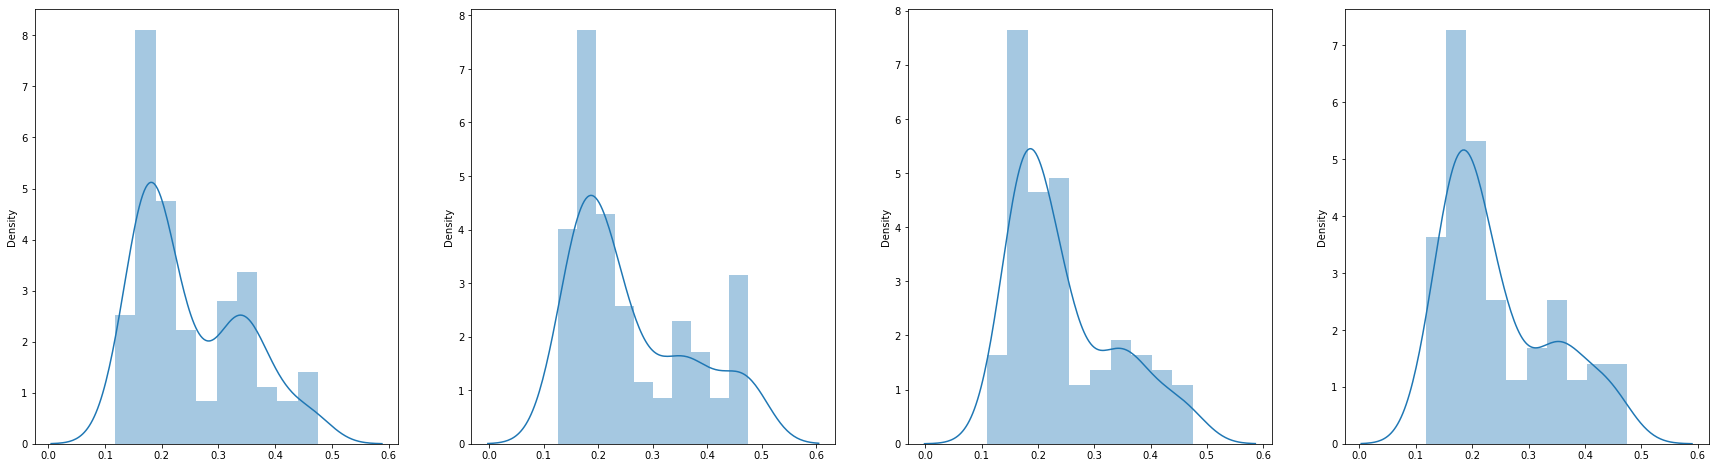

In [105]:
trained_model,org_detect = org_detect_func(org_etfs)
detect = org_detect.copy()
trained_model.save('./models/model_00.pt')
models_path.append('./models/model_00.pt')
detect_record.append(detect)
detect_date_record.append(detect[0][0])

In [106]:
textfile = open("./detect_record/detect_record.txt", "w")
textfile.write("model_00"+'\n')
for dtct_r in detect:
    for kkk in range(len(dtct_r)):
        element = dtct_r[kkk]
#         print(element)
        textfile.write(str(element))
        if kkk<len(dtct_r)-1:
            textfile.write("\t")
        else:
            textfile.write("\n")
textfile.close()

In [107]:
textfile = open("./detect_record/detect_date_record.txt", "w")
textfile.write(detect[0][0]+'\n')
textfile.close()

In [108]:
# models_path.append('./models/model_00.pt')
# detect_record.append(detect)
# detect_date_record.append(detect[0][0])

In [110]:
print(etf_record)
print(detect_record)
print(detect)
print(detect_latest)
print(detect_date_record)

[['ITOT', 'VEU', 'VNQ', 'AGG'], ['RXD', 'VEU', 'VNQ', 'AGG'], ['IXP', 'VEU', 'VNQ', 'AGG']]
[[['2016-01-13', 'ITOT', 0.10812112909782724, 0.2605586825311184], ['2016-03-03', 'VNQ', 0.10885750332628194, 0.27515421390533445], ['2016-07-12', 'AGG', 0.10659958107942404, 0.26254845298826696], ['2016-11-22', 'AGG', 0.10746072355781695, 0.26103378370404245], ['2018-02-06', 'VNQ', 0.10616891408313689, 0.25836283057928083], ['2018-03-02', 'AGG', 0.10738305581207964, 0.2791201673448086], ['2018-06-13', 'VNQ', 0.10721671346121277, 0.2635794802010059], ['2019-07-12', 'AGG', 0.10823394185098739, 0.2780128914117813], ['2019-12-12', 'VNQ', 0.10628339926926171, 0.257767391204834], ['2020-10-23', 'ITOT', 0.11076516202560502, 0.25458020277321336]], [['2016-03-09', 'RXD', 0.10655235369800735, 0.26729426011443136], ['2016-05-31', 'RXD', 0.10642630681809341, 0.27248672030866145], ['2016-06-16', 'VEU', 0.10914955274974998, 0.2663929783552885], ['2016-08-01', 'VNQ', 0.11009608576297758, 0.2586848609149456], 

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2016-01-13', 'ITOT', 0.10812112909782724, 0.2605586825311184], ['2016-03-03', 'VNQ', 0.10885750332628194, 0.27515421390533445], ['2016-07-12', 'AGG', 0.10659958107942404, 0.26254845298826696], ['2016-11-22', 'AGG', 0.10746072355781695, 0.26103378370404245], ['2018-02-06', 'VNQ', 0.10616891408313689, 0.25836283057928083], ['2018-03-02', 'AGG', 0.10738305581207964, 0.2791201673448086], ['2018-06-13', 'VNQ', 0.10721671346121277, 0.2635794802010059], ['2019-07-12', 'AGG', 0.10823394185098739, 0.2780128914117813], ['2019-12-12', 'VNQ', 0.10628339926926171, 0.257767391204834], ['2020-10-23', 'ITOT', 0.11076516202560502, 0.25458020277321336]]
['MUNI', 'VEU', 'VNQ', 'AGG']
['LQD', 'VEU', 'VNQ', 'AGG']
['QMN', 'VEU', 'VNQ', 'AGG']
['IBDM', 'VEU', 'VNQ', 'AGG']
['VT', 'VEU', 'VNQ', 'AGG']
['NFLT', 'VEU', 'VNQ', 'AGG']
['PYZ', 'VEU', 'VNQ', 'AGG']
['DNL', 'VEU', 'VNQ', 'AGG']
['UBR', 'VEU', 'VNQ', 'AGG']
['ONEY', 'VEU', 'VNQ', 'AGG']
['BBH', 'VEU'

begin_total_asset:1000000
end_total_asset:880574.3630403217
Sharpe:  -0.11354034383208403
hit end!
4
begin_total_asset:1000000
end_total_asset:882583.9436851266
Sharpe:  -0.10699097227411283
hit end!
5
begin_total_asset:1000000
end_total_asset:714674.1792432297
Sharpe:  -0.40037297579678893
hit end!
6
begin_total_asset:1000000
end_total_asset:751105.282115061
Sharpe:  -0.29617271191948835
hit end!
7
begin_total_asset:1000000
end_total_asset:837556.512133044
Sharpe:  -0.17763510038787483
hit end!
8
begin_total_asset:1000000
end_total_asset:655061.8793188555
Sharpe:  -0.5035035938519224
hit end!
9
begin_total_asset:1000000
end_total_asset:692118.988816208
Sharpe:  -0.4287058135976548
hit end!
10
begin_total_asset:1000000
end_total_asset:592929.6445456139
Sharpe:  -0.6306656442991352
hit end!
11
begin_total_asset:1000000
end_total_asset:667093.8516541268
Sharpe:  -0.46337464990365607
hit end!
12
begin_total_asset:1000000
end_total_asset:1030047.9782733334
Sharpe:  0.09327228273957158
hit 

begin_total_asset:1000000
end_total_asset:740789.4474867322
Sharpe:  -0.32561659099559875
hit end!
53
begin_total_asset:1000000
end_total_asset:1099100.770651574
Sharpe:  0.17788147987138564
hit end!
54
begin_total_asset:1000000
end_total_asset:682628.763780034
Sharpe:  -0.44517590879674274
hit end!
55
begin_total_asset:1000000
end_total_asset:695712.6184264758
Sharpe:  -0.41146416130460184
hit end!
56
begin_total_asset:1000000
end_total_asset:967960.1719726762
Sharpe:  0.013492471643155746
hit end!
57
begin_total_asset:1000000
end_total_asset:745448.945321935
Sharpe:  -0.34813890481552684
hit end!
58
begin_total_asset:1000000
end_total_asset:713167.8502921219
Sharpe:  -0.37861213780536024
hit end!
59
begin_total_asset:1000000
end_total_asset:763186.9845072635
Sharpe:  -0.2989948492959024
hit end!
60
begin_total_asset:1000000
end_total_asset:646889.3093679422
Sharpe:  -0.5086386400975241
hit end!
61
begin_total_asset:1000000
end_total_asset:826626.6608028554
Sharpe:  -0.180143067509594

begin_total_asset:1000000
end_total_asset:779162.2189676507
Sharpe:  -0.4886891878467751
hit end!
2
begin_total_asset:1000000
end_total_asset:760682.0585061818
Sharpe:  -0.5381562571689922
hit end!
3
begin_total_asset:1000000
end_total_asset:840489.8120257724
Sharpe:  -0.3421702180439582
hit end!
4
begin_total_asset:1000000
end_total_asset:880071.2580073278
Sharpe:  -0.2328039500265115
hit end!
5
begin_total_asset:1000000
end_total_asset:907241.5056523673
Sharpe:  -0.1684467513494379
hit end!
6
begin_total_asset:1000000
end_total_asset:786384.0164417665
Sharpe:  -0.46510283356519094
hit end!
7
begin_total_asset:1000000
end_total_asset:858896.4119559726
Sharpe:  -0.2829309869162362
hit end!
8
begin_total_asset:1000000
end_total_asset:989462.1526470426
Sharpe:  0.02533033171863852
hit end!
9
begin_total_asset:1000000
end_total_asset:870073.9435283218
Sharpe:  -0.2705576541477208
hit end!
10
begin_total_asset:1000000
end_total_asset:820034.0543173603
Sharpe:  -0.37796546029500955
hit end!

begin_total_asset:1000000
end_total_asset:736276.6541036543
Sharpe:  -0.6411166563827515
hit end!
51
begin_total_asset:1000000
end_total_asset:788010.676208933
Sharpe:  -0.4825723801878167
hit end!
52
begin_total_asset:1000000
end_total_asset:756973.9418731009
Sharpe:  -0.5718823690503986
hit end!
53
begin_total_asset:1000000
end_total_asset:816998.4771671991
Sharpe:  -0.37187200882138316
hit end!
54
begin_total_asset:1000000
end_total_asset:941327.964493875
Sharpe:  -0.09000428335321252
hit end!
55
begin_total_asset:1000000
end_total_asset:739362.8797946754
Sharpe:  -0.5809262993486137
hit end!
56
begin_total_asset:1000000
end_total_asset:758007.8704168652
Sharpe:  -0.54084933512491
hit end!
57
begin_total_asset:1000000
end_total_asset:814261.0653434986
Sharpe:  -0.37585992906236343
hit end!
58
begin_total_asset:1000000
end_total_asset:922257.8574134726
Sharpe:  -0.14379527629406086
hit end!
59
begin_total_asset:1000000
end_total_asset:905034.7176786058
Sharpe:  -0.15999985376758113
h

begin_total_asset:1000000
end_total_asset:749715.5845225235
Sharpe:  -0.6019782210496816
hit end!
detect_new [['2016-03-09', 'RXD', 0.10655235369800735, 0.26729426011443136], ['2016-05-31', 'RXD', 0.10642630681809341, 0.27248672030866145], ['2016-06-16', 'VEU', 0.10914955274974998, 0.2663929783552885], ['2016-08-01', 'VNQ', 0.11009608576297758, 0.2586848609149456], ['2016-10-26', 'VEU', 0.10880342967858343, 0.250322952196002], ['2016-10-27', 'RXD', 0.10677669991939517, 0.25796969309449197], ['2017-05-16', 'VNQ', 0.10653867795067846, 0.25733778208494185], ['2017-09-20', 'AGG', 0.10814272382108066, 0.264730287194252], ['2018-06-11', 'AGG', 0.108306307810277, 0.2840507185459137], ['2018-07-12', 'RXD', 0.10736373240052693, 0.24982706896960735], ['2018-08-28', 'AGG', 0.10705040396820686, 0.2619193179160357], ['2019-02-01', 'VEU', 0.11003162017060611, 0.27084128677845], ['2019-02-13', 'RXD', 0.10645426460019632, 0.2691706168651581], ['2019-08-07', 'VEU', 0.10663758000781597, 0.26702302843332

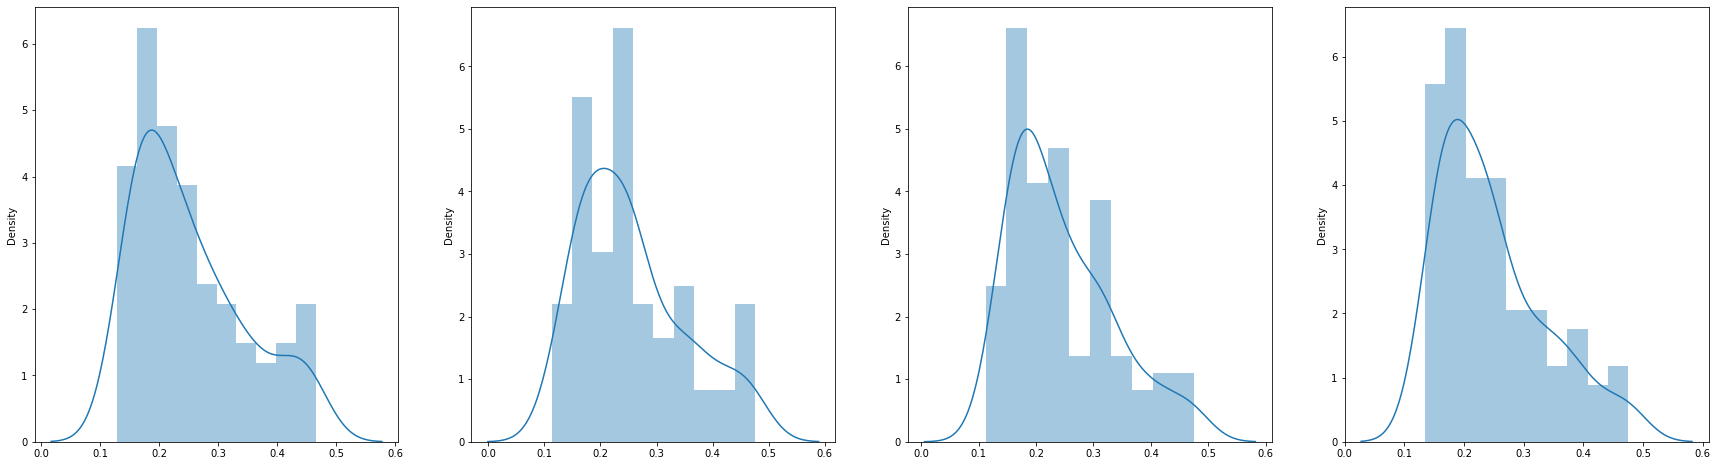

0 AGG 0.09703752164804628 0.2512808685004711
1 RXD 0.10655235369800736 0.26729426011443136
2 VEU 0.09269623826910803 0.24019408211112023
3 VNQ 0.10027215439024452 0.24123078286647798


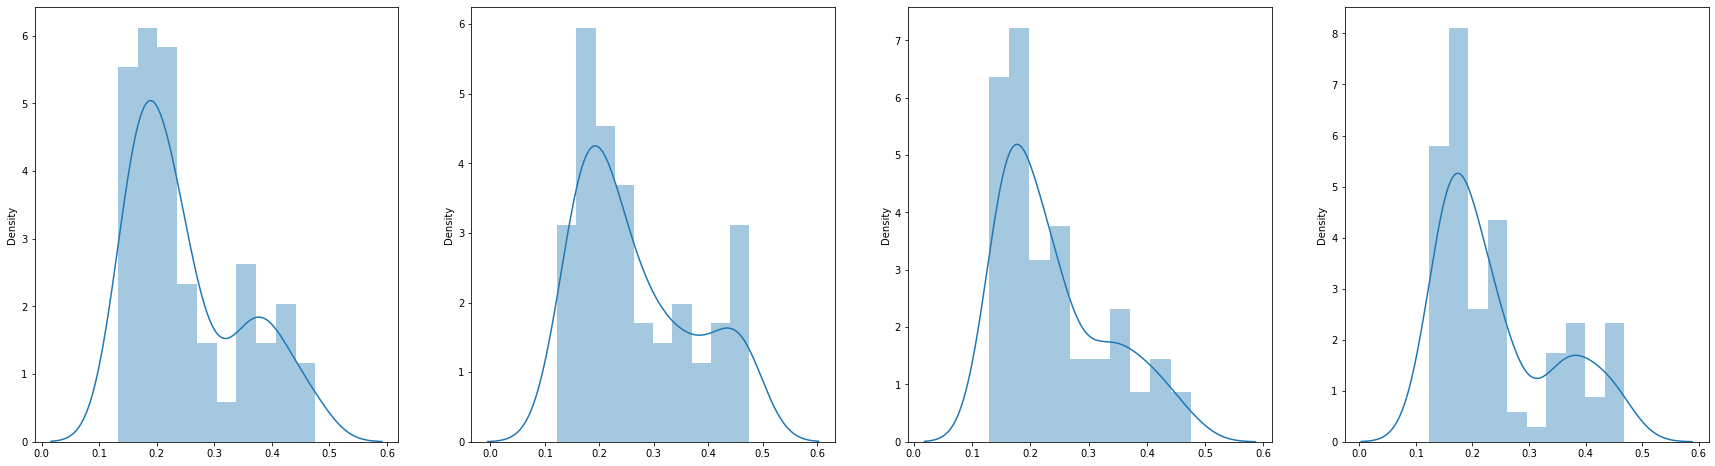

old_etfs: ['RXD', 'VEU', 'VNQ', 'AGG']
detect [['2016-03-09', 'RXD', 0.10655235369800735, 0.26729426011443136], ['2016-05-31', 'RXD', 0.10642630681809341, 0.27248672030866145], ['2016-06-16', 'VEU', 0.10914955274974998, 0.2663929783552885], ['2016-08-01', 'VNQ', 0.11009608576297758, 0.2586848609149456], ['2016-10-26', 'VEU', 0.10880342967858343, 0.250322952196002], ['2016-10-27', 'RXD', 0.10677669991939517, 0.25796969309449197], ['2017-05-16', 'VNQ', 0.10653867795067846, 0.25733778208494185], ['2017-09-20', 'AGG', 0.10814272382108066, 0.264730287194252], ['2018-06-11', 'AGG', 0.108306307810277, 0.2840507185459137], ['2018-07-12', 'RXD', 0.10736373240052693, 0.24982706896960735], ['2018-08-28', 'AGG', 0.10705040396820686, 0.2619193179160357], ['2019-02-01', 'VEU', 0.11003162017060611, 0.27084128677845], ['2019-02-13', 'RXD', 0.10645426460019632, 0.2691706168651581], ['2019-08-07', 'VEU', 0.10663758000781597, 0.26702302843332293], ['2019-08-09', 'VNQ', 0.11061492176301972, 0.272362746074

begin_total_asset:1000000
end_total_asset:1497251.3659367794
Sharpe:  0.44361135452679573
hit end!
23
begin_total_asset:1000000
end_total_asset:1365396.601697268
Sharpe:  0.35644196740265244
hit end!
24
begin_total_asset:1000000
end_total_asset:1393172.9331576962
Sharpe:  0.3748542425023837
hit end!
25
begin_total_asset:1000000
end_total_asset:1342423.5765626172
Sharpe:  0.33720867427208157
hit end!
26
begin_total_asset:1000000
end_total_asset:1429040.9307114044
Sharpe:  0.3959045607962994
hit end!
27
begin_total_asset:1000000
end_total_asset:1479576.7780906274
Sharpe:  0.42830596541686405
hit end!
28
begin_total_asset:1000000
end_total_asset:1374974.466171951
Sharpe:  0.36047695420208953
hit end!
29
begin_total_asset:1000000
end_total_asset:1615636.229148332
Sharpe:  0.5028186467874516
hit end!
30
begin_total_asset:1000000
end_total_asset:1474333.532615076
Sharpe:  0.42500932073357917
hit end!
31
begin_total_asset:1000000
end_total_asset:1606278.1191602086
Sharpe:  0.49832656471365006

begin_total_asset:1000000
end_total_asset:1484885.41254592
Sharpe:  0.4283044577114313
hit end!
72
begin_total_asset:1000000
end_total_asset:1285631.2339444116
Sharpe:  0.30350074999981597
hit end!
73
begin_total_asset:1000000
end_total_asset:1354114.383692593
Sharpe:  0.34898514679601333
hit end!
74
begin_total_asset:1000000
end_total_asset:1364539.4807096857
Sharpe:  0.35420987986301317
hit end!
75
begin_total_asset:1000000
end_total_asset:1466319.6552720647
Sharpe:  0.4161411598880549
hit end!
76
begin_total_asset:1000000
end_total_asset:1445655.1893833228
Sharpe:  0.41098234982639203
hit end!
77
begin_total_asset:1000000
end_total_asset:1550545.201505376
Sharpe:  0.46738506622742865
hit end!
78
begin_total_asset:1000000
end_total_asset:1221234.8958584473
Sharpe:  0.25764367591170956
hit end!
79
begin_total_asset:1000000
end_total_asset:1825375.188060429
Sharpe:  0.607447597845126
hit end!
80
begin_total_asset:1000000
end_total_asset:1272712.0300409247
Sharpe:  0.293463423013358
hit

begin_total_asset:1000000
end_total_asset:1259859.3115754994
Sharpe:  0.40972363131602063
hit end!
21
begin_total_asset:1000000
end_total_asset:1207578.278490624
Sharpe:  0.34086989369426823
hit end!
22
begin_total_asset:1000000
end_total_asset:1227748.0450585915
Sharpe:  0.37084896785226606
hit end!
23
begin_total_asset:1000000
end_total_asset:1370168.8760200301
Sharpe:  0.5237907835029376
hit end!
24
begin_total_asset:1000000
end_total_asset:1280472.6568722564
Sharpe:  0.4264140693796767
hit end!
25
begin_total_asset:1000000
end_total_asset:1267669.2941948643
Sharpe:  0.42293889442788724
hit end!
26
begin_total_asset:1000000
end_total_asset:1174918.391371472
Sharpe:  0.30066887634259826
hit end!
27
begin_total_asset:1000000
end_total_asset:1350425.0888014887
Sharpe:  0.5105594030695579
hit end!
28
begin_total_asset:1000000
end_total_asset:1235226.622596527
Sharpe:  0.3706601676756552
hit end!
29
begin_total_asset:1000000
end_total_asset:1209546.754624276
Sharpe:  0.3505176991044307
h

begin_total_asset:1000000
end_total_asset:1233473.64945772
Sharpe:  0.37374211413573116
hit end!
70
begin_total_asset:1000000
end_total_asset:1282325.2218349553
Sharpe:  0.4434228509800184
hit end!
71
begin_total_asset:1000000
end_total_asset:1178174.8960619005
Sharpe:  0.3062185241929244
hit end!
72
begin_total_asset:1000000
end_total_asset:1082892.796233082
Sharpe:  0.18539584318046576
hit end!
73
begin_total_asset:1000000
end_total_asset:1239381.3048089263
Sharpe:  0.38261325869607443
hit end!
74
begin_total_asset:1000000
end_total_asset:1327902.2758749353
Sharpe:  0.48244763195334894
hit end!
75
begin_total_asset:1000000
end_total_asset:1293140.9877383637
Sharpe:  0.44355253002489536
hit end!
76
begin_total_asset:1000000
end_total_asset:1297756.0273884935
Sharpe:  0.45401663204167847
hit end!
77
begin_total_asset:1000000
end_total_asset:1319593.9683235686
Sharpe:  0.47344933673111145
hit end!
78
begin_total_asset:1000000
end_total_asset:1248589.4368987652
Sharpe:  0.390024255222832

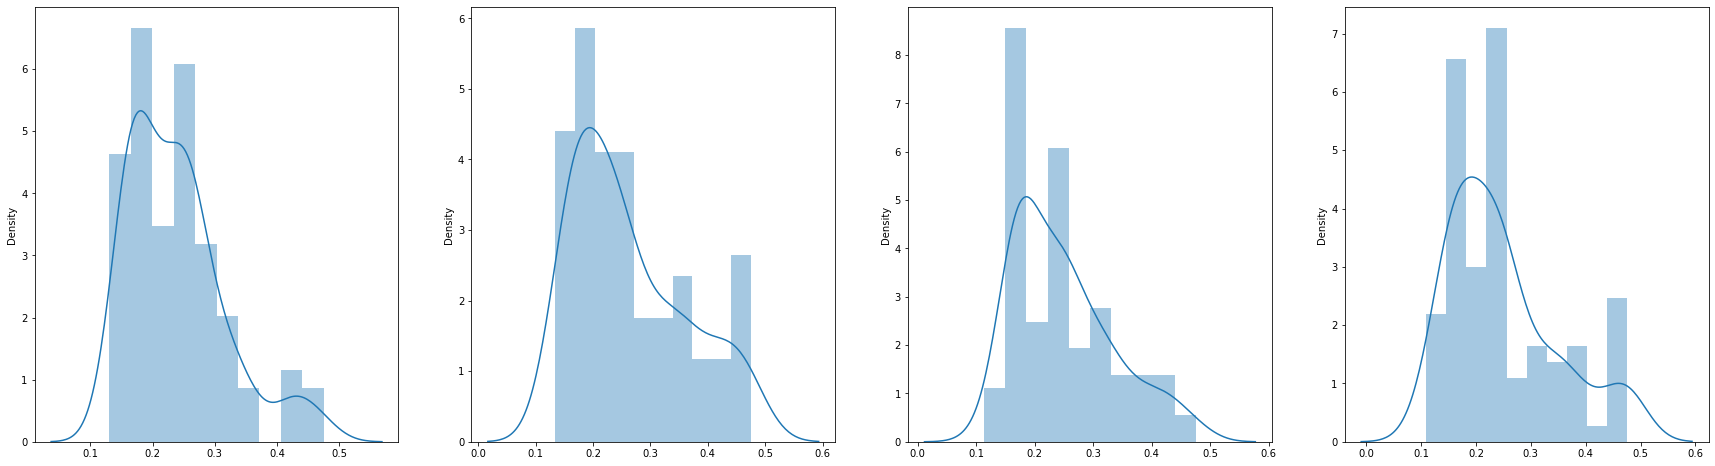

0 AGG 0.08730629889339503 0.24241427153348924
1 IXP 0.09250124401632369 0.2521860306710005
2 VEU 0.09224783614500622 0.24542995862662792
3 VNQ 0.10643004825991016 0.2599697370827198


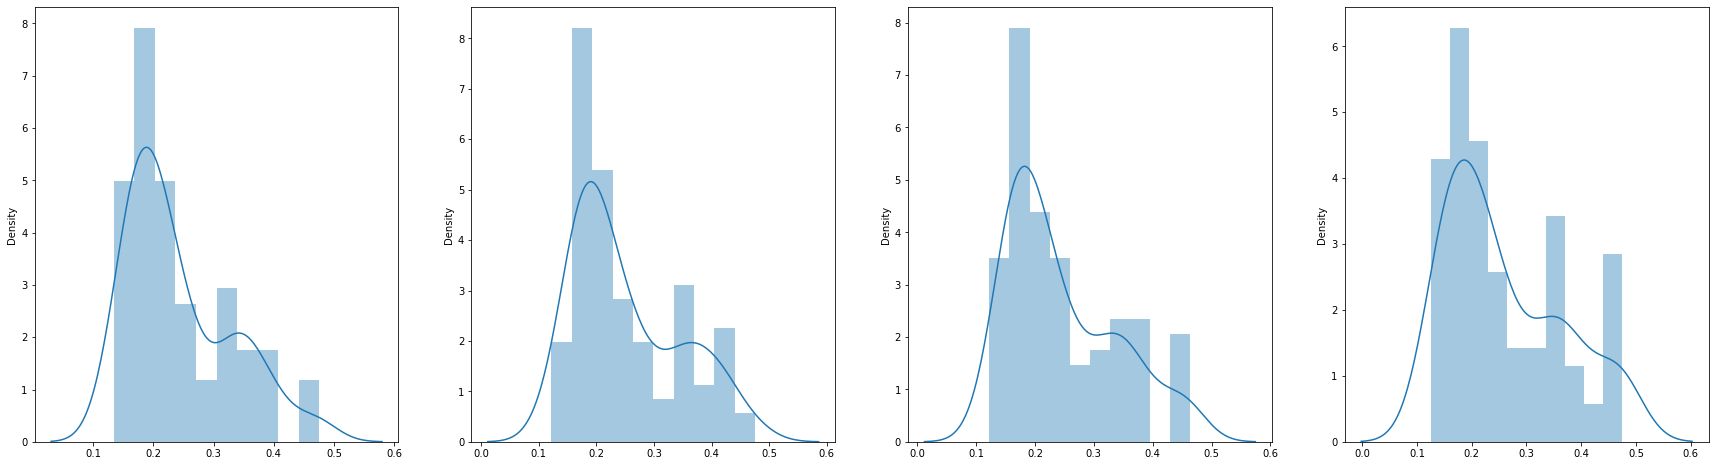

old_etfs: ['IXP', 'VEU', 'VNQ', 'AGG']
detect [['2016-02-29', 'VEU', 0.10618553237719654, 0.26339592404663564], ['2017-05-02', 'VNQ', 0.10643004825991015, 0.2599697370827198], ['2017-10-03', 'VEU', 0.11074653203710341, 0.27238253138959406], ['2017-12-19', 'VNQ', 0.1087183667228038, 0.2622663903981447], ['2018-02-16', 'AGG', 0.10824965123839349, 0.2727473237365484], ['2018-04-19', 'VEU', 0.10852319561906835, 0.2765588314831257], ['2018-06-06', 'IXP', 0.1083193067637982, 0.27687042616307733], ['2018-07-12', 'VEU', 0.10660131429713807, 0.27543745286762716], ['2018-12-28', 'AGG', 0.10783139625134297, 0.2559909420460463], ['2019-01-29', 'VEU', 0.1062860816322731, 0.27908230185508726], ['2019-02-15', 'VNQ', 0.10861801676398011, 0.2542163746058941], ['2019-02-21', 'VEU', 0.10816003688739964, 0.2618427892029285], ['2019-06-05', 'VNQ', 0.10661590198948276, 0.26290710277855395], ['2019-09-27', 'IXP', 0.10776397093858758, 0.2681533980369568], ['2019-10-01', 'VNQ', 0.10948843928158794, 0.277004526

begin_total_asset:1000000
end_total_asset:1542470.4089560744
Sharpe:  0.45935856633802297
hit end!
38
begin_total_asset:1000000
end_total_asset:1580374.6844095916
Sharpe:  0.4781799169770624
hit end!
39
begin_total_asset:1000000
end_total_asset:1695603.0189391368
Sharpe:  0.5446879334851268
hit end!
40
begin_total_asset:1000000
end_total_asset:1596870.2464975992
Sharpe:  0.48658558733237484
hit end!
41
begin_total_asset:1000000
end_total_asset:1543570.3396844908
Sharpe:  0.453161396708176
hit end!
42
begin_total_asset:1000000
end_total_asset:1592089.898618537
Sharpe:  0.48615347761307653
hit end!
43
begin_total_asset:1000000
end_total_asset:1640199.720867524
Sharpe:  0.5156171683633017
hit end!
44
begin_total_asset:1000000
end_total_asset:1541346.033337128
Sharpe:  0.45736302338783574
hit end!
45
begin_total_asset:1000000
end_total_asset:1570871.5125255827
Sharpe:  0.4720912913515016
hit end!
46
begin_total_asset:1000000
end_total_asset:1789090.2145409659
Sharpe:  0.5835403014163817
hi

begin_total_asset:1000000
end_total_asset:1874018.7392118308
Sharpe:  0.6219609185247592
hit end!
87
begin_total_asset:1000000
end_total_asset:1827855.258703269
Sharpe:  0.6088873285918811
hit end!
88
begin_total_asset:1000000
end_total_asset:1487407.8114161503
Sharpe:  0.42214149945155505
hit end!
89
begin_total_asset:1000000
end_total_asset:1651064.6191706876
Sharpe:  0.5164180111590996
hit end!
90
begin_total_asset:1000000
end_total_asset:1927661.4176911262
Sharpe:  0.6525228719082555
hit end!
91
begin_total_asset:1000000
end_total_asset:1735158.764948981
Sharpe:  0.551278417787112
hit end!
92
begin_total_asset:1000000
end_total_asset:1591146.5637099517
Sharpe:  0.4804582841859214
hit end!
93
begin_total_asset:1000000
end_total_asset:1687270.1433996514
Sharpe:  0.537011054283398
hit end!
94
begin_total_asset:1000000
end_total_asset:1598220.2856926674
Sharpe:  0.49399562410969655
hit end!
95
begin_total_asset:1000000
end_total_asset:1621546.2114511882
Sharpe:  0.5001717035968624
hit 

begin_total_asset:1000000
end_total_asset:1366517.4543984584
Sharpe:  0.5015492781317548
hit end!
36
begin_total_asset:1000000
end_total_asset:1381081.89989038
Sharpe:  0.5230719588169629
hit end!
37
begin_total_asset:1000000
end_total_asset:1330576.2539734256
Sharpe:  0.46971033416133606
hit end!
38
begin_total_asset:1000000
end_total_asset:1352340.9237312358
Sharpe:  0.48780502943554205
hit end!
39
begin_total_asset:1000000
end_total_asset:1447936.9269065307
Sharpe:  0.5924573976394617
hit end!
40
begin_total_asset:1000000
end_total_asset:1295540.046716465
Sharpe:  0.4348552322801171
hit end!
41
begin_total_asset:1000000
end_total_asset:1370077.247878448
Sharpe:  0.5149025963322474
hit end!
42
begin_total_asset:1000000
end_total_asset:1361035.2986724149
Sharpe:  0.5060319918958891
hit end!
43
begin_total_asset:1000000
end_total_asset:1420493.3528356452
Sharpe:  0.5666070882663016
hit end!
44
begin_total_asset:1000000
end_total_asset:1382408.9234756406
Sharpe:  0.5185288246247058
hit 

begin_total_asset:1000000
end_total_asset:1323400.223252123
Sharpe:  0.47669457247636426
hit end!
85
begin_total_asset:1000000
end_total_asset:1417318.0108816323
Sharpe:  0.5565405889183938
hit end!
86
begin_total_asset:1000000
end_total_asset:1343464.6505552323
Sharpe:  0.48901908657563037
hit end!
87
begin_total_asset:1000000
end_total_asset:1355303.7605766137
Sharpe:  0.4891347686165798
hit end!
88
begin_total_asset:1000000
end_total_asset:1336097.3351557143
Sharpe:  0.47651398803845807
hit end!
89
begin_total_asset:1000000
end_total_asset:1422307.179609731
Sharpe:  0.5703389847887426
hit end!
90
begin_total_asset:1000000
end_total_asset:1418965.6493513298
Sharpe:  0.5702810154635642
hit end!
91
begin_total_asset:1000000
end_total_asset:1377029.2518575245
Sharpe:  0.5210304127833638
hit end!
92
begin_total_asset:1000000
end_total_asset:1343666.048090722
Sharpe:  0.48342533739747223
hit end!
93
begin_total_asset:1000000
end_total_asset:1260802.722288688
Sharpe:  0.3916895381806858
hi

StatisticsError: variance requires at least two data points

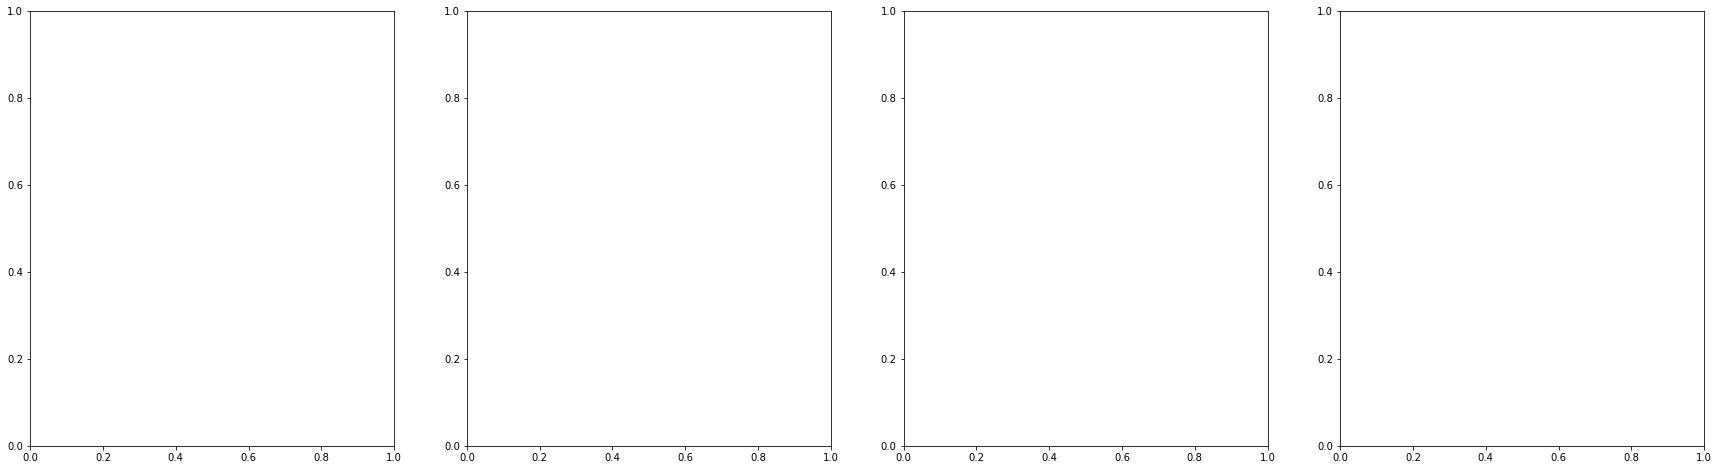

In [109]:
old_etfs = org_etfs.copy()
detect = detect_record[0]
detect_latest = detect[0]
last_detect_date = '2016-01-04'
# print(detect)
count=1
while True:
    random.shuffle(all_etf)
    print('old_etfs:',old_etfs)
    print('detect',detect)
    trained_model,now_etfs,detect_new,detect_latest,last_detect_date = find_new_target(old_etfs,detect,detect_latest,trained_model,last_detect_date)
    detect_record.append(detect_new)
    detect_date_record.append(detect_latest[0])
    etf_record.append(now_etfs)
    
#     last_detect_date = detect_latest[0]
    old_etfs = now_etfs.copy()
    detect = detect_new
    
    textfile = open("./detect_record/detect_record.txt", "a")
    if count<10:
        textfile.write('model_0'+str(count)+'\n')
    else:
        textfile.write('model_'+str(count)+'\n')
    for dtct_r in detect:
        for kkk in range(len(dtct_r)):
            element = dtct_r[kkk]
#             print(element)
            textfile.write(str(element))
            if kkk<len(dtct_r)-1:
                textfile.write("\t")
            else:
                textfile.write("\n")
    textfile.close()
    
    textfile = open("./detect_record/detect_date_record.txt", "a")
    textfile.write(detect_latest[0]+'\n')
    textfile.close()
    
    count+=1
    if detect_latest==[]:
        break

In [113]:
print(last_detect_date)
print(detect)
print(detect_latest)
print(old_etfs)

2016-03-09
[['2016-02-29', 'VEU', 0.10618553237719654, 0.26339592404663564], ['2017-05-02', 'VNQ', 0.10643004825991015, 0.2599697370827198], ['2017-10-03', 'VEU', 0.11074653203710341, 0.27238253138959406], ['2017-12-19', 'VNQ', 0.1087183667228038, 0.2622663903981447], ['2018-02-16', 'AGG', 0.10824965123839349, 0.2727473237365484], ['2018-04-19', 'VEU', 0.10852319561906835, 0.2765588314831257], ['2018-06-06', 'IXP', 0.1083193067637982, 0.27687042616307733], ['2018-07-12', 'VEU', 0.10660131429713807, 0.27543745286762716], ['2018-12-28', 'AGG', 0.10783139625134297, 0.2559909420460463], ['2019-01-29', 'VEU', 0.1062860816322731, 0.27908230185508726], ['2019-02-15', 'VNQ', 0.10861801676398011, 0.2542163746058941], ['2019-02-21', 'VEU', 0.10816003688739964, 0.2618427892029285], ['2019-06-05', 'VNQ', 0.10661590198948276, 0.26290710277855395], ['2019-09-27', 'IXP', 0.10776397093858758, 0.2681533980369568], ['2019-10-01', 'VNQ', 0.10948843928158794, 0.27700452610850335], ['2020-05-04', 'AGG', 0.

old_etfs: ['IXP', 'VEU', 'VNQ', 'AGG']
detect [['2016-02-29', 'VEU', 0.10618553237719654, 0.26339592404663564], ['2017-05-02', 'VNQ', 0.10643004825991015, 0.2599697370827198], ['2017-10-03', 'VEU', 0.11074653203710341, 0.27238253138959406], ['2017-12-19', 'VNQ', 0.1087183667228038, 0.2622663903981447], ['2018-02-16', 'AGG', 0.10824965123839349, 0.2727473237365484], ['2018-04-19', 'VEU', 0.10852319561906835, 0.2765588314831257], ['2018-06-06', 'IXP', 0.1083193067637982, 0.27687042616307733], ['2018-07-12', 'VEU', 0.10660131429713807, 0.27543745286762716], ['2018-12-28', 'AGG', 0.10783139625134297, 0.2559909420460463], ['2019-01-29', 'VEU', 0.1062860816322731, 0.27908230185508726], ['2019-02-15', 'VNQ', 0.10861801676398011, 0.2542163746058941], ['2019-02-21', 'VEU', 0.10816003688739964, 0.2618427892029285], ['2019-06-05', 'VNQ', 0.10661590198948276, 0.26290710277855395], ['2019-09-27', 'IXP', 0.10776397093858758, 0.2681533980369568], ['2019-10-01', 'VNQ', 0.10948843928158794, 0.277004526

begin_total_asset:1000000
end_total_asset:1760354.1225615398
Sharpe:  0.5720738746428671
hit end!
37
begin_total_asset:1000000
end_total_asset:1545874.468641654
Sharpe:  0.4605322437659049
hit end!
38
begin_total_asset:1000000
end_total_asset:1822421.1290879832
Sharpe:  0.6053158489237414
hit end!
39
begin_total_asset:1000000
end_total_asset:1764066.3890193773
Sharpe:  0.5704188362507845
hit end!
40
begin_total_asset:1000000
end_total_asset:1680354.8405333003
Sharpe:  0.5334329070933075
hit end!
41
begin_total_asset:1000000
end_total_asset:1730246.2364700127
Sharpe:  0.5555028369791655
hit end!
42
begin_total_asset:1000000
end_total_asset:1972512.248784621
Sharpe:  0.6761955937460082
hit end!
43
begin_total_asset:1000000
end_total_asset:1824096.1602669598
Sharpe:  0.6023249532500508
hit end!
44
begin_total_asset:1000000
end_total_asset:1543886.488393993
Sharpe:  0.45967632312497514
hit end!
45
begin_total_asset:1000000
end_total_asset:2054976.8053376505
Sharpe:  0.7084899762850008
hit 

begin_total_asset:1000000
end_total_asset:1782810.9426612365
Sharpe:  0.5849923640069955
hit end!
86
begin_total_asset:1000000
end_total_asset:1725567.5246258876
Sharpe:  0.5651207047248443
hit end!
87
begin_total_asset:1000000
end_total_asset:1748255.6098585515
Sharpe:  0.560454839735361
hit end!
88
begin_total_asset:1000000
end_total_asset:1577704.0755083032
Sharpe:  0.47519045033380675
hit end!
89
begin_total_asset:1000000
end_total_asset:1853147.2667849478
Sharpe:  0.6176525339038814
hit end!
90
begin_total_asset:1000000
end_total_asset:1554482.4887281167
Sharpe:  0.4676249143148866
hit end!
91
begin_total_asset:1000000
end_total_asset:1559189.3295314244
Sharpe:  0.4725530532742324
hit end!
92
begin_total_asset:1000000
end_total_asset:1615393.2560659256
Sharpe:  0.4905782343870067
hit end!
93
begin_total_asset:1000000
end_total_asset:1838860.7602187572
Sharpe:  0.6096771461036675
hit end!
94
begin_total_asset:1000000
end_total_asset:1687422.9899723884
Sharpe:  0.5352163333665081
hi

begin_total_asset:1000000
end_total_asset:1326071.3042439928
Sharpe:  0.4586764278769489
hit end!
35
begin_total_asset:1000000
end_total_asset:1325264.6143210304
Sharpe:  0.4568081280110305
hit end!
36
begin_total_asset:1000000
end_total_asset:1458914.434633473
Sharpe:  0.5999501532225616
hit end!
37
begin_total_asset:1000000
end_total_asset:1428025.6789699919
Sharpe:  0.5667533218916433
hit end!
38
begin_total_asset:1000000
end_total_asset:1298031.5357855044
Sharpe:  0.4397294455655812
hit end!
39
begin_total_asset:1000000
end_total_asset:1272569.3095552528
Sharpe:  0.4138234056170149
hit end!
40
begin_total_asset:1000000
end_total_asset:1559593.208879362
Sharpe:  0.714954822283902
hit end!
41
begin_total_asset:1000000
end_total_asset:1427101.6793051288
Sharpe:  0.5698914562699129
hit end!
42
begin_total_asset:1000000
end_total_asset:1306879.833109518
Sharpe:  0.4432379316792902
hit end!
43
begin_total_asset:1000000
end_total_asset:1282680.393902556
Sharpe:  0.42047680033366736
hit en

begin_total_asset:1000000
end_total_asset:1366586.3099878468
Sharpe:  0.5136195290845862
hit end!
84
begin_total_asset:1000000
end_total_asset:1373045.2153498225
Sharpe:  0.5124476141682625
hit end!
85
begin_total_asset:1000000
end_total_asset:1470183.8188861804
Sharpe:  0.618896594077173
hit end!
86
begin_total_asset:1000000
end_total_asset:1240663.5583870742
Sharpe:  0.36984782352811574
hit end!
87
begin_total_asset:1000000
end_total_asset:1187392.7968590662
Sharpe:  0.3143519939134252
hit end!
88
begin_total_asset:1000000
end_total_asset:1435330.7964065392
Sharpe:  0.5805123996336411
hit end!
89
begin_total_asset:1000000
end_total_asset:1321901.4478365248
Sharpe:  0.45378741820543367
hit end!
90
begin_total_asset:1000000
end_total_asset:1253233.282303464
Sharpe:  0.3907094977125383
hit end!
91
begin_total_asset:1000000
end_total_asset:1297982.9023994843
Sharpe:  0.45222747986136286
hit end!
92
begin_total_asset:1000000
end_total_asset:1382949.6111560941
Sharpe:  0.5262218609045017
h

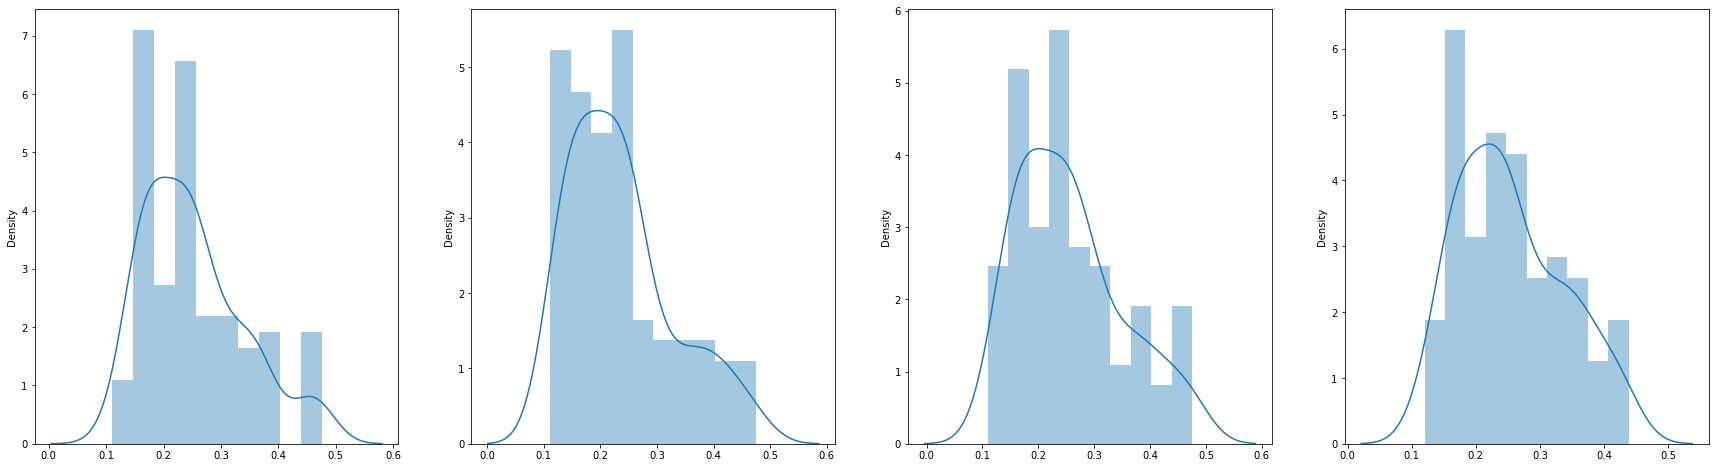

0 AGG 0.10825290487409857 0.2732873376458883
1 ITOT 0.09327941223583934 0.25217254742980005
2 VEU 0.08906201856951192 0.2330007679015398
3 VNQ 0.09992663445780718 0.241539351567626


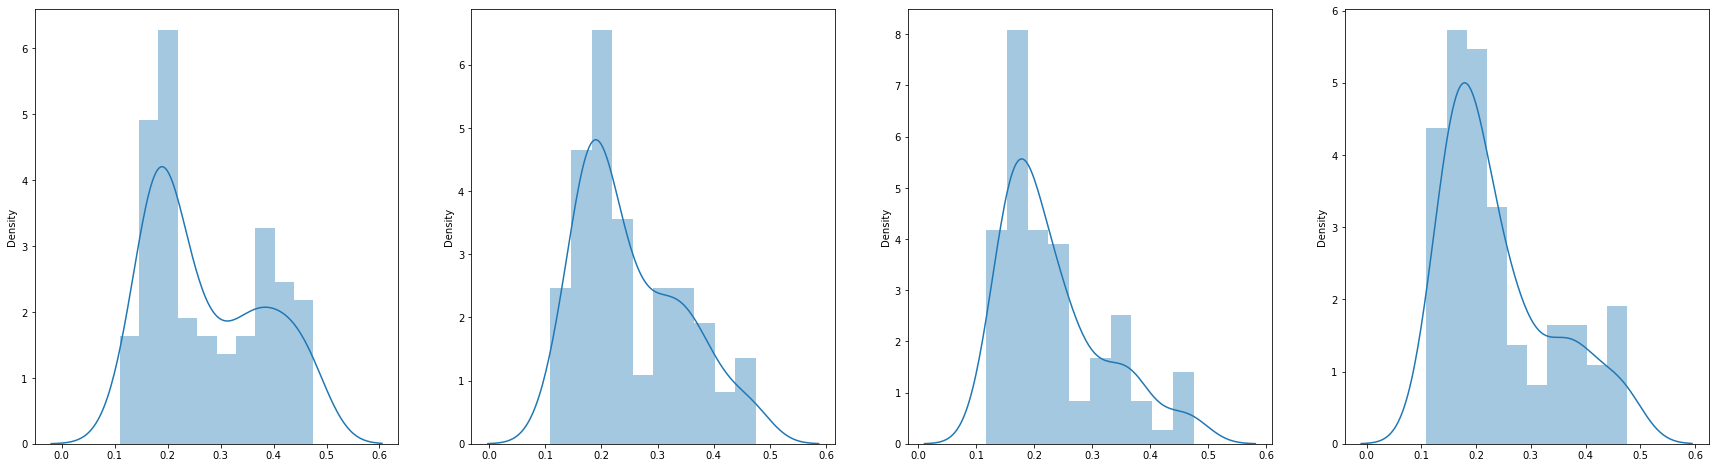

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2016-01-06', 'VEU', 0.10652130622349183, 0.26052966244518755], ['2016-01-21', 'AGG', 0.10715527719527738, 0.2598156680166721], ['2016-04-29', 'AGG', 0.10825290487409855, 0.2732873376458883], ['2016-12-02', 'ITOT', 0.1069529432943554, 0.2671220171451569], ['2016-12-12', 'AGG', 0.1087290584416045, 0.26929004833102227], ['2017-04-21', 'ITOT', 0.10623982759615533, 0.2528824623674154], ['2017-06-06', 'VNQ', 0.10693709710074024, 0.2622862372547388], ['2017-06-20', 'VEU', 0.10741855717692668, 0.27494212187826633], ['2017-07-14', 'VNQ', 0.11219016028519199, 0.26318252451717855], ['2017-09-12', 'VNQ', 0.10829718638172285, 0.26896134853363035], ['2017-10-17', 'VEU', 0.10807387541465381, 0.2686417125165462], ['2017-10-18', 'ITOT', 0.10804167377773338, 0.26213470511138437], ['2017-10-26', 'VNQ', 0.10688528451369997, 0.2566127572208643], ['2018-04-18', 'ITOT', 0.1062794261501595, 0.2656628043204546], ['2019-01-31', 'AGG', 0.10734967580081263, 0.2502

begin_total_asset:1000000
end_total_asset:1618948.3081829618
Sharpe:  0.5011483235938324
hit end!
24
begin_total_asset:1000000
end_total_asset:1570107.3045040192
Sharpe:  0.46915846181994764
hit end!
25
begin_total_asset:1000000
end_total_asset:1666323.478117737
Sharpe:  0.5314681468299155
hit end!
26
begin_total_asset:1000000
end_total_asset:1612435.0935011469
Sharpe:  0.4991679442811132
hit end!
27
begin_total_asset:1000000
end_total_asset:1901156.0467449757
Sharpe:  0.6323263221713249
hit end!
28
begin_total_asset:1000000
end_total_asset:1620622.751545372
Sharpe:  0.502726290257772
hit end!
29
begin_total_asset:1000000
end_total_asset:1764865.4577763327
Sharpe:  0.5786833646337293
hit end!
30
begin_total_asset:1000000
end_total_asset:1826762.3659083012
Sharpe:  0.6079707773054649
hit end!
31
begin_total_asset:1000000
end_total_asset:1577891.7363338056
Sharpe:  0.47732070623111483
hit end!
32
begin_total_asset:1000000
end_total_asset:1827543.5079688851
Sharpe:  0.6096659011495965
hit

begin_total_asset:1000000
end_total_asset:1590956.6254724287
Sharpe:  0.48504564167286257
hit end!
73
begin_total_asset:1000000
end_total_asset:1841077.2691986985
Sharpe:  0.6130895762351096
hit end!
74
begin_total_asset:1000000
end_total_asset:1483873.1138554125
Sharpe:  0.42553511844370706
hit end!
75
begin_total_asset:1000000
end_total_asset:1731429.6335978126
Sharpe:  0.5582193697002577
hit end!
76
begin_total_asset:1000000
end_total_asset:1667177.5567284997
Sharpe:  0.525012308851522
hit end!
77
begin_total_asset:1000000
end_total_asset:1802624.0874768938
Sharpe:  0.5956462774926736
hit end!
78
begin_total_asset:1000000
end_total_asset:1718001.1024764504
Sharpe:  0.5559356477418212
hit end!
79
begin_total_asset:1000000
end_total_asset:1767495.6817297814
Sharpe:  0.5736000144906537
hit end!
80
begin_total_asset:1000000
end_total_asset:1745807.3847849069
Sharpe:  0.5647352885933254
hit end!
81
begin_total_asset:1000000
end_total_asset:1874131.356755275
Sharpe:  0.6335809346328106
hi

begin_total_asset:1000000
end_total_asset:1221883.5961343513
Sharpe:  0.3555873992390948
hit end!
22
begin_total_asset:1000000
end_total_asset:1292136.798707357
Sharpe:  0.4209954249181037
hit end!
23
begin_total_asset:1000000
end_total_asset:1326702.3413375672
Sharpe:  0.48013145697347714
hit end!
24
begin_total_asset:1000000
end_total_asset:1333737.9603477127
Sharpe:  0.47448021683431574
hit end!
25
begin_total_asset:1000000
end_total_asset:1391982.8748355673
Sharpe:  0.5302632934175732
hit end!
26
begin_total_asset:1000000
end_total_asset:1491519.1935849346
Sharpe:  0.6370284883387434
hit end!
27
begin_total_asset:1000000
end_total_asset:1352686.1695651559
Sharpe:  0.4935465880619782
hit end!
28
begin_total_asset:1000000
end_total_asset:1494306.860162555
Sharpe:  0.6462049889281359
hit end!
29
begin_total_asset:1000000
end_total_asset:1373268.6987971824
Sharpe:  0.5334185795955326
hit end!
30
begin_total_asset:1000000
end_total_asset:1452291.727802284
Sharpe:  0.6095352468334144
hit

begin_total_asset:1000000
end_total_asset:1462352.7563781403
Sharpe:  0.6046112520833521
hit end!
71
begin_total_asset:1000000
end_total_asset:1307526.164679849
Sharpe:  0.45154657313577284
hit end!
72
begin_total_asset:1000000
end_total_asset:1415562.5342689122
Sharpe:  0.5528429106253773
hit end!
73
begin_total_asset:1000000
end_total_asset:1452752.637916717
Sharpe:  0.5919929055675283
hit end!
74
begin_total_asset:1000000
end_total_asset:1305948.527014986
Sharpe:  0.45715308654371145
hit end!
75
begin_total_asset:1000000
end_total_asset:1417330.4448629166
Sharpe:  0.5618166949772248
hit end!
76
begin_total_asset:1000000
end_total_asset:1332297.5773718734
Sharpe:  0.47755027886988155
hit end!
77
begin_total_asset:1000000
end_total_asset:1379859.235521177
Sharpe:  0.528705187537893
hit end!
78
begin_total_asset:1000000
end_total_asset:1447057.6691552284
Sharpe:  0.5902784662660092
hit end!
79
begin_total_asset:1000000
end_total_asset:1342890.9799558867
Sharpe:  0.49185644850518295
hit

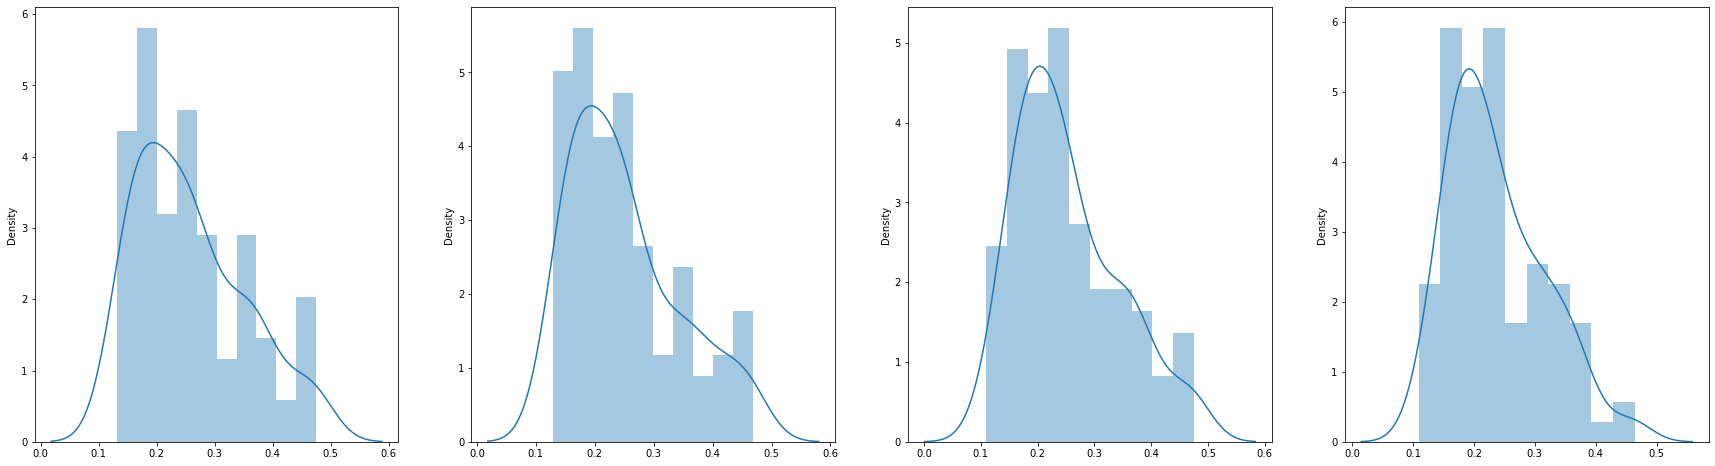

0 BIV 0.08863958860470414 0.2323429884761572
1 ITOT 0.09633888637829395 0.25569506123661995
2 VEU 0.1114545372230059 0.2721028196811676
3 VNQ 0.09005052539773338 0.23985913299024106


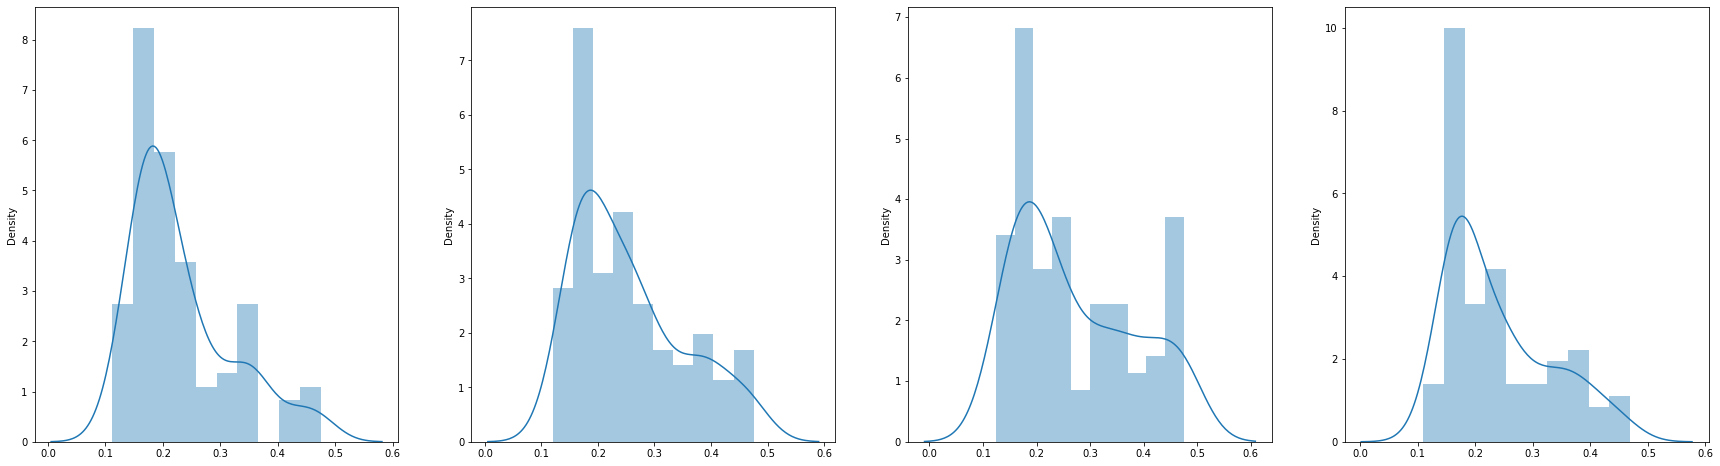

old_etfs: ['ITOT', 'VEU', 'VNQ', 'BIV']
detect [['2016-03-21', 'ITOT', 0.10737173314617544, 0.26326840683817865], ['2016-09-13', 'VEU', 0.1114545372230059, 0.2721028196811676], ['2017-03-16', 'VEU', 0.10633860882252048, 0.25902573332190515], ['2017-05-16', 'VEU', 0.10655365884916904, 0.27607895456254483], ['2018-04-12', 'VNQ', 0.10645539268559906, 0.2615501920878887], ['2019-01-17', 'VNQ', 0.10643126731910534, 0.2607279697060585], ['2019-05-20', 'ITOT', 0.10862390021977943, 0.2614310595393181], ['2019-07-15', 'VNQ', 0.11236902998019742, 0.2602781121432781], ['2019-08-19', 'BIV', 0.10715574268979776, 0.2575484361499548], ['2020-07-13', 'ITOT', 0.11320685396456663, 0.2681142096966505]]
ITOT ['ITOT', 'VEU', 'VNQ', 'BIV']
VEU ['ITOT', 'VEU', 'VNQ', 'BIV']
VNQ ['ITOT', 'VEU', 'VNQ', 'BIV']
AGG ['ITOT', 'VEU', 'VNQ', 'BIV']
AGGnot in comb
['ITOT', 'VEU', 'VNQ', 'AGG']
2016-04-30 2016-09-13
2016-04-30 no trade
2016-05-01 no trade
abc ok
['ITOT', 'VEU', 'VNQ', 'AGG']
abc ok
[******************

begin_total_asset:1000000
end_total_asset:1746184.054667719
Sharpe:  0.5650496473937281
hit end!
41
begin_total_asset:1000000
end_total_asset:1733550.652314881
Sharpe:  0.5587014276051403
hit end!
42
begin_total_asset:1000000
end_total_asset:1720529.7531427555
Sharpe:  0.55299040740043
hit end!
43
begin_total_asset:1000000
end_total_asset:1736059.7992867122
Sharpe:  0.5668547616215204
hit end!
44
begin_total_asset:1000000
end_total_asset:1765208.2619287628
Sharpe:  0.581112204665326
hit end!
45
begin_total_asset:1000000
end_total_asset:1431572.381932449
Sharpe:  0.39440370044297873
hit end!
46
begin_total_asset:1000000
end_total_asset:1742389.431229199
Sharpe:  0.5716196368569397
hit end!
47
begin_total_asset:1000000
end_total_asset:1596470.1875400797
Sharpe:  0.4866805039081752
hit end!
48
begin_total_asset:1000000
end_total_asset:1797242.0425905355
Sharpe:  0.5833999446311514
hit end!
49
begin_total_asset:1000000
end_total_asset:2079364.721162078
Sharpe:  0.7123382014196756
hit end!


begin_total_asset:1000000
end_total_asset:1635146.486643877
Sharpe:  0.5049702631106877
hit end!
90
begin_total_asset:1000000
end_total_asset:1722046.6657994173
Sharpe:  0.5489985997192767
hit end!
91
begin_total_asset:1000000
end_total_asset:1994798.7711493615
Sharpe:  0.683695491676226
hit end!
92
begin_total_asset:1000000
end_total_asset:1641898.71800026
Sharpe:  0.511260163091853
hit end!
93
begin_total_asset:1000000
end_total_asset:1696083.7560376134
Sharpe:  0.5434145833048528
hit end!
94
begin_total_asset:1000000
end_total_asset:1709754.1348917847
Sharpe:  0.5510870190798572
hit end!
95
begin_total_asset:1000000
end_total_asset:1882335.2494757522
Sharpe:  0.6297847220499626
hit end!
96
begin_total_asset:1000000
end_total_asset:1552584.073435446
Sharpe:  0.46090758824966144
hit end!
97
begin_total_asset:1000000
end_total_asset:1777519.3233620168
Sharpe:  0.5780897284926636
hit end!
98
begin_total_asset:1000000
end_total_asset:1580658.6709556982
Sharpe:  0.4820772057659595
hit end

begin_total_asset:1000000
end_total_asset:1292549.9472639814
Sharpe:  0.4285283528413059
hit end!
39
begin_total_asset:1000000
end_total_asset:1343546.849961619
Sharpe:  0.4868279093093965
hit end!
40
begin_total_asset:1000000
end_total_asset:1273398.581502814
Sharpe:  0.40854856556017083
hit end!
41
begin_total_asset:1000000
end_total_asset:1157294.2850003485
Sharpe:  0.2746024100423096
hit end!
42
begin_total_asset:1000000
end_total_asset:1449320.0429312298
Sharpe:  0.5969076054627807
hit end!
43
begin_total_asset:1000000
end_total_asset:1283883.020296273
Sharpe:  0.4193464155335396
hit end!
44
begin_total_asset:1000000
end_total_asset:1454010.84263525
Sharpe:  0.5856657843905168
hit end!
45
begin_total_asset:1000000
end_total_asset:1326504.6300238946
Sharpe:  0.4626569987580683
hit end!
46
begin_total_asset:1000000
end_total_asset:1314522.4041729236
Sharpe:  0.4530825394197868
hit end!
47
begin_total_asset:1000000
end_total_asset:1221865.6603733052
Sharpe:  0.35380419030132454
hit e

begin_total_asset:1000000
end_total_asset:1374148.9610105362
Sharpe:  0.525951061594999
hit end!
88
begin_total_asset:1000000
end_total_asset:1428771.929179938
Sharpe:  0.5661654537007349
hit end!
89
begin_total_asset:1000000
end_total_asset:1300683.2809240173
Sharpe:  0.438763203998904
hit end!
90
begin_total_asset:1000000
end_total_asset:1402350.0714680897
Sharpe:  0.550144188821852
hit end!
91
begin_total_asset:1000000
end_total_asset:1278609.3430359887
Sharpe:  0.41197961440548286
hit end!
92
begin_total_asset:1000000
end_total_asset:1275357.9439595705
Sharpe:  0.4059519443051624
hit end!
93
begin_total_asset:1000000
end_total_asset:1263810.3784767275
Sharpe:  0.40407971144656546
hit end!
94
begin_total_asset:1000000
end_total_asset:1378583.0792654904
Sharpe:  0.5182721184704866
hit end!
95
begin_total_asset:1000000
end_total_asset:1288720.5407141475
Sharpe:  0.4257618779383477
hit end!
96
begin_total_asset:1000000
end_total_asset:1364775.325361055
Sharpe:  0.5190096329069057
hit e

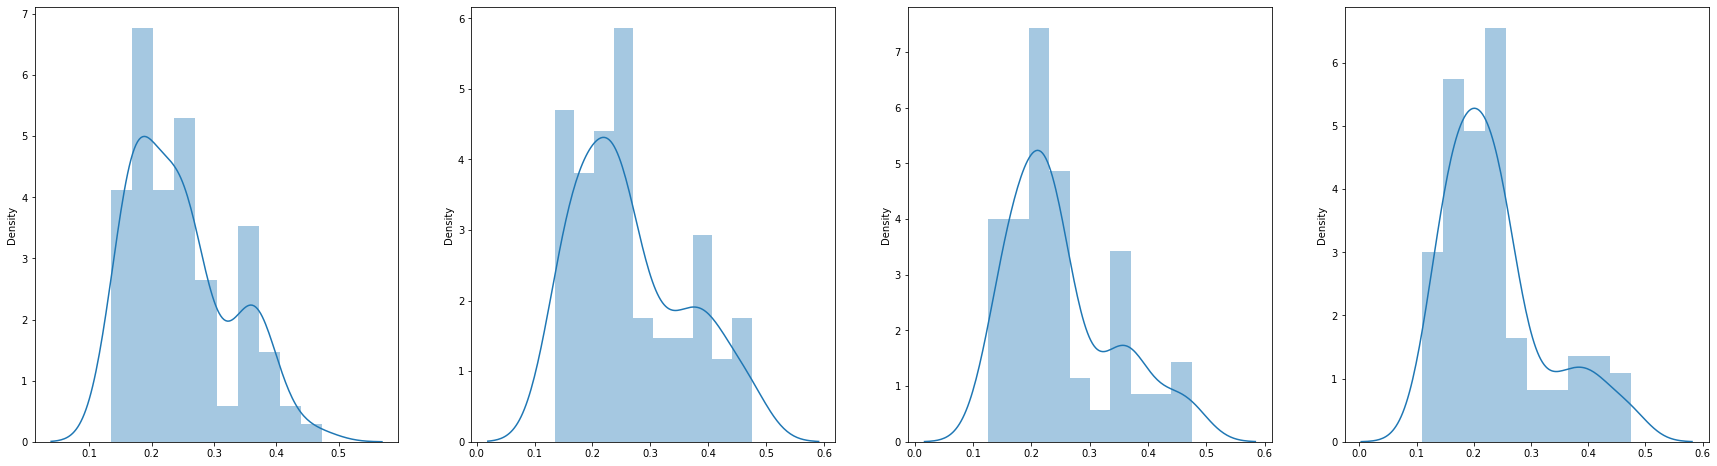

0 AGG 0.09225016728528988 0.25867004968225954
1 ITOT 0.10786612225459312 0.26245866775512694
2 VEU 0.07683798999525303 0.236066025942564
3 VNQ 0.08140418663711993 0.24280526250600815


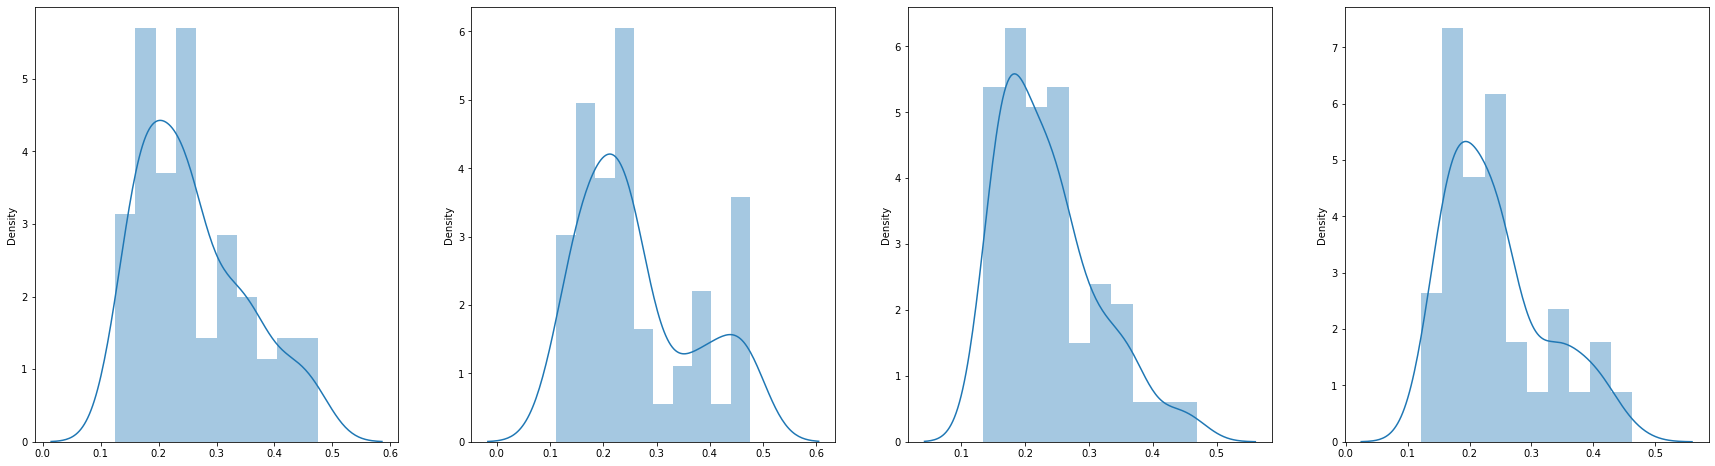

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2016-01-05', 'AGG', 0.10687664487454754, 0.26724370747804643], ['2016-03-22', 'VEU', 0.10793832004133959, 0.26925769954919815], ['2016-08-01', 'ITOT', 0.10786612225459312, 0.26245866775512694], ['2016-11-07', 'AGG', 0.10750175668352531, 0.25050347723066807], ['2016-12-21', 'VEU', 0.10766318605326929, 0.2745771163702011], ['2017-01-10', 'ITOT', 0.10956409125085192, 0.2739646029472351], ['2017-03-20', 'ITOT', 0.10770629351671306, 0.2510935424268246], ['2018-02-23', 'ITOT', 0.10640307196326174, 0.27428890243172643], ['2018-04-30', 'ITOT', 0.10781492788238267, 0.27114824548363686], ['2018-05-01', 'ITOT', 0.10896307211829208, 0.25385744631290436], ['2018-06-25', 'VNQ', 0.10731307268023986, 0.26079231180250645], ['2018-09-11', 'ITOT', 0.10652917376576357, 0.25494387447834016], ['2018-10-04', 'AGG', 0.10721291497446779, 0.27150562055408956], ['2018-10-19', 'AGG', 0.10702819341063617, 0.2648926255106926], ['2019-01-14', 'VEU', 0.107337233315360

begin_total_asset:1000000
end_total_asset:1630158.288639735
Sharpe:  0.5174731991370058
hit end!
39
begin_total_asset:1000000
end_total_asset:1832787.2912706747
Sharpe:  0.622194262762106
hit end!
40
begin_total_asset:1000000
end_total_asset:1777636.6129919174
Sharpe:  0.5901833460576315
hit end!
41
begin_total_asset:1000000
end_total_asset:1679363.0816223167
Sharpe:  0.5352496367372745
hit end!
42
begin_total_asset:1000000
end_total_asset:1879968.7558696275
Sharpe:  0.6472680722126517
hit end!
43
begin_total_asset:1000000
end_total_asset:1717378.1250631935
Sharpe:  0.5629779050110422
hit end!
44
begin_total_asset:1000000
end_total_asset:1665674.6099229688
Sharpe:  0.5198792813033476
hit end!
45
begin_total_asset:1000000
end_total_asset:1753627.5313563833
Sharpe:  0.5837586636113307
hit end!
46
begin_total_asset:1000000
end_total_asset:1549319.1158123822
Sharpe:  0.4734298966629107
hit end!
47
begin_total_asset:1000000
end_total_asset:1550627.5325388662
Sharpe:  0.47081718067670575
hit

begin_total_asset:1000000
end_total_asset:1662586.87016279
Sharpe:  0.531895091941446
hit end!
88
begin_total_asset:1000000
end_total_asset:1526467.502575377
Sharpe:  0.45676425773808754
hit end!
89
begin_total_asset:1000000
end_total_asset:1918647.0120078097
Sharpe:  0.6650535003792357
hit end!
90
begin_total_asset:1000000
end_total_asset:1482332.413620455
Sharpe:  0.43399048599658274
hit end!
91
begin_total_asset:1000000
end_total_asset:1648650.4960719382
Sharpe:  0.526827602444714
hit end!
92
begin_total_asset:1000000
end_total_asset:1724383.4961142987
Sharpe:  0.5711041679465332
hit end!
93
begin_total_asset:1000000
end_total_asset:1447693.4716039489
Sharpe:  0.4112604404462291
hit end!
94
begin_total_asset:1000000
end_total_asset:1705980.5590126058
Sharpe:  0.5588959108847684
hit end!
95
begin_total_asset:1000000
end_total_asset:1835016.893804821
Sharpe:  0.6182480401777787
hit end!
96
begin_total_asset:1000000
end_total_asset:2057536.5131507288
Sharpe:  0.7341645579289318
hit end

begin_total_asset:1000000
end_total_asset:1447341.670902257
Sharpe:  0.6001828212121596
hit end!
37
begin_total_asset:1000000
end_total_asset:1329391.2648110292
Sharpe:  0.46929695413111594
hit end!
38
begin_total_asset:1000000
end_total_asset:1335394.6818489416
Sharpe:  0.4751038479213693
hit end!
39
begin_total_asset:1000000
end_total_asset:1505370.6853173024
Sharpe:  0.6537861391516038
hit end!
40
begin_total_asset:1000000
end_total_asset:1368713.7000846856
Sharpe:  0.5048933136021674
hit end!
41
begin_total_asset:1000000
end_total_asset:1492911.10474037
Sharpe:  0.6310605990485955
hit end!
42
begin_total_asset:1000000
end_total_asset:1300356.54339772
Sharpe:  0.43477594976263867
hit end!
43
begin_total_asset:1000000
end_total_asset:1503343.7700722478
Sharpe:  0.6520991326321889
hit end!
44
begin_total_asset:1000000
end_total_asset:1357106.8960761626
Sharpe:  0.500109179176404
hit end!
45
begin_total_asset:1000000
end_total_asset:1398190.496316498
Sharpe:  0.5481713666297257
hit end

begin_total_asset:1000000
end_total_asset:1481577.0137516998
Sharpe:  0.6235561765445692
hit end!
86
begin_total_asset:1000000
end_total_asset:1242452.3868708194
Sharpe:  0.3800949142111255
hit end!
87
begin_total_asset:1000000
end_total_asset:1408419.8106860323
Sharpe:  0.5448485570442172
hit end!
88
begin_total_asset:1000000
end_total_asset:1269505.7367760204
Sharpe:  0.41055773167415033
hit end!
89
begin_total_asset:1000000
end_total_asset:1341419.2156702029
Sharpe:  0.47569467138722016
hit end!
90
begin_total_asset:1000000
end_total_asset:1478323.5678987792
Sharpe:  0.6348393738909273
hit end!
91
begin_total_asset:1000000
end_total_asset:1463235.2322780187
Sharpe:  0.5955783797814749
hit end!
92
begin_total_asset:1000000
end_total_asset:1335796.5409526774
Sharpe:  0.4749904777897128
hit end!
93
begin_total_asset:1000000
end_total_asset:1402004.6366881244
Sharpe:  0.5500558410031274
hit end!
94
begin_total_asset:1000000
end_total_asset:1308406.4937336203
Sharpe:  0.4532803481288038


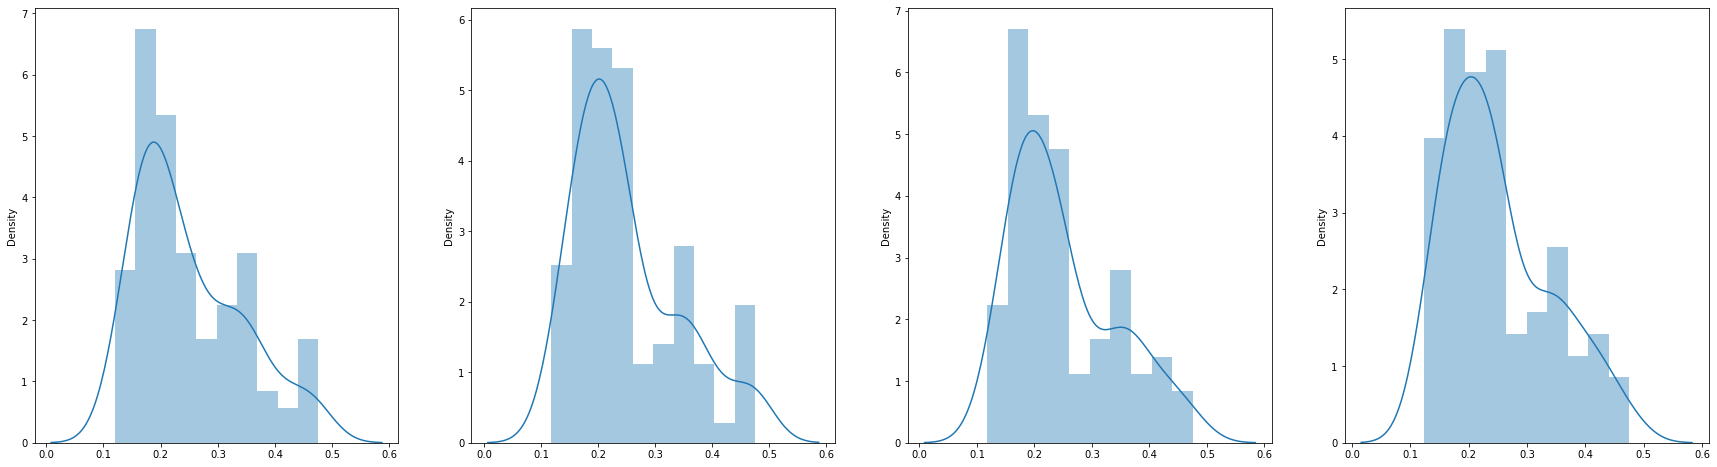

0 AGG 0.08142157191353054 0.2353125260770321
1 SPLG 0.1063478368703056 0.2621543791145086
2 VEU 0.09779867412456643 0.26227297604084016
3 VNQ 0.09009389902022373 0.24026012264192104


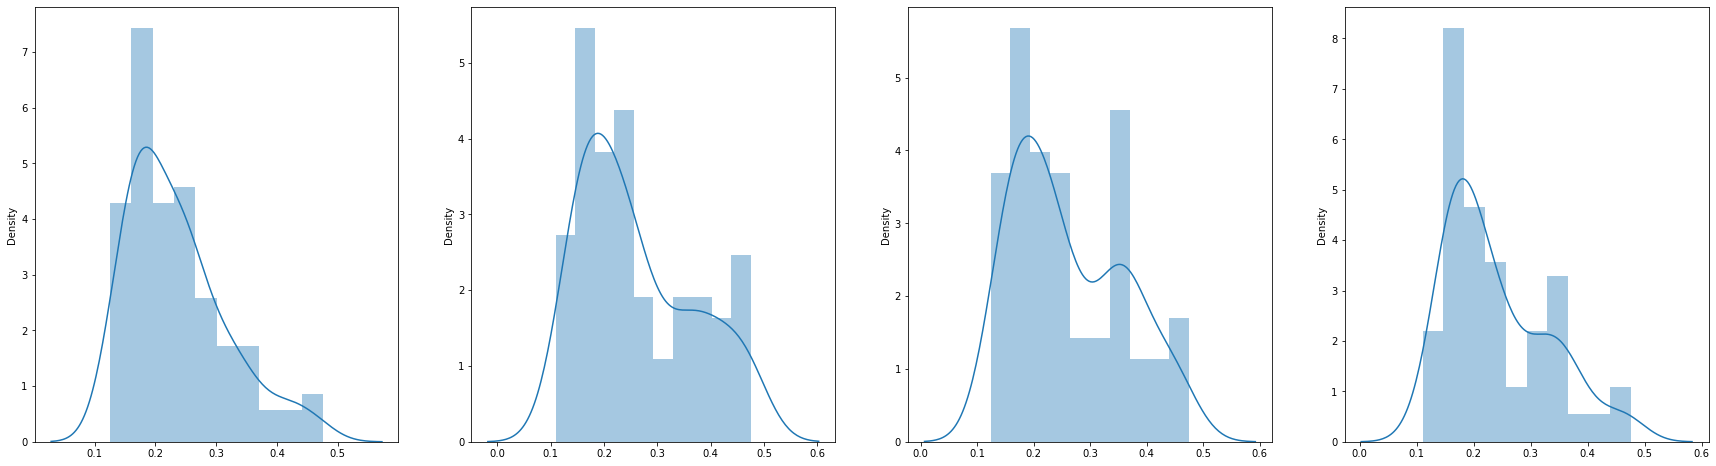

old_etfs: ['SPLG', 'VEU', 'VNQ', 'AGG']
detect [['2016-09-27', 'SPLG', 0.1063478368703056, 0.2621543791145086], ['2017-01-17', 'VNQ', 0.10636800968102936, 0.25967226818203926], ['2017-12-04', 'VEU', 0.10742603863100611, 0.25347593635320664], ['2018-07-17', 'VEU', 0.107168745542204, 0.26861538231372833], ['2018-12-03', 'SPLG', 0.10804535053067779, 0.26196648605167866], ['2019-03-14', 'AGG', 0.10766324927374883, 0.27322369657456874], ['2019-06-10', 'VNQ', 0.10747575110327523, 0.2815430952608585]]
ITOT ['SPLG', 'VEU', 'VNQ', 'AGG']
ITOTnot in comb
['ITOT', 'VEU', 'VNQ', 'AGG']
2016-08-02 2016-09-27
abc ok
['ITOT', 'VEU', 'VNQ', 'AGG']
abc ok
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[****

begin_total_asset:1000000
end_total_asset:1840358.7115580495
Sharpe:  0.6073479626760515
hit end!
43
begin_total_asset:1000000
end_total_asset:1639959.93146151
Sharpe:  0.5147784023878119
hit end!
44
begin_total_asset:1000000
end_total_asset:1783749.8848335657
Sharpe:  0.5791378561253778
hit end!
45
begin_total_asset:1000000
end_total_asset:1686922.3375646416
Sharpe:  0.5416275808353415
hit end!
46
begin_total_asset:1000000
end_total_asset:2073997.966337088
Sharpe:  0.7218305082386149
hit end!
47
begin_total_asset:1000000
end_total_asset:1587132.5851925875
Sharpe:  0.48799009064558546
hit end!
48
begin_total_asset:1000000
end_total_asset:1843429.0368868886
Sharpe:  0.6073511284193991
hit end!
49
begin_total_asset:1000000
end_total_asset:1705044.9551402037
Sharpe:  0.5488678425378636
hit end!
50
begin_total_asset:1000000
end_total_asset:1835038.0881563863
Sharpe:  0.607775294996289
hit end!
51
begin_total_asset:1000000
end_total_asset:1849182.3932238433
Sharpe:  0.6133774325616388
hit e

begin_total_asset:1000000
end_total_asset:1837477.723540171
Sharpe:  0.6101599266273411
hit end!
92
begin_total_asset:1000000
end_total_asset:1685777.8719384142
Sharpe:  0.5376016354789945
hit end!
93
begin_total_asset:1000000
end_total_asset:1863536.0700577889
Sharpe:  0.6247161512660342
hit end!
94
begin_total_asset:1000000
end_total_asset:1621229.4158117934
Sharpe:  0.5058204395578361
hit end!
95
begin_total_asset:1000000
end_total_asset:1871052.615344152
Sharpe:  0.6174891802129868
hit end!
96
begin_total_asset:1000000
end_total_asset:1764261.8153832222
Sharpe:  0.57746612668365
hit end!
97
begin_total_asset:1000000
end_total_asset:1685999.7354666223
Sharpe:  0.533950480863073
hit end!
98
begin_total_asset:1000000
end_total_asset:2036769.310906544
Sharpe:  0.6912241616210345
hit end!
99
begin_total_asset:1000000
end_total_asset:1805535.805419806
Sharpe:  0.5983209773865162
hit end!
thresh= 0.10618162578582915
0
begin_total_asset:1000000
end_total_asset:1381377.5682516224
Sharpe:  0

begin_total_asset:1000000
end_total_asset:1357432.4283753305
Sharpe:  0.492938235765292
hit end!
41
begin_total_asset:1000000
end_total_asset:1442480.6530036894
Sharpe:  0.583909137801672
hit end!
42
begin_total_asset:1000000
end_total_asset:1379689.2216236198
Sharpe:  0.5174594387545709
hit end!
43
begin_total_asset:1000000
end_total_asset:1317660.6435904647
Sharpe:  0.4609402447234118
hit end!
44
begin_total_asset:1000000
end_total_asset:1262836.2183784149
Sharpe:  0.39285525149754047
hit end!
45
begin_total_asset:1000000
end_total_asset:1400731.2441864193
Sharpe:  0.5462494011111179
hit end!
46
begin_total_asset:1000000
end_total_asset:1407728.627890059
Sharpe:  0.551429626505338
hit end!
47
begin_total_asset:1000000
end_total_asset:1360194.5193270966
Sharpe:  0.4964911366838623
hit end!
48
begin_total_asset:1000000
end_total_asset:1303930.3701734452
Sharpe:  0.444141960294843
hit end!
49
begin_total_asset:1000000
end_total_asset:1254242.597591182
Sharpe:  0.38805408975271183
hit en

begin_total_asset:1000000
end_total_asset:1366378.0470502204
Sharpe:  0.5028909760899383
hit end!
90
begin_total_asset:1000000
end_total_asset:1409976.7083248424
Sharpe:  0.5632378741056961
hit end!
91
begin_total_asset:1000000
end_total_asset:1392714.0073568479
Sharpe:  0.5445859566540915
hit end!
92
begin_total_asset:1000000
end_total_asset:1459203.5643470641
Sharpe:  0.5948824007671407
hit end!
93
begin_total_asset:1000000
end_total_asset:1308628.3548077869
Sharpe:  0.456137977776116
hit end!
94
begin_total_asset:1000000
end_total_asset:1439919.9658301293
Sharpe:  0.5889030657213131
hit end!
95
begin_total_asset:1000000
end_total_asset:1433962.2948954096
Sharpe:  0.5818889144346917
hit end!
96
begin_total_asset:1000000
end_total_asset:1409387.8002692035
Sharpe:  0.5497433146094081
hit end!
97
begin_total_asset:1000000
end_total_asset:1412402.152990473
Sharpe:  0.557447724478249
hit end!
98
begin_total_asset:1000000
end_total_asset:1324452.8749887233
Sharpe:  0.46318367314017966
hit 

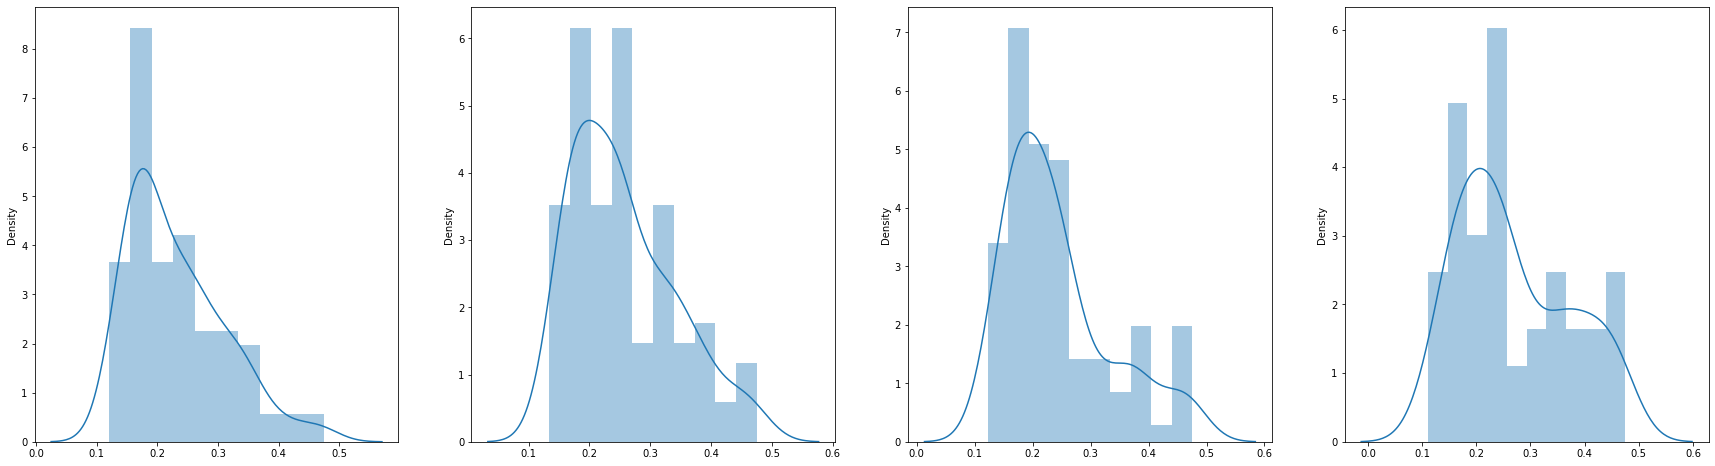

0 AGG 0.0867438780651632 0.23866385601460935
1 ITOT 0.09404740954518508 0.25529886581003663
2 VEU 0.08178500792296584 0.2409798187017441
3 VNQ 0.10792300125950459 0.2650574654340744


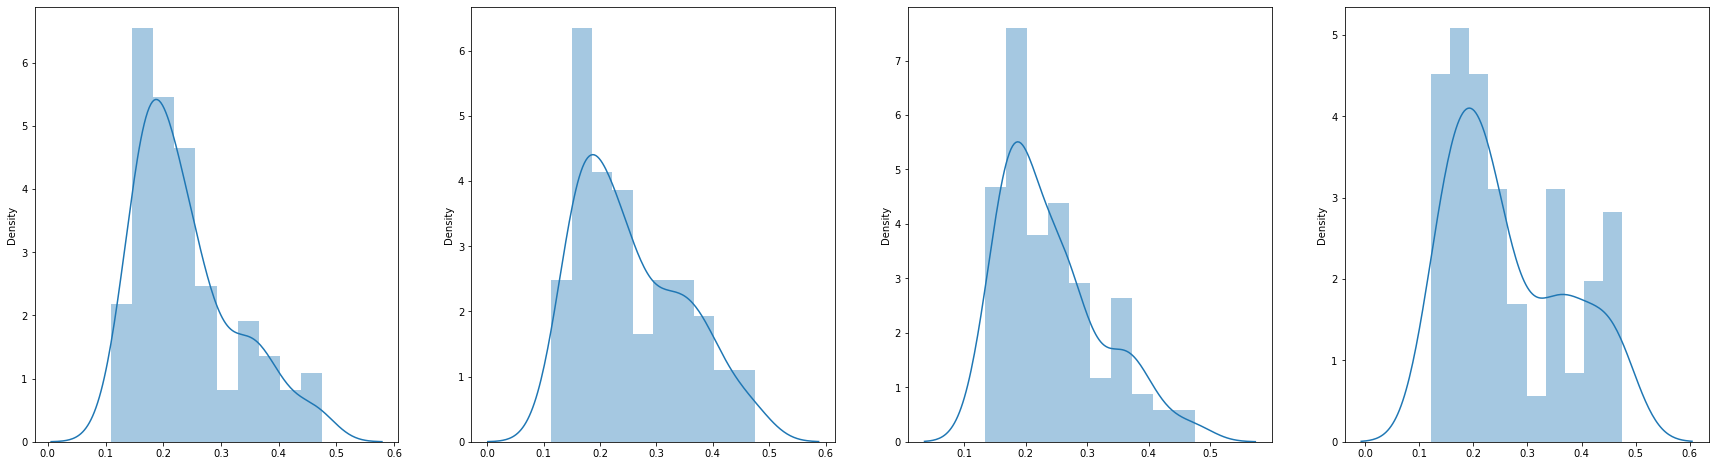

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2016-10-05', 'VNQ', 0.10792300125950456, 0.2650574654340744], ['2018-01-26', 'VNQ', 0.10625222407265629, 0.2673087747395039], ['2018-05-08', 'VNQ', 0.10619989465995897, 0.26004777699708936], ['2018-12-04', 'ITOT', 0.11081763002764719, 0.2746745704859495], ['2019-03-14', 'ITOT', 0.10794121545239675, 0.25533741869032384], ['2019-09-17', 'VNQ', 0.10694625977227053, 0.2755454479902983], ['2020-09-28', 'VEU', 0.1067578760300534, 0.25869628831744196]]
['ITOT', 'VEU', 'IWR', 'AGG']
abc ok
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully ad

begin_total_asset:1000000
end_total_asset:1713113.4622027634
Sharpe:  0.5949375631498209
hit end!
44
begin_total_asset:1000000
end_total_asset:1735830.833079014
Sharpe:  0.6131107338296004
hit end!
45
begin_total_asset:1000000
end_total_asset:1913381.413983893
Sharpe:  0.7140946721310713
hit end!
46
begin_total_asset:1000000
end_total_asset:1785394.91763876
Sharpe:  0.6407882086198167
hit end!
47
begin_total_asset:1000000
end_total_asset:1698770.8130511066
Sharpe:  0.5885939096336732
hit end!
48
begin_total_asset:1000000
end_total_asset:1844138.0140785577
Sharpe:  0.6776047909918237
hit end!
49
begin_total_asset:1000000
end_total_asset:1753163.9618366174
Sharpe:  0.6290992468165673
hit end!
50
begin_total_asset:1000000
end_total_asset:1770684.4107475528
Sharpe:  0.6410681009918219
hit end!
51
begin_total_asset:1000000
end_total_asset:1870212.5405596963
Sharpe:  0.6826318345456667
hit end!
52
begin_total_asset:1000000
end_total_asset:1752808.173538437
Sharpe:  0.6299680410090011
hit end

begin_total_asset:1000000
end_total_asset:1758705.9594237152
Sharpe:  0.6279025893379441
hit end!
93
begin_total_asset:1000000
end_total_asset:1844771.5123690467
Sharpe:  0.6657033216020627
hit end!
94
begin_total_asset:1000000
end_total_asset:1742435.6622936416
Sharpe:  0.6150248936059541
hit end!
95
begin_total_asset:1000000
end_total_asset:1738640.857520287
Sharpe:  0.6142593745270869
hit end!
96
begin_total_asset:1000000
end_total_asset:1670601.2293687202
Sharpe:  0.5739083533106006
hit end!
97
begin_total_asset:1000000
end_total_asset:1775125.5440403908
Sharpe:  0.6368698422148821
hit end!
98
begin_total_asset:1000000
end_total_asset:1605852.4195415934
Sharpe:  0.5330159500873778
hit end!
99
begin_total_asset:1000000
end_total_asset:1925081.7301602496
Sharpe:  0.7086236407435907
hit end!
thresh= 0.10614818500021228
0
begin_total_asset:1000000
end_total_asset:1613651.4060142385
Sharpe:  0.7374270563448966
hit end!
1
begin_total_asset:1000000
end_total_asset:1581679.2955978694
Sharp

begin_total_asset:1000000
end_total_asset:1675770.2597177147
Sharpe:  0.7746341617778773
hit end!
42
begin_total_asset:1000000
end_total_asset:1544943.6357617797
Sharpe:  0.6867829486711019
hit end!
43
begin_total_asset:1000000
end_total_asset:1476478.153520097
Sharpe:  0.6097161763693845
hit end!
44
begin_total_asset:1000000
end_total_asset:1479179.0885361265
Sharpe:  0.6259195615115153
hit end!
45
begin_total_asset:1000000
end_total_asset:1538397.1442460269
Sharpe:  0.6565004821164371
hit end!
46
begin_total_asset:1000000
end_total_asset:1472466.8486878492
Sharpe:  0.6140949760723025
hit end!
47
begin_total_asset:1000000
end_total_asset:1470667.01111518
Sharpe:  0.6070228692385393
hit end!
48
begin_total_asset:1000000
end_total_asset:1450858.3405049485
Sharpe:  0.5917960151223229
hit end!
49
begin_total_asset:1000000
end_total_asset:1656011.1992726435
Sharpe:  0.7597420185097514
hit end!
50
begin_total_asset:1000000
end_total_asset:1470048.3025079973
Sharpe:  0.5999436819099061
hit e

begin_total_asset:1000000
end_total_asset:1484033.9403416682
Sharpe:  0.6141535649915795
hit end!
91
begin_total_asset:1000000
end_total_asset:1457514.2837823443
Sharpe:  0.5988820241631583
hit end!
92
begin_total_asset:1000000
end_total_asset:1442908.0496335141
Sharpe:  0.5828089154295509
hit end!
93
begin_total_asset:1000000
end_total_asset:1603875.0968803947
Sharpe:  0.7220537903942136
hit end!
94
begin_total_asset:1000000
end_total_asset:1398536.0490053876
Sharpe:  0.5340442162452653
hit end!
95
begin_total_asset:1000000
end_total_asset:1614150.6523451584
Sharpe:  0.7420812822689776
hit end!
96
begin_total_asset:1000000
end_total_asset:1537513.351253379
Sharpe:  0.6724597722048906
hit end!
97
begin_total_asset:1000000
end_total_asset:1453795.409580574
Sharpe:  0.591613523639688
hit end!
98
begin_total_asset:1000000
end_total_asset:1429771.7044195298
Sharpe:  0.5679874412438729
hit end!
99
begin_total_asset:1000000
end_total_asset:1509027.9200670233
Sharpe:  0.6437105420916407
hit e

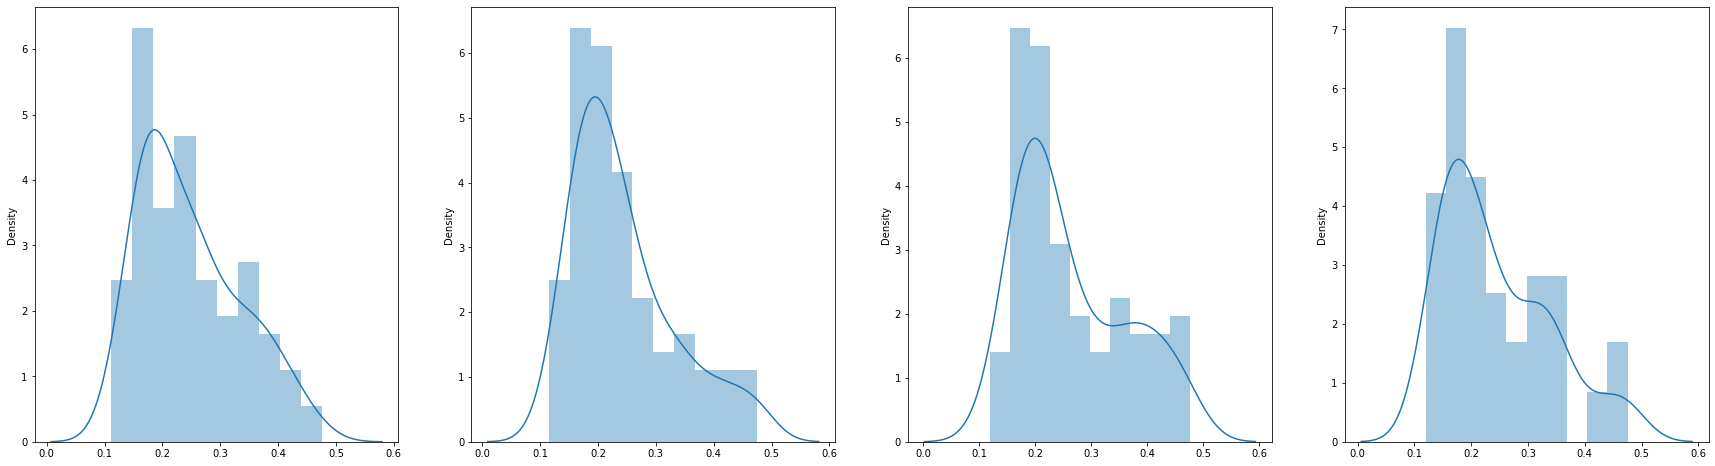

0 AGG 0.09885724519550737 0.24614127054810525
1 ITOT 0.0793251647103388 0.2415798307955265
2 IWR 0.10630439965255963 0.27131277568638323
3 VEU 0.0848496611294426 0.24096612229943276


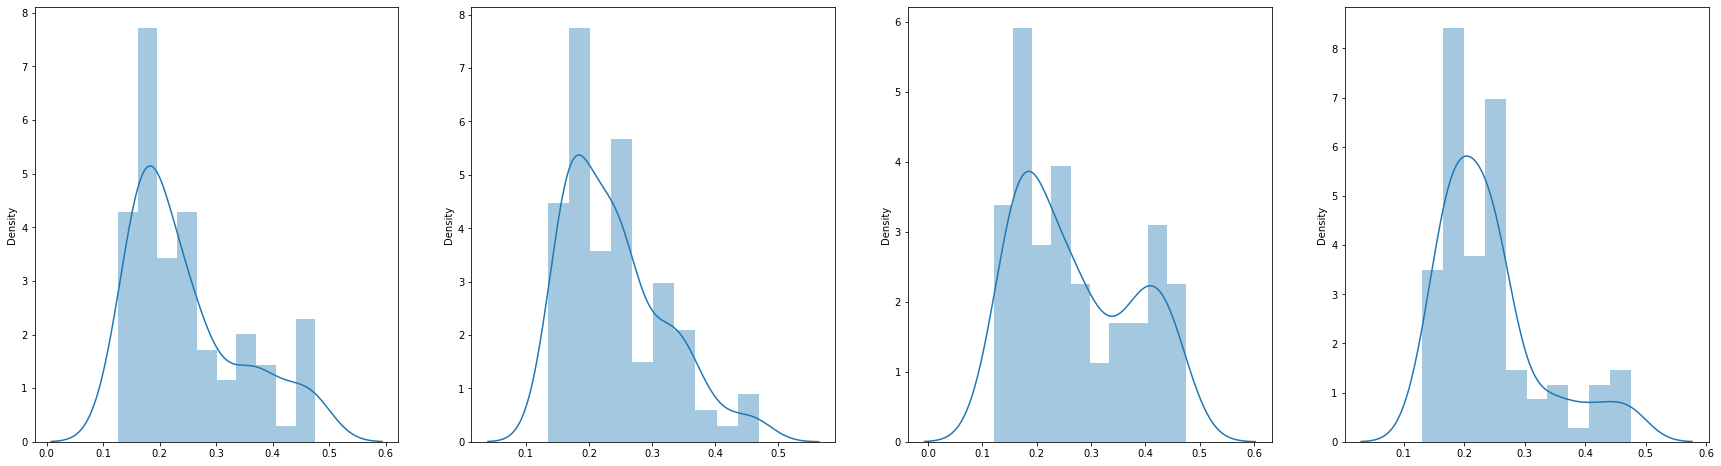

old_etfs: ['ITOT', 'VEU', 'IWR', 'AGG']
detect [['2016-02-22', 'IWR', 0.10614920223630545, 0.26786573968827726], ['2016-03-21', 'ITOT', 0.10787405373098533, 0.2791751927137375], ['2017-02-13', 'IWR', 0.10630439965255961, 0.27131277568638323], ['2017-03-01', 'IWR', 0.10741161589283528, 0.26666067153215406], ['2017-03-03', 'VEU', 0.10753869888693472, 0.26345494598150254], ['2017-06-20', 'ITOT', 0.10620118242898158, 0.27091469496488574], ['2017-10-23', 'ITOT', 0.10792382561260502, 0.27034482277929783], ['2017-10-31', 'AGG', 0.10799661837403787, 0.2673543866723776], ['2017-12-05', 'AGG', 0.10722139669531545, 0.2572587414830923], ['2018-01-24', 'AGG', 0.10655813965541984, 0.27752675727009773], ['2018-04-11', 'VEU', 0.10760472460355369, 0.2665356672555208], ['2018-04-13', 'AGG', 0.10858405603543757, 0.2603534995764494], ['2018-08-20', 'ITOT', 0.1069666821130331, 0.2660278183221817], ['2018-10-01', 'ITOT', 0.1076696290024713, 0.26713922575116156], ['2019-05-14', 'IWR', 0.10752761711587534, 0.

begin_total_asset:1000000
end_total_asset:1744058.8783413374
Sharpe:  0.5495765124627189
hit end!
38
begin_total_asset:1000000
end_total_asset:1534575.8789342914
Sharpe:  0.45018166594125
hit end!
39
begin_total_asset:1000000
end_total_asset:1742264.2142302906
Sharpe:  0.5608484179491668
hit end!
40
begin_total_asset:1000000
end_total_asset:1769992.4259063974
Sharpe:  0.5725271209515483
hit end!
41
begin_total_asset:1000000
end_total_asset:1701528.116505098
Sharpe:  0.5421597923700975
hit end!
42
begin_total_asset:1000000
end_total_asset:1572793.2888796057
Sharpe:  0.4750536286277613
hit end!
43
begin_total_asset:1000000
end_total_asset:1645654.663692259
Sharpe:  0.5090596255038743
hit end!
44
begin_total_asset:1000000
end_total_asset:1733814.1169898242
Sharpe:  0.5599878202301168
hit end!
45
begin_total_asset:1000000
end_total_asset:1575659.5946050237
Sharpe:  0.4776490282337083
hit end!
46
begin_total_asset:1000000
end_total_asset:1819076.38766077
Sharpe:  0.5989842793008056
hit end!

begin_total_asset:1000000
end_total_asset:1518020.5952327962
Sharpe:  0.4490276493337754
hit end!
87
begin_total_asset:1000000
end_total_asset:1677771.9253338776
Sharpe:  0.5288612445607577
hit end!
88
begin_total_asset:1000000
end_total_asset:2080316.2592522285
Sharpe:  0.7183203313596421
hit end!
89
begin_total_asset:1000000
end_total_asset:1616797.563699076
Sharpe:  0.4973485547276209
hit end!
90
begin_total_asset:1000000
end_total_asset:1608837.1836461923
Sharpe:  0.4956529542939072
hit end!
91
begin_total_asset:1000000
end_total_asset:1658593.9721595822
Sharpe:  0.5211921458138448
hit end!
92
begin_total_asset:1000000
end_total_asset:1787166.9704830693
Sharpe:  0.5821739816511549
hit end!
93
begin_total_asset:1000000
end_total_asset:1848958.8617230102
Sharpe:  0.6161831785835893
hit end!
94
begin_total_asset:1000000
end_total_asset:1710074.1260327385
Sharpe:  0.5413924875513679
hit end!
95
begin_total_asset:1000000
end_total_asset:1872243.9253596659
Sharpe:  0.627311979110937
hit 

begin_total_asset:1000000
end_total_asset:1398495.713347683
Sharpe:  0.5379898586764604
hit end!
36
begin_total_asset:1000000
end_total_asset:1399522.052521977
Sharpe:  0.5361962021816432
hit end!
37
begin_total_asset:1000000
end_total_asset:1460999.5115815592
Sharpe:  0.6091598785807188
hit end!
38
begin_total_asset:1000000
end_total_asset:1259389.9839733094
Sharpe:  0.38788334592172935
hit end!
39
begin_total_asset:1000000
end_total_asset:1361717.8909480267
Sharpe:  0.501033085271176
hit end!
40
begin_total_asset:1000000
end_total_asset:1333446.8055610948
Sharpe:  0.47529269224528453
hit end!
41
begin_total_asset:1000000
end_total_asset:1404407.8768962722
Sharpe:  0.5443694142872908
hit end!
42
begin_total_asset:1000000
end_total_asset:1274896.2161580196
Sharpe:  0.40817719956320514
hit end!
43
begin_total_asset:1000000
end_total_asset:1272758.2309518962
Sharpe:  0.40188728765100906
hit end!
44
begin_total_asset:1000000
end_total_asset:1324222.380752362
Sharpe:  0.4598514370398338
hi

begin_total_asset:1000000
end_total_asset:1308164.1067470564
Sharpe:  0.4383174490781501
hit end!
85
begin_total_asset:1000000
end_total_asset:1361151.3257602728
Sharpe:  0.5141875287156553
hit end!
86
begin_total_asset:1000000
end_total_asset:1367959.0067665647
Sharpe:  0.5129304909335909
hit end!
87
begin_total_asset:1000000
end_total_asset:1350279.265056553
Sharpe:  0.49087187109619795
hit end!
88
begin_total_asset:1000000
end_total_asset:1377473.8150568039
Sharpe:  0.5167171843695544
hit end!
89
begin_total_asset:1000000
end_total_asset:1225125.4941974205
Sharpe:  0.3545753701122159
hit end!
90
begin_total_asset:1000000
end_total_asset:1324735.9661307235
Sharpe:  0.4681994641600923
hit end!
91
begin_total_asset:1000000
end_total_asset:1424597.9644419355
Sharpe:  0.5717327224142427
hit end!
92
begin_total_asset:1000000
end_total_asset:1328836.0803233015
Sharpe:  0.4822301416095843
hit end!
93
begin_total_asset:1000000
end_total_asset:1407116.5464866008
Sharpe:  0.5571425941811644
hi

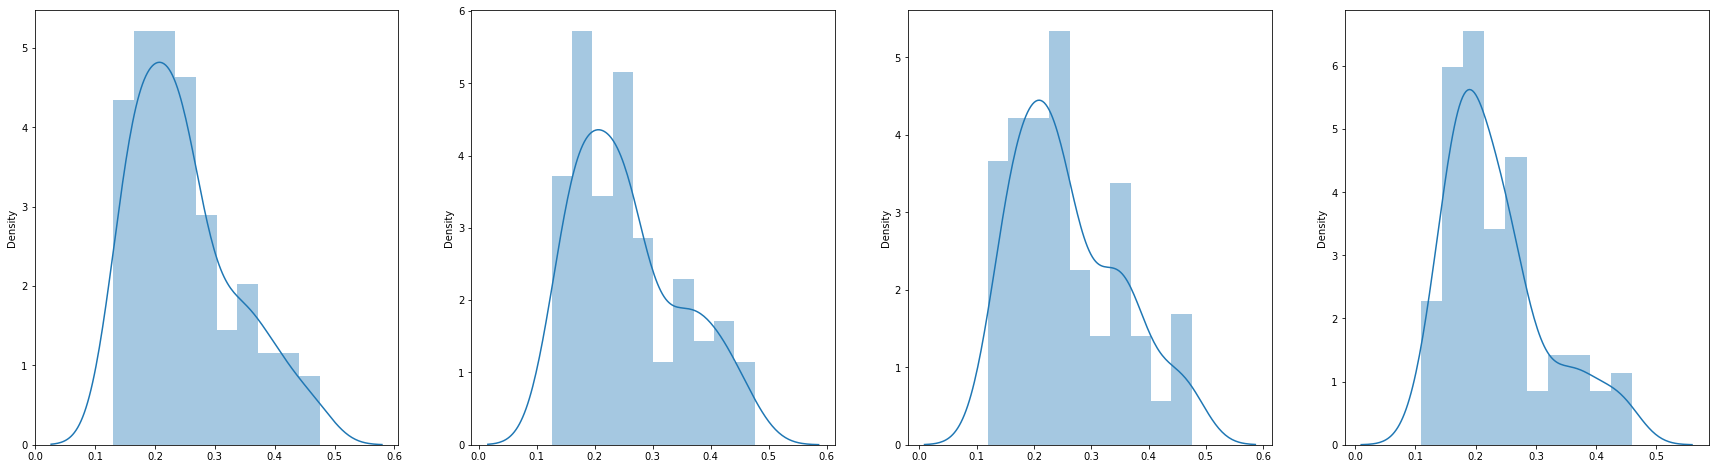

0 AGG 0.08530354766543498 0.24288693778216838
1 ITOT 0.0947908868126741 0.24460444353520872
2 VEU 0.08196061260420347 0.24441922552883624
3 VNQ 0.10816346515607671 0.26808939076960087


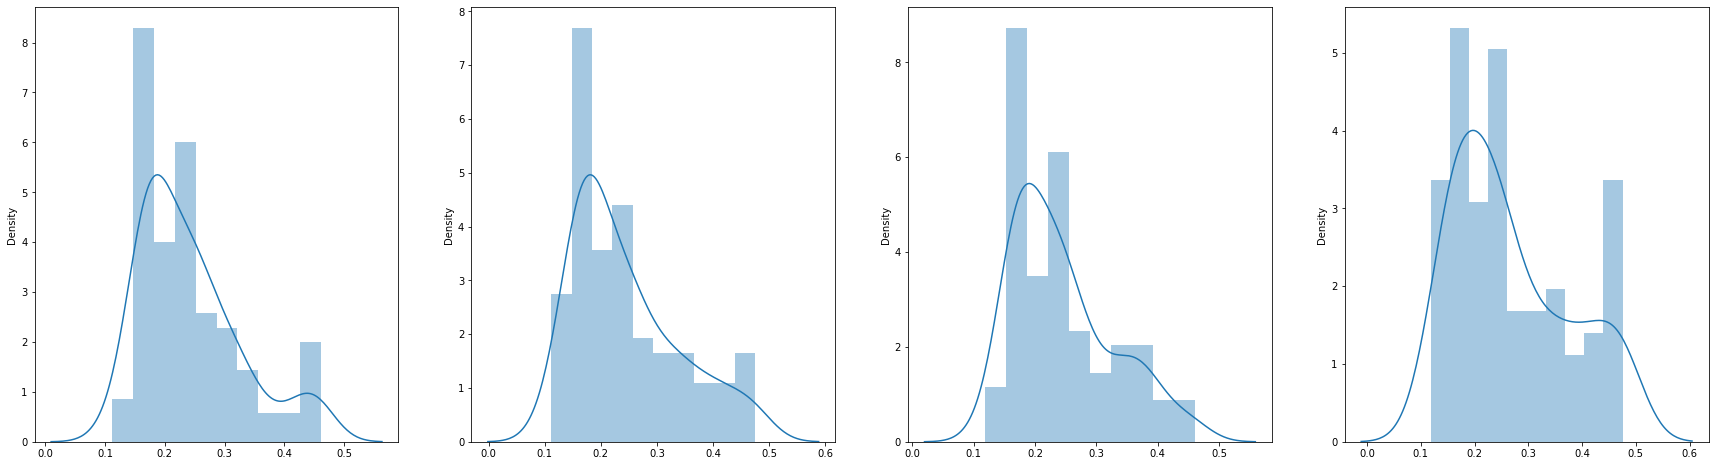

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2016-01-15', 'AGG', 0.10754665036016586, 0.2748328108340502], ['2016-06-20', 'ITOT', 0.10619503755007528, 0.2582329076528549], ['2016-10-24', 'VNQ', 0.10816346515607672, 0.26808939076960087], ['2016-12-05', 'VEU', 0.10819733805191285, 0.26422240264713764], ['2017-03-16', 'VEU', 0.10831295894502087, 0.27004335187375544], ['2017-09-13', 'AGG', 0.10780031768133247, 0.25810856342315674], ['2017-11-10', 'AGG', 0.1076829961810172, 0.2625280013680458], ['2017-11-24', 'VNQ', 0.10737001247411039, 0.2716461440175772], ['2018-06-20', 'VEU', 0.10918883597560342, 0.26938482068479064], ['2018-11-07', 'ITOT', 0.10643721259286419, 0.2730631843954325], ['2018-12-14', 'ITOT', 0.1063455420786585, 0.270460911989212], ['2019-06-25', 'VEU', 0.10853977188906207, 0.26453119970858097], ['2019-06-25', 'VNQ', 0.10616949483015706, 0.2503516808897257], ['2019-08-06', 'AGG', 0.10814648555795772, 0.25450934246182444], ['2019-09-27', 'ITOT', 0.10675630957791081, 0.264

begin_total_asset:1000000
end_total_asset:1322270.556761262
Sharpe:  0.34975890122353004
hit end!
16
begin_total_asset:1000000
end_total_asset:1446948.5898606568
Sharpe:  0.4400545662789117
hit end!
17
begin_total_asset:1000000
end_total_asset:1310832.0778132419
Sharpe:  0.34745639210096874
hit end!
18
begin_total_asset:1000000
end_total_asset:1314925.5160806212
Sharpe:  0.34578790892875333
hit end!
19
begin_total_asset:1000000
end_total_asset:1255477.603547266
Sharpe:  0.2970822536169998
hit end!
20
begin_total_asset:1000000
end_total_asset:1460485.353225578
Sharpe:  0.449937516973271
hit end!
21
begin_total_asset:1000000
end_total_asset:1244364.031884243
Sharpe:  0.2918401696676659
hit end!
22
begin_total_asset:1000000
end_total_asset:1388965.9915578726
Sharpe:  0.4019285840235324
hit end!
23
begin_total_asset:1000000
end_total_asset:1467304.332058497
Sharpe:  0.4565574483322543
hit end!
24
begin_total_asset:1000000
end_total_asset:1360056.3775143318
Sharpe:  0.3769280575029444
hit e

begin_total_asset:1000000
end_total_asset:1230619.03956792
Sharpe:  0.2806315914575439
hit end!
65
begin_total_asset:1000000
end_total_asset:1369170.654155341
Sharpe:  0.3856562817958373
hit end!
66
begin_total_asset:1000000
end_total_asset:1398607.133200105
Sharpe:  0.40787022557968394
hit end!
67
begin_total_asset:1000000
end_total_asset:1432457.3437821523
Sharpe:  0.433730390901652
hit end!
68
begin_total_asset:1000000
end_total_asset:1403175.6507105727
Sharpe:  0.4087805907716171
hit end!
69
begin_total_asset:1000000
end_total_asset:1421177.2753703694
Sharpe:  0.42268251847007654
hit end!
70
begin_total_asset:1000000
end_total_asset:1548902.2113966432
Sharpe:  0.5172611801094467
hit end!
71
begin_total_asset:1000000
end_total_asset:1281652.084357539
Sharpe:  0.32140735072050197
hit end!
72
begin_total_asset:1000000
end_total_asset:1335012.0835709574
Sharpe:  0.36138311264377415
hit end!
73
begin_total_asset:1000000
end_total_asset:1322483.3367408877
Sharpe:  0.3523253184923984
hit 

begin_total_asset:1000000
end_total_asset:1511882.6395397705
Sharpe:  0.770100429604629
hit end!
14
begin_total_asset:1000000
end_total_asset:1472096.5951719105
Sharpe:  0.7210331941785049
hit end!
15
begin_total_asset:1000000
end_total_asset:1504321.1857653197
Sharpe:  0.7492883467272641
hit end!
16
begin_total_asset:1000000
end_total_asset:1445123.0289625467
Sharpe:  0.7075556310201082
hit end!
17
begin_total_asset:1000000
end_total_asset:1574836.8414562354
Sharpe:  0.8358073243112485
hit end!
18
begin_total_asset:1000000
end_total_asset:1533674.9122122992
Sharpe:  0.7969457072782385
hit end!
19
begin_total_asset:1000000
end_total_asset:1531064.9869569775
Sharpe:  0.7864996161732066
hit end!
20
begin_total_asset:1000000
end_total_asset:1489645.230382885
Sharpe:  0.7294508885407456
hit end!
21
begin_total_asset:1000000
end_total_asset:1529004.0287342875
Sharpe:  0.7830695794742608
hit end!
22
begin_total_asset:1000000
end_total_asset:1453161.3690642626
Sharpe:  0.7016022611982622
hit 

begin_total_asset:1000000
end_total_asset:1360281.81863537
Sharpe:  0.5921693902836049
hit end!
63
begin_total_asset:1000000
end_total_asset:1524275.4378298246
Sharpe:  0.7677105288747681
hit end!
64
begin_total_asset:1000000
end_total_asset:1497581.327958747
Sharpe:  0.736276100225103
hit end!
65
begin_total_asset:1000000
end_total_asset:1531513.80705828
Sharpe:  0.769045390512377
hit end!
66
begin_total_asset:1000000
end_total_asset:1488465.0087386998
Sharpe:  0.7414898837227207
hit end!
67
begin_total_asset:1000000
end_total_asset:1536405.4834224158
Sharpe:  0.787423623149017
hit end!
68
begin_total_asset:1000000
end_total_asset:1505445.144418203
Sharpe:  0.7621605398479815
hit end!
69
begin_total_asset:1000000
end_total_asset:1613103.4275305858
Sharpe:  0.9061036181683536
hit end!
70
begin_total_asset:1000000
end_total_asset:1446621.838035544
Sharpe:  0.7004808098405559
hit end!
71
begin_total_asset:1000000
end_total_asset:1557009.106020709
Sharpe:  0.8277984827004968
hit end!
72
b

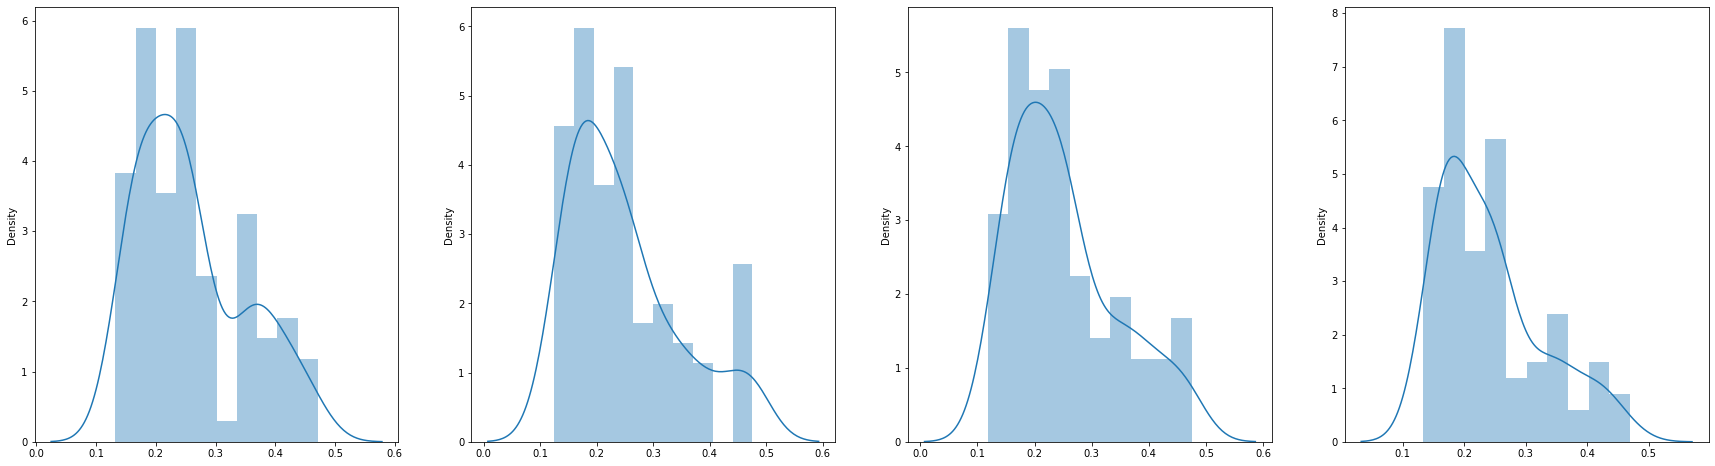

0 AGG 0.10678952818287224 0.26133169412612917
1 DBB 0.09494584565539187 0.2468431395292282
2 ITOT 0.09592489766882233 0.2550781573355198
3 VEU 0.09487778481524396 0.2367470098286867


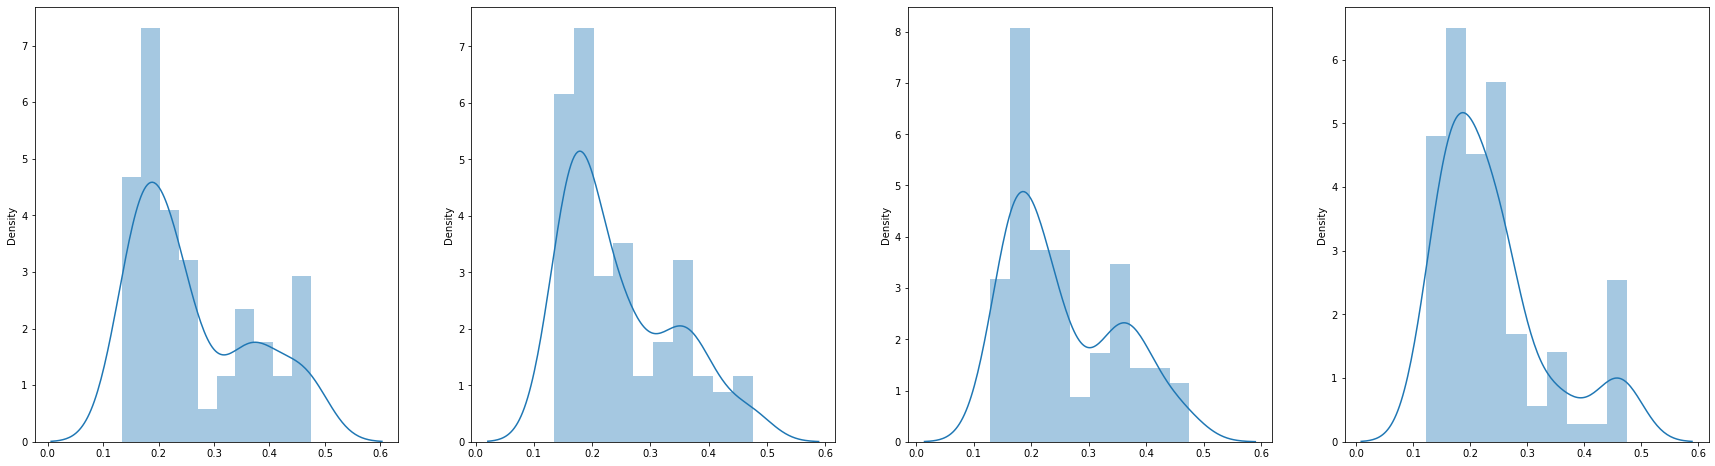

old_etfs: ['ITOT', 'VEU', 'DBB', 'AGG']
detect [['2016-06-02', 'ITOT', 0.11005377098947143, 0.2593807858973742], ['2016-06-14', 'AGG', 0.11132680855068836, 0.27222764618694784], ['2017-10-11', 'AGG', 0.10678952818287227, 0.26133169412612917], ['2017-11-20', 'DBB', 0.10643219080491674, 0.26667843595147134], ['2018-03-22', 'ITOT', 0.11105040609856323, 0.27616825826466085], ['2018-03-23', 'DBB', 0.10654570040093882, 0.2526925114542246], ['2018-04-10', 'AGG', 0.1091724183226331, 0.2567219177633524], ['2019-05-30', 'ITOT', 0.1106348172052363, 0.26103982634842393], ['2019-08-15', 'VEU', 0.10897689386659433, 0.2629432585090399], ['2020-02-12', 'DBB', 0.10724165843860999, 0.26095825649797916], ['2020-09-29', 'ITOT', 0.10662761190499974, 0.25066279858350754]]
ITOT ['ITOT', 'VEU', 'DBB', 'AGG']
VEU ['ITOT', 'VEU', 'DBB', 'AGG']
VNQ ['ITOT', 'VEU', 'DBB', 'AGG']
VNQnot in comb
['ITOT', 'VEU', 'VNQ', 'AGG']
2016-10-25 2017-10-11
abc ok
['ITOT', 'VEU', 'VNQ', 'AGG']
abc ok
[*********************100

begin_total_asset:1000000
end_total_asset:1685216.6231336389
Sharpe:  0.5329997851825257
hit end!
41
begin_total_asset:1000000
end_total_asset:1739205.1479683127
Sharpe:  0.5591049813461544
hit end!
42
begin_total_asset:1000000
end_total_asset:1701735.3611328893
Sharpe:  0.545090246394803
hit end!
43
begin_total_asset:1000000
end_total_asset:1905908.5091305529
Sharpe:  0.6478049351171211
hit end!
44
begin_total_asset:1000000
end_total_asset:1889828.2549246678
Sharpe:  0.6218979488313544
hit end!
45
begin_total_asset:1000000
end_total_asset:1804440.9878561096
Sharpe:  0.5907552165093443
hit end!
46
begin_total_asset:1000000
end_total_asset:1575676.6926986843
Sharpe:  0.4725125132277113
hit end!
47
begin_total_asset:1000000
end_total_asset:1778674.0425715523
Sharpe:  0.5798203972346027
hit end!
48
begin_total_asset:1000000
end_total_asset:1831219.4547068002
Sharpe:  0.6010505574165813
hit end!
49
begin_total_asset:1000000
end_total_asset:1641406.18627109
Sharpe:  0.5178053416942673
hit e

begin_total_asset:1000000
end_total_asset:1814273.8664878374
Sharpe:  0.6050727088389144
hit end!
90
begin_total_asset:1000000
end_total_asset:1705361.5705860434
Sharpe:  0.5406696245396976
hit end!
91
begin_total_asset:1000000
end_total_asset:1649625.9505916443
Sharpe:  0.5076921424635606
hit end!
92
begin_total_asset:1000000
end_total_asset:1774860.4618322665
Sharpe:  0.5805564708532757
hit end!
93
begin_total_asset:1000000
end_total_asset:1740667.1564934799
Sharpe:  0.5650833342662605
hit end!
94
begin_total_asset:1000000
end_total_asset:1651634.6554458681
Sharpe:  0.5167748346806879
hit end!
95
begin_total_asset:1000000
end_total_asset:1641298.1254654003
Sharpe:  0.5172411848850884
hit end!
96
begin_total_asset:1000000
end_total_asset:1570073.443900001
Sharpe:  0.46872173845201304
hit end!
97
begin_total_asset:1000000
end_total_asset:1833477.411378944
Sharpe:  0.5987278405748112
hit end!
98
begin_total_asset:1000000
end_total_asset:1662425.334364619
Sharpe:  0.5141409781647136
hit 

begin_total_asset:1000000
end_total_asset:1175729.0581144327
Sharpe:  0.29679728453287535
hit end!
39
begin_total_asset:1000000
end_total_asset:1393218.078444067
Sharpe:  0.529965771266838
hit end!
40
begin_total_asset:1000000
end_total_asset:1349902.561382995
Sharpe:  0.4824388898298995
hit end!
41
begin_total_asset:1000000
end_total_asset:1371991.6287562624
Sharpe:  0.5007585008084137
hit end!
42
begin_total_asset:1000000
end_total_asset:1427992.7550524427
Sharpe:  0.5639475031451832
hit end!
43
begin_total_asset:1000000
end_total_asset:1356981.6950791348
Sharpe:  0.49786022044609046
hit end!
44
begin_total_asset:1000000
end_total_asset:1293341.428922011
Sharpe:  0.4329140471863819
hit end!
45
begin_total_asset:1000000
end_total_asset:1320196.4258829413
Sharpe:  0.46593165324063457
hit end!
46
begin_total_asset:1000000
end_total_asset:1333404.0575084258
Sharpe:  0.47525990877301966
hit end!
47
begin_total_asset:1000000
end_total_asset:1412172.612422573
Sharpe:  0.5522650622312707
hit

begin_total_asset:1000000
end_total_asset:1300085.4947445823
Sharpe:  0.4329583255941546
hit end!
88
begin_total_asset:1000000
end_total_asset:1350478.4563544218
Sharpe:  0.49175795967730507
hit end!
89
begin_total_asset:1000000
end_total_asset:1422415.4612362937
Sharpe:  0.5643647327992191
hit end!
90
begin_total_asset:1000000
end_total_asset:1363719.089744091
Sharpe:  0.5075662712084827
hit end!
91
begin_total_asset:1000000
end_total_asset:1357337.5719906953
Sharpe:  0.5047333593395548
hit end!
92
begin_total_asset:1000000
end_total_asset:1301663.6274115948
Sharpe:  0.4424732126529522
hit end!
93
begin_total_asset:1000000
end_total_asset:1377271.4568774276
Sharpe:  0.5209511958267371
hit end!
94
begin_total_asset:1000000
end_total_asset:1319888.7220221718
Sharpe:  0.4578966334847247
hit end!
95
begin_total_asset:1000000
end_total_asset:1209338.0724172145
Sharpe:  0.3343231520827244
hit end!
96
begin_total_asset:1000000
end_total_asset:1479771.2318515915
Sharpe:  0.6175952947490693
hi

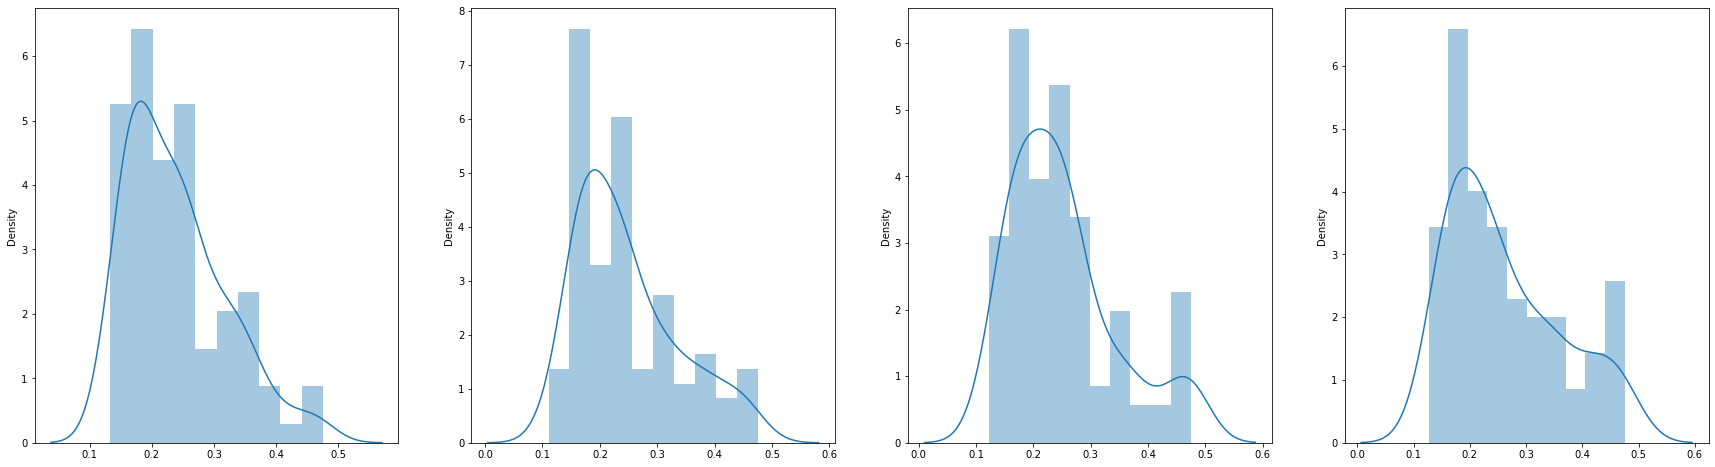

0 AGG 0.08305637784954335 0.24590302512049675
1 ITOT 0.09744338951544192 0.25202000826597215
2 VEU 0.107888273746639 0.26143273778259757
3 VNQ 0.0985844604205602 0.24064422473311425


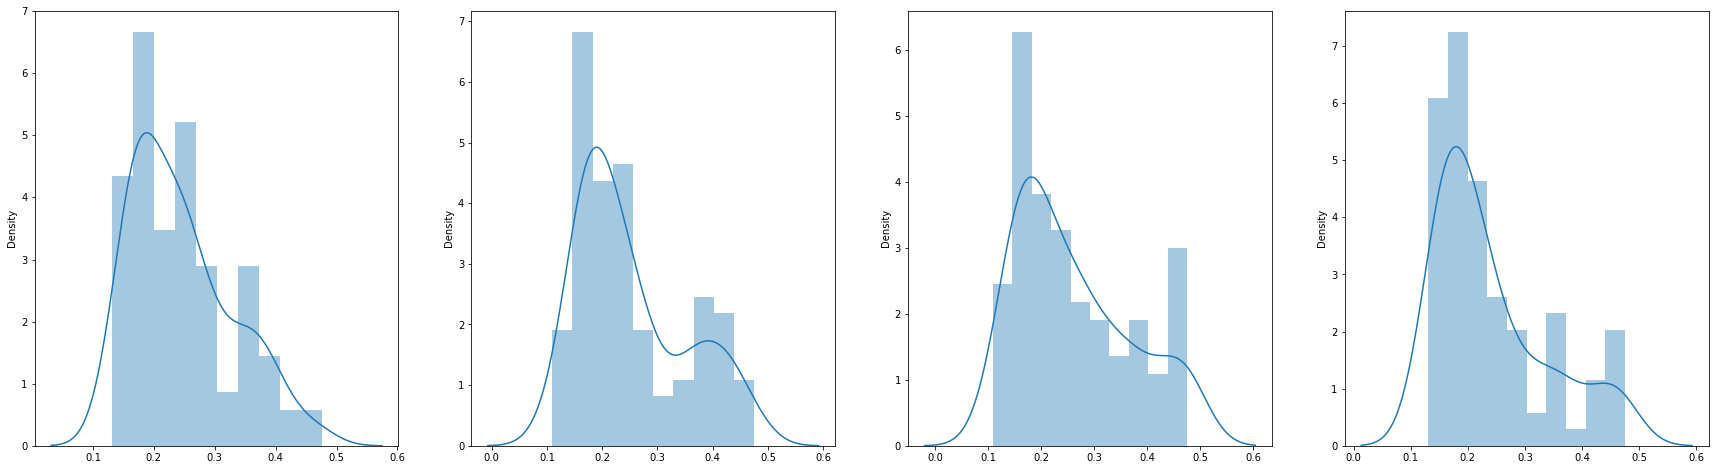

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2017-03-17', 'VEU', 0.107888273746639, 0.26143273778259757], ['2017-03-29', 'ITOT', 0.10628090688110317, 0.2830843216180801], ['2017-05-18', 'VEU', 0.10711662682065612, 0.2618301833420992], ['2017-10-19', 'VNQ', 0.10741270976899332, 0.268968787714839], ['2018-06-14', 'AGG', 0.10663908365934022, 0.26860318407416345], ['2018-07-12', 'VEU', 0.10634814891472785, 0.2579408176243305], ['2018-12-13', 'VEU', 0.10779205409376935, 0.2541337925195694], ['2020-02-28', 'VEU', 0.1068846604790161, 0.25712971061468126], ['2020-04-08', 'VEU', 0.10673443505425674, 0.25598127506673335], ['2020-04-16', 'VEU', 0.10651756447093536, 0.2536712920665741], ['2020-08-05', 'VEU', 0.106455594713649, 0.2717406786978245]]
['ITOT', 'SH', 'VNQ', 'AGG']
['ITOT', 'CDL', 'VNQ', 'AGG']
abc ok
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******************

begin_total_asset:1000000
end_total_asset:2194704.7735210555
Sharpe:  0.7542389131556654
hit end!
36
begin_total_asset:1000000
end_total_asset:1807042.987711543
Sharpe:  0.5842708549653296
hit end!
37
begin_total_asset:1000000
end_total_asset:1761739.021186959
Sharpe:  0.5665847118078493
hit end!
38
begin_total_asset:1000000
end_total_asset:1834524.041258791
Sharpe:  0.597292161495392
hit end!
39
begin_total_asset:1000000
end_total_asset:2084208.8905950123
Sharpe:  0.7141494038964166
hit end!
40
begin_total_asset:1000000
end_total_asset:1974111.1376152139
Sharpe:  0.6646176558013062
hit end!
41
begin_total_asset:1000000
end_total_asset:2077458.6343138635
Sharpe:  0.710590829769794
hit end!
42
begin_total_asset:1000000
end_total_asset:2313795.9144472214
Sharpe:  0.8024842372819271
hit end!
43
begin_total_asset:1000000
end_total_asset:1906948.5413588048
Sharpe:  0.6328725494050631
hit end!
44
begin_total_asset:1000000
end_total_asset:1859479.9248569987
Sharpe:  0.6160655155154827
hit end

begin_total_asset:1000000
end_total_asset:1957588.1892471383
Sharpe:  0.6615502497354645
hit end!
85
begin_total_asset:1000000
end_total_asset:1918864.0232783677
Sharpe:  0.6455819741130324
hit end!
86
begin_total_asset:1000000
end_total_asset:1829495.4710735397
Sharpe:  0.5950382332222016
hit end!
87
begin_total_asset:1000000
end_total_asset:1947648.990345556
Sharpe:  0.6405845933645364
hit end!
88
begin_total_asset:1000000
end_total_asset:2079223.2989594107
Sharpe:  0.7177253571379746
hit end!
89
begin_total_asset:1000000
end_total_asset:1871668.560735102
Sharpe:  0.6207720647770207
hit end!
90
begin_total_asset:1000000
end_total_asset:2017221.2070531675
Sharpe:  0.680530989726032
hit end!
91
begin_total_asset:1000000
end_total_asset:1987976.4653593914
Sharpe:  0.6646882036442777
hit end!
92
begin_total_asset:1000000
end_total_asset:1831025.7297460698
Sharpe:  0.5966109593187418
hit end!
93
begin_total_asset:1000000
end_total_asset:2162693.603225631
Sharpe:  0.745147153641511
hit end

begin_total_asset:1000000
end_total_asset:1387669.69462347
Sharpe:  0.5018639195218396
hit end!
34
begin_total_asset:1000000
end_total_asset:1480172.8259185336
Sharpe:  0.587847901493871
hit end!
35
begin_total_asset:1000000
end_total_asset:1490603.077859798
Sharpe:  0.604850317777382
hit end!
36
begin_total_asset:1000000
end_total_asset:1388719.5849478883
Sharpe:  0.502371651627123
hit end!
37
begin_total_asset:1000000
end_total_asset:1380888.3590880518
Sharpe:  0.49670552235117443
hit end!
38
begin_total_asset:1000000
end_total_asset:1290440.52330293
Sharpe:  0.41136660841159167
hit end!
39
begin_total_asset:1000000
end_total_asset:1507661.4015875494
Sharpe:  0.6123456726845532
hit end!
40
begin_total_asset:1000000
end_total_asset:1361989.7239418256
Sharpe:  0.47457721162170013
hit end!
41
begin_total_asset:1000000
end_total_asset:1323481.1010581453
Sharpe:  0.4325872350821367
hit end!
42
begin_total_asset:1000000
end_total_asset:1441891.3173171657
Sharpe:  0.551313234283097
hit end!

begin_total_asset:1000000
end_total_asset:1444038.9146560202
Sharpe:  0.5563706162054344
hit end!
83
begin_total_asset:1000000
end_total_asset:1488773.8171945717
Sharpe:  0.6017713654693087
hit end!
84
begin_total_asset:1000000
end_total_asset:1387989.6654656578
Sharpe:  0.5059539147627408
hit end!
85
begin_total_asset:1000000
end_total_asset:1557270.5002739846
Sharpe:  0.6510387269587026
hit end!
86
begin_total_asset:1000000
end_total_asset:1386396.3969054965
Sharpe:  0.5022218530990642
hit end!
87
begin_total_asset:1000000
end_total_asset:1350878.6151205425
Sharpe:  0.46557803119958086
hit end!
88
begin_total_asset:1000000
end_total_asset:1383621.78631745
Sharpe:  0.5052158980418479
hit end!
89
begin_total_asset:1000000
end_total_asset:1413253.3871792916
Sharpe:  0.5278397446700355
hit end!
90
begin_total_asset:1000000
end_total_asset:1494652.184550159
Sharpe:  0.6019510176206749
hit end!
91
begin_total_asset:1000000
end_total_asset:1403458.8243217445
Sharpe:  0.521268824694665
hit e

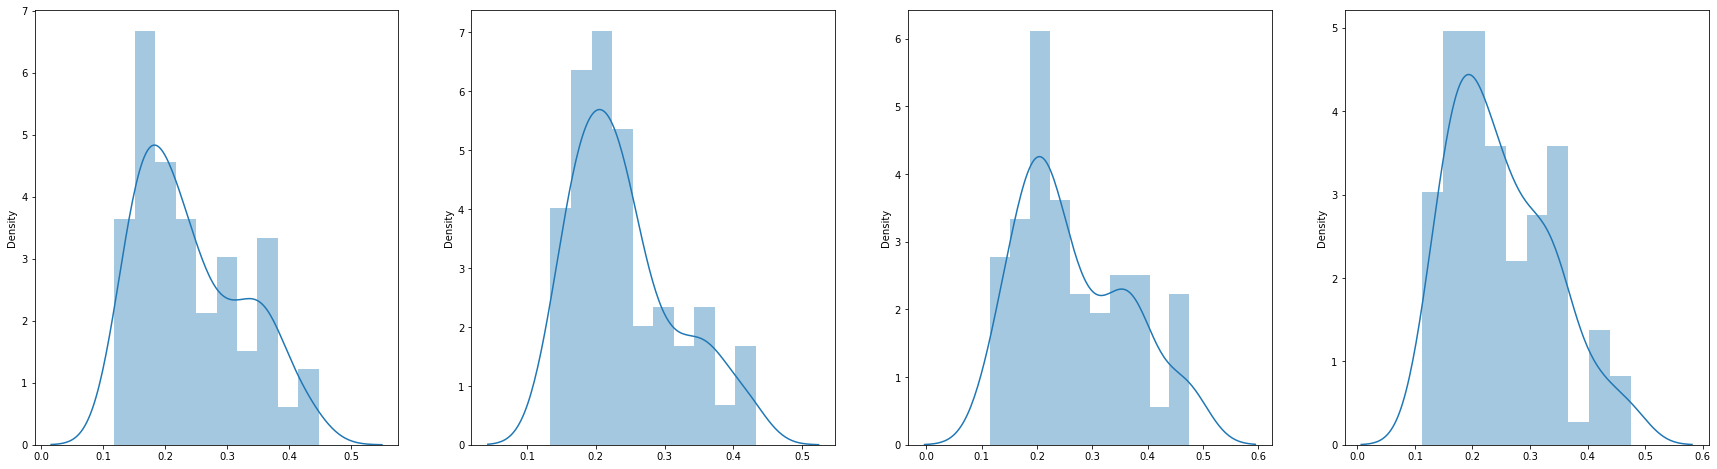

0 AGG 0.09757428226360253 0.2557837560027838
1 ITOT 0.09268721468090442 0.2392182845622301
2 IYT 0.08204770772233222 0.24001319497823714
3 VNQ 0.10863785645917141 0.2649847686290741


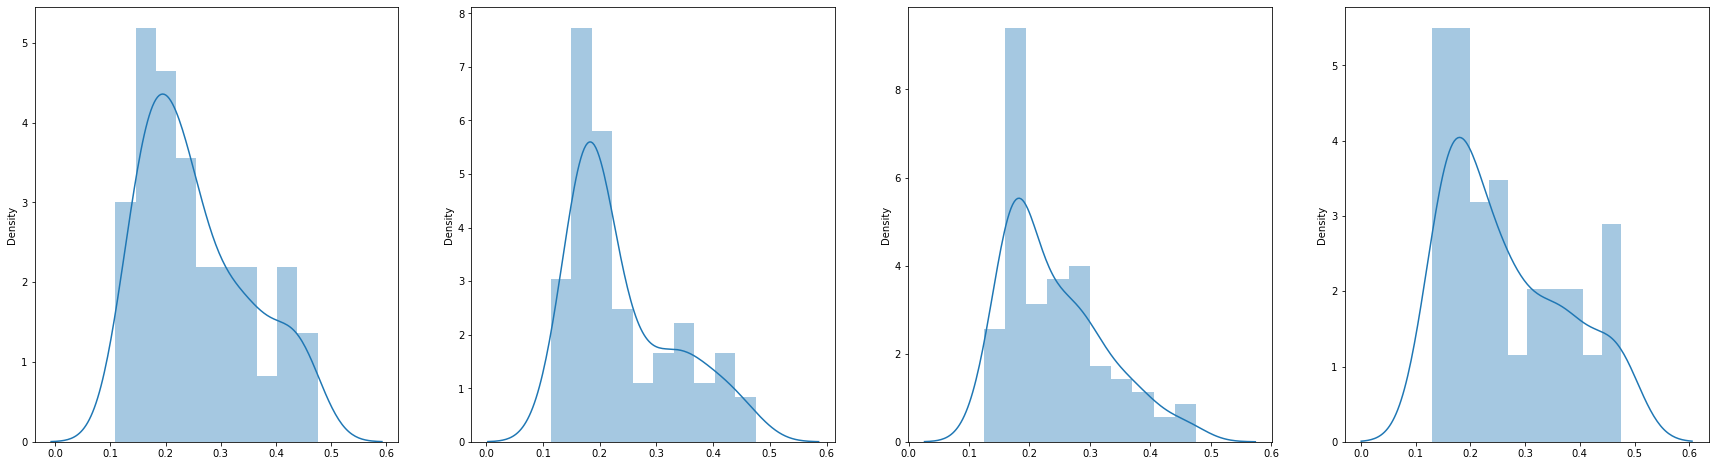

old_etfs: ['ITOT', 'IYT', 'VNQ', 'AGG']
detect [['2016-01-26', 'AGG', 0.10632382983286402, 0.2580900288373232], ['2016-08-17', 'ITOT', 0.10847695063907643, 0.2645914341509342], ['2017-06-29', 'VNQ', 0.1086378564591714, 0.2649847686290741], ['2017-07-07', 'IYT', 0.10689998309635707, 0.25567977003753184], ['2017-07-19', 'ITOT', 0.10718219583213387, 0.26760397501289845], ['2018-07-06', 'IYT', 0.10977857977818758, 0.26759251847863197], ['2018-09-06', 'ITOT', 0.1080742185992957, 0.25835378013551236], ['2018-09-19', 'ITOT', 0.10779999637822082, 0.27132640659809115], ['2018-10-08', 'AGG', 0.11510888983105196, 0.2653467211872339], ['2018-10-16', 'IYT', 0.10947618961829733, 0.2644326831400394], ['2019-02-11', 'ITOT', 0.10700585016353657, 0.26514121785759925], ['2019-03-15', 'ITOT', 0.10912357767291832, 0.26094053462147715], ['2019-07-03', 'ITOT', 0.110540128401056, 0.27397752583026885], ['2019-10-04', 'VNQ', 0.10612393370729353, 0.27306462347507476], ['2019-11-21', 'ITOT', 0.10612783104459579, 

begin_total_asset:1000000
end_total_asset:2010972.6321955344
Sharpe:  0.6953230621566465
hit end!
32
begin_total_asset:1000000
end_total_asset:1669869.475778549
Sharpe:  0.52552780510702
hit end!
33
begin_total_asset:1000000
end_total_asset:1573055.6742444835
Sharpe:  0.4731213855939669
hit end!
34
begin_total_asset:1000000
end_total_asset:1780256.17078959
Sharpe:  0.5757060964393987
hit end!
35
begin_total_asset:1000000
end_total_asset:1558831.9213541136
Sharpe:  0.466970671431674
hit end!
36
begin_total_asset:1000000
end_total_asset:2165294.364891726
Sharpe:  0.7575518960867558
hit end!
37
begin_total_asset:1000000
end_total_asset:1670256.0979861885
Sharpe:  0.5334259891270076
hit end!
38
begin_total_asset:1000000
end_total_asset:1681344.213646053
Sharpe:  0.5438478143127172
hit end!
39
begin_total_asset:1000000
end_total_asset:1872919.708277197
Sharpe:  0.6262080972385466
hit end!
40
begin_total_asset:1000000
end_total_asset:1748557.1042591205
Sharpe:  0.5668594692340722
hit end!
41

begin_total_asset:1000000
end_total_asset:1526789.9251701667
Sharpe:  0.4488008961701586
hit end!
81
begin_total_asset:1000000
end_total_asset:1585989.5001445392
Sharpe:  0.47966908441773864
hit end!
82
begin_total_asset:1000000
end_total_asset:1776838.5372912567
Sharpe:  0.5776596440093518
hit end!
83
begin_total_asset:1000000
end_total_asset:1700721.0828014582
Sharpe:  0.5424588833234887
hit end!
84
begin_total_asset:1000000
end_total_asset:1942835.4795124244
Sharpe:  0.6587114820774601
hit end!
85
begin_total_asset:1000000
end_total_asset:1688207.1572265245
Sharpe:  0.5359173850032188
hit end!
86
begin_total_asset:1000000
end_total_asset:1915939.4653795317
Sharpe:  0.6442758240556117
hit end!
87
begin_total_asset:1000000
end_total_asset:1563184.0783364591
Sharpe:  0.47223015948820146
hit end!
88
begin_total_asset:1000000
end_total_asset:1768118.8813259199
Sharpe:  0.5768814502986418
hit end!
89
begin_total_asset:1000000
end_total_asset:1788761.4579824829
Sharpe:  0.5869039572613992


begin_total_asset:1000000
end_total_asset:1430098.7436469777
Sharpe:  0.5721144631831985
hit end!
30
begin_total_asset:1000000
end_total_asset:1294686.4988348235
Sharpe:  0.4283026268929415
hit end!
31
begin_total_asset:1000000
end_total_asset:1306117.8796837996
Sharpe:  0.43628741555497363
hit end!
32
begin_total_asset:1000000
end_total_asset:1412992.6730885282
Sharpe:  0.5456424765676392
hit end!
33
begin_total_asset:1000000
end_total_asset:1320090.0359315982
Sharpe:  0.45776287842154706
hit end!
34
begin_total_asset:1000000
end_total_asset:1376219.6149210301
Sharpe:  0.5327457647747996
hit end!
35
begin_total_asset:1000000
end_total_asset:1384634.4233955827
Sharpe:  0.5340684380806088
hit end!
36
begin_total_asset:1000000
end_total_asset:1557550.1131622323
Sharpe:  0.6846587110799024
hit end!
37
begin_total_asset:1000000
end_total_asset:1436568.764531875
Sharpe:  0.5797432740472421
hit end!
38
begin_total_asset:1000000
end_total_asset:1299028.0854537496
Sharpe:  0.4308574117339782
h

begin_total_asset:1000000
end_total_asset:1339270.4121308913
Sharpe:  0.47880505182906996
hit end!
79
begin_total_asset:1000000
end_total_asset:1316990.864699124
Sharpe:  0.45280251674906125
hit end!
80
begin_total_asset:1000000
end_total_asset:1374362.3614729594
Sharpe:  0.5184181664437234
hit end!
81
begin_total_asset:1000000
end_total_asset:1357839.8627767975
Sharpe:  0.4991629122055161
hit end!
82
begin_total_asset:1000000
end_total_asset:1367254.8276177607
Sharpe:  0.5139252429533704
hit end!
83
begin_total_asset:1000000
end_total_asset:1383741.0481471936
Sharpe:  0.5464753844567346
hit end!
84
begin_total_asset:1000000
end_total_asset:1481280.1420953663
Sharpe:  0.6230357877945247
hit end!
85
begin_total_asset:1000000
end_total_asset:1336228.0981577225
Sharpe:  0.4857470618337386
hit end!
86
begin_total_asset:1000000
end_total_asset:1378169.7914789566
Sharpe:  0.5223970100486386
hit end!
87
begin_total_asset:1000000
end_total_asset:1428066.5122474902
Sharpe:  0.5738601902062753
h

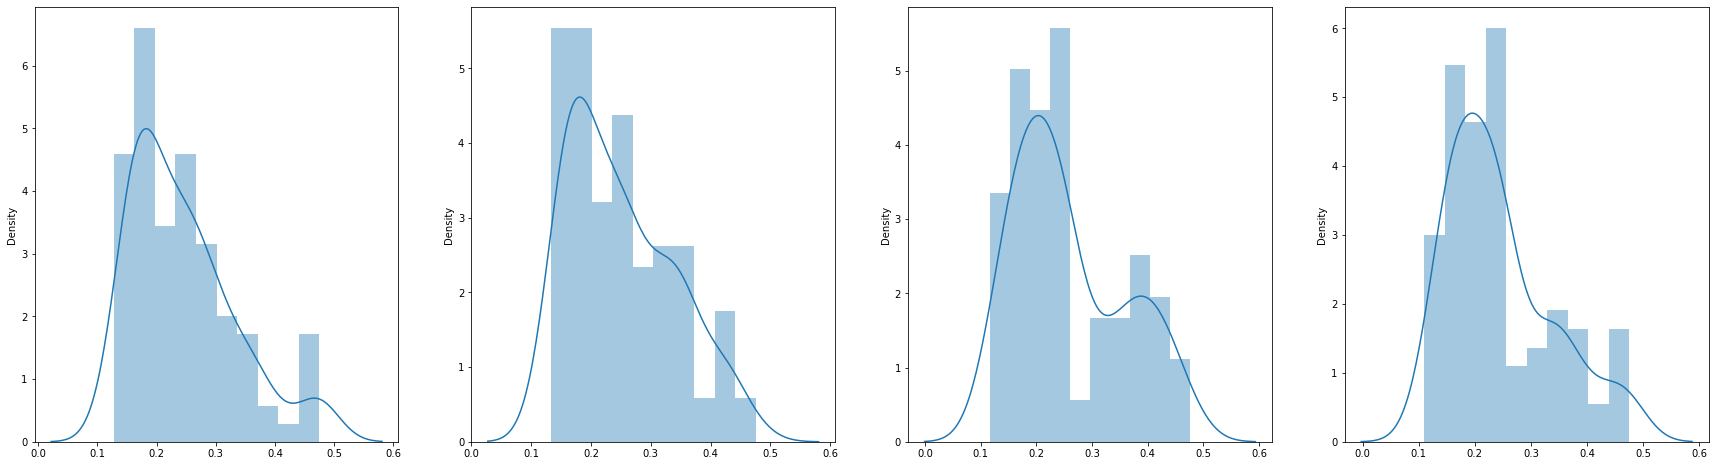

0 AGG 0.10858614744591978 0.25980808056890964
1 ITOT 0.0954841722420588 0.25618758648633955
2 VEU 0.0900876619383709 0.23503899306058884
3 VNQ 0.09193022966972836 0.24896534502506257


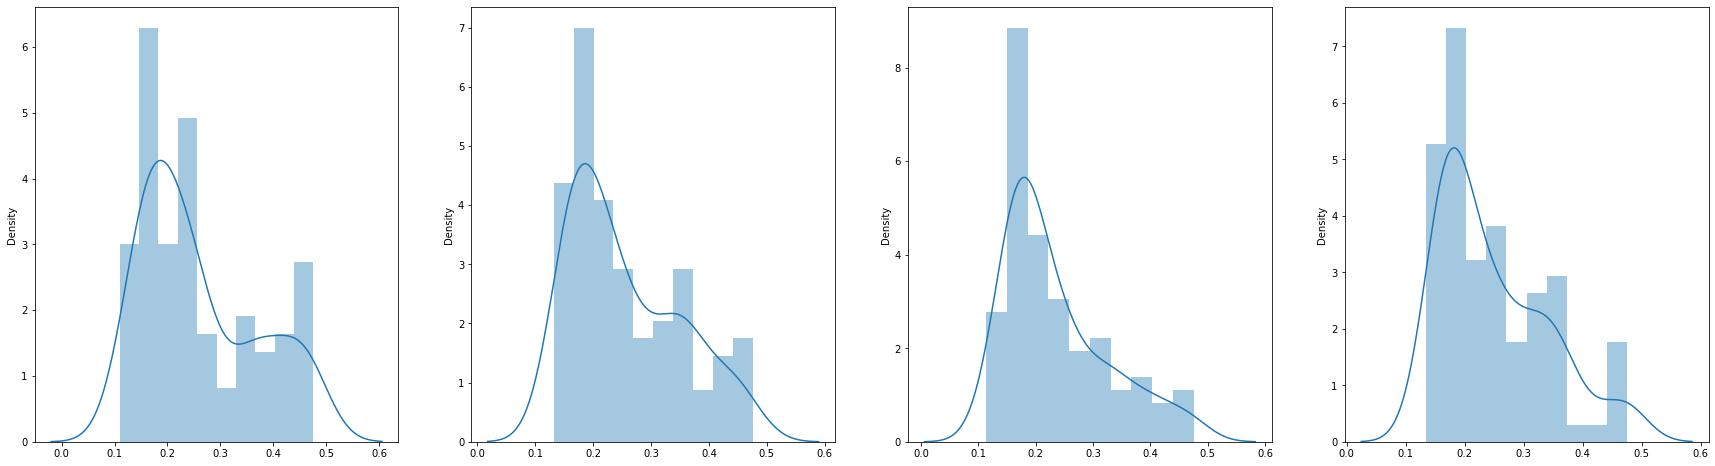

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2016-01-05', 'AGG', 0.10827535961903517, 0.2591944406181574], ['2016-03-18', 'VNQ', 0.10662581134503352, 0.2563547060638666], ['2016-07-08', 'AGG', 0.106295723752675, 0.2719139438867569], ['2016-07-11', 'AGG', 0.1082940165284372, 0.2596025475114584], ['2018-01-11', 'AGG', 0.10858614744591977, 0.25980808056890964], ['2018-06-22', 'VEU', 0.11080406467859548, 0.26493784323334696], ['2018-06-28', 'VEU', 0.1082931907967044, 0.2495372221618891], ['2018-09-26', 'ITOT', 0.10718479657133133, 0.2641590066999197], ['2018-11-30', 'VNQ', 0.10801363579109474, 0.25642630994319915], ['2018-12-06', 'VNQ', 0.10629099148522345, 0.2663317472487688], ['2019-02-07', 'ITOT', 0.10622372868993506, 0.2628068728744984], ['2019-11-12', 'VNQ', 0.10755560444562016, 0.26767094381153583], ['2019-12-03', 'AGG', 0.10641016100334803, 0.27317039780318736], ['2020-01-08', 'VNQ', 0.10683439763503676, 0.2626441755145788], ['2020-01-31', 'ITOT', 0.11151477333116826, 0.2745650

begin_total_asset:1000000
end_total_asset:2059897.8744974798
Sharpe:  0.5936792940080656
hit end!
22
begin_total_asset:1000000
end_total_asset:2365218.261287032
Sharpe:  0.6903049329885437
hit end!
23
begin_total_asset:1000000
end_total_asset:2059646.9460875688
Sharpe:  0.594076092847001
hit end!
24
begin_total_asset:1000000
end_total_asset:2245356.8281645207
Sharpe:  0.6510136593184315
hit end!
25
begin_total_asset:1000000
end_total_asset:2235875.495611763
Sharpe:  0.6547153074952698
hit end!
26
begin_total_asset:1000000
end_total_asset:1911038.6465746274
Sharpe:  0.5439224610666087
hit end!
27
begin_total_asset:1000000
end_total_asset:1971547.8489377713
Sharpe:  0.5632855005427666
hit end!
28
begin_total_asset:1000000
end_total_asset:2231771.3280233652
Sharpe:  0.6504915339899655
hit end!
29
begin_total_asset:1000000
end_total_asset:1968597.7121652886
Sharpe:  0.5643430651906161
hit end!
30
begin_total_asset:1000000
end_total_asset:1981735.2180909286
Sharpe:  0.5718927414457389
hit e

begin_total_asset:1000000
end_total_asset:1987500.0590859735
Sharpe:  0.5744444345089973
hit end!
71
begin_total_asset:1000000
end_total_asset:2117007.670541221
Sharpe:  0.6150742321473784
hit end!
72
begin_total_asset:1000000
end_total_asset:2377972.8314856687
Sharpe:  0.6907761704282804
hit end!
73
begin_total_asset:1000000
end_total_asset:2147888.8754774374
Sharpe:  0.6212078404377119
hit end!
74
begin_total_asset:1000000
end_total_asset:2265665.229874664
Sharpe:  0.659294974385546
hit end!
75
begin_total_asset:1000000
end_total_asset:2218252.751738715
Sharpe:  0.6500887277216992
hit end!
76
begin_total_asset:1000000
end_total_asset:2066249.6926191938
Sharpe:  0.59435528857758
hit end!
77
begin_total_asset:1000000
end_total_asset:2108988.5297059994
Sharpe:  0.6127637632427555
hit end!
78
begin_total_asset:1000000
end_total_asset:2153471.0492449855
Sharpe:  0.627150113675006
hit end!
79
begin_total_asset:1000000
end_total_asset:2032929.0983632011
Sharpe:  0.5859318688314367
hit end!


begin_total_asset:1000000
end_total_asset:1760207.307539792
Sharpe:  0.6693231902672998
hit end!
20
begin_total_asset:1000000
end_total_asset:1839838.6445141782
Sharpe:  0.7144345956598632
hit end!
21
begin_total_asset:1000000
end_total_asset:1695311.080744567
Sharpe:  0.6379218490822279
hit end!
22
begin_total_asset:1000000
end_total_asset:1751989.398150377
Sharpe:  0.6672323866709938
hit end!
23
begin_total_asset:1000000
end_total_asset:1870543.5433822405
Sharpe:  0.7336029314968755
hit end!
24
begin_total_asset:1000000
end_total_asset:1742270.0658914358
Sharpe:  0.6607246937474209
hit end!
25
begin_total_asset:1000000
end_total_asset:1991594.0038316026
Sharpe:  0.7931318301078616
hit end!
26
begin_total_asset:1000000
end_total_asset:1826461.7847381807
Sharpe:  0.7050138228820703
hit end!
27
begin_total_asset:1000000
end_total_asset:1886548.8339464208
Sharpe:  0.7427371956203018
hit end!
28
begin_total_asset:1000000
end_total_asset:1893799.370753015
Sharpe:  0.747737933137631
hit end

begin_total_asset:1000000
end_total_asset:2005120.7024006404
Sharpe:  0.8058612144607274
hit end!
69
begin_total_asset:1000000
end_total_asset:1703984.0675272439
Sharpe:  0.6344173948744297
hit end!
70
begin_total_asset:1000000
end_total_asset:1825746.242695653
Sharpe:  0.7055106642426127
hit end!
71
begin_total_asset:1000000
end_total_asset:1849586.0883998487
Sharpe:  0.7258352514938006
hit end!
72
begin_total_asset:1000000
end_total_asset:1812092.6672901886
Sharpe:  0.7014700554136258
hit end!
73
begin_total_asset:1000000
end_total_asset:1625834.7059230576
Sharpe:  0.5928552287034426
hit end!
74
begin_total_asset:1000000
end_total_asset:1894247.878233293
Sharpe:  0.7460827728005379
hit end!
75
begin_total_asset:1000000
end_total_asset:1782481.4749687547
Sharpe:  0.6765811504968927
hit end!
76
begin_total_asset:1000000
end_total_asset:2011175.6720162176
Sharpe:  0.8122498587140804
hit end!
77
begin_total_asset:1000000
end_total_asset:1802890.9134044538
Sharpe:  0.6966989482367211
hit 

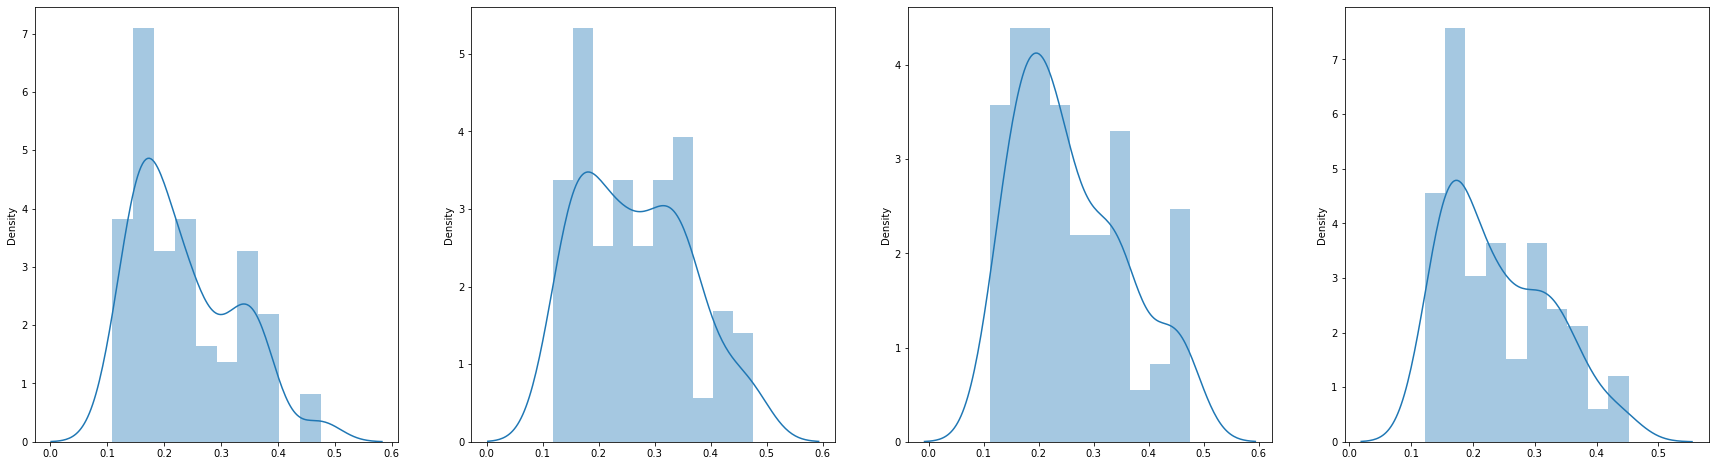

0 ITOT 0.10678646387210972 0.2581777676939964
1 PTF 0.08065291859921145 0.24165832839906215
2 VEU 0.09442165336782758 0.25510443896055224
3 VNQ 0.08572719116430401 0.2450594637542963


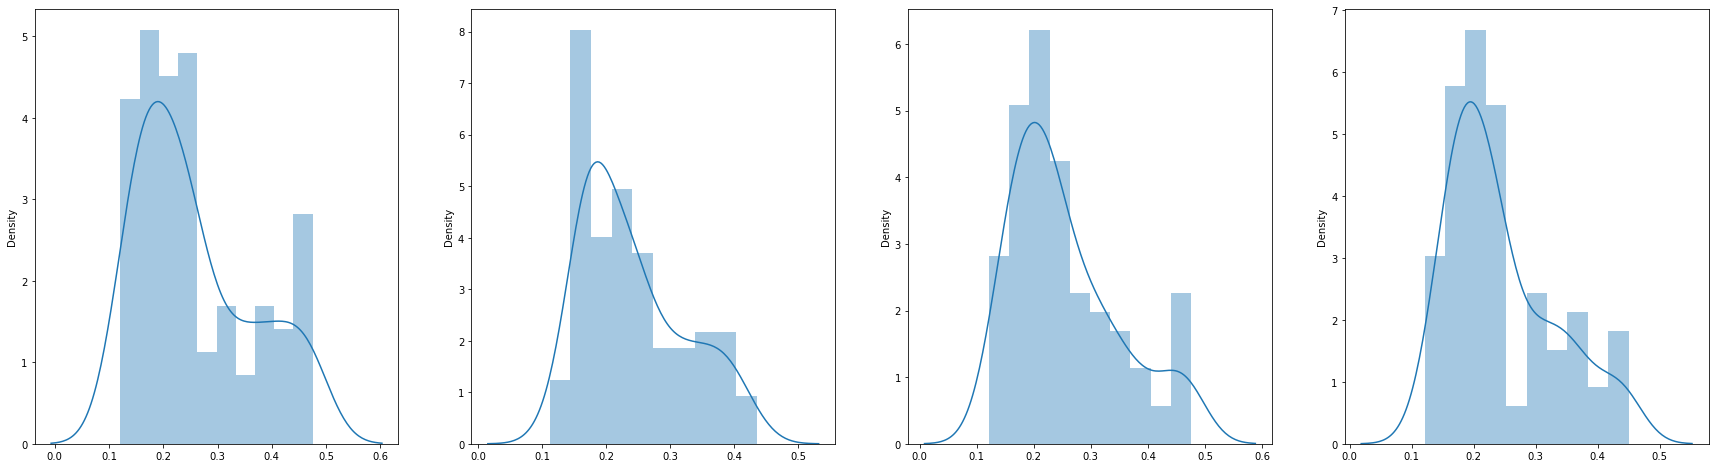

old_etfs: ['ITOT', 'VEU', 'VNQ', 'PTF']
detect [['2016-10-24', 'VEU', 0.10701632276478162, 0.270569706261158], ['2016-11-08', 'ITOT', 0.10936511065449805, 0.25467575021088124], ['2016-12-20', 'ITOT', 0.10799279067807147, 0.26727115131914614], ['2016-12-28', 'PTF', 0.10881345303750782, 0.26387012377381325], ['2017-05-09', 'PTF', 0.10682338736603122, 0.2492073816806078], ['2017-11-07', 'ITOT', 0.10907659913156012, 0.2541483753174543], ['2018-01-05', 'VEU', 0.10839480276419837, 0.2623162378370762], ['2018-04-09', 'ITOT', 0.10678646387210973, 0.2581777676939964], ['2018-12-17', 'VEU', 0.10701755559358672, 0.2793679591268301], ['2019-01-04', 'ITOT', 0.10690367727066064, 0.2575308791548014], ['2019-01-18', 'ITOT', 0.10687163181966497, 0.2444612155854702], ['2019-04-25', 'VEU', 0.10680790406580379, 0.2644786089658737], ['2019-07-18', 'VEU', 0.1081586399381736, 0.2669462316483259], ['2019-07-23', 'PTF', 0.10753115878402124, 0.27024087354540827], ['2020-11-27', 'VNQ', 0.10678645996915793, 0.265

begin_total_asset:1000000
end_total_asset:1728928.683826041
Sharpe:  0.557368730583451
hit end!
38
begin_total_asset:1000000
end_total_asset:1785402.3591603788
Sharpe:  0.5921974285769668
hit end!
39
begin_total_asset:1000000
end_total_asset:1675200.2866269965
Sharpe:  0.5310001431811923
hit end!
40
begin_total_asset:1000000
end_total_asset:1528848.933832219
Sharpe:  0.44688818769614164
hit end!
41
begin_total_asset:1000000
end_total_asset:1636854.1522091182
Sharpe:  0.5082238837320353
hit end!
42
begin_total_asset:1000000
end_total_asset:1770006.5035969247
Sharpe:  0.5798668389127694
hit end!
43
begin_total_asset:1000000
end_total_asset:1754796.7265489467
Sharpe:  0.5719777742834353
hit end!
44
begin_total_asset:1000000
end_total_asset:1728604.1592964109
Sharpe:  0.5546965107542559
hit end!
45
begin_total_asset:1000000
end_total_asset:1767297.3509272002
Sharpe:  0.5697811019663158
hit end!
46
begin_total_asset:1000000
end_total_asset:1796595.0108950918
Sharpe:  0.5836033502620792
hit 

begin_total_asset:1000000
end_total_asset:1500841.7931373136
Sharpe:  0.43323587129480917
hit end!
87
begin_total_asset:1000000
end_total_asset:1760058.1128984247
Sharpe:  0.5631951623831959
hit end!
88
begin_total_asset:1000000
end_total_asset:1713376.8493051792
Sharpe:  0.5512140292809345
hit end!
89
begin_total_asset:1000000
end_total_asset:1850145.348718732
Sharpe:  0.618907848649085
hit end!
90
begin_total_asset:1000000
end_total_asset:1652329.3499949952
Sharpe:  0.5201831731620201
hit end!
91
begin_total_asset:1000000
end_total_asset:1907302.8810383664
Sharpe:  0.6406222506377692
hit end!
92
begin_total_asset:1000000
end_total_asset:1896045.4026279736
Sharpe:  0.6380588416557175
hit end!
93
begin_total_asset:1000000
end_total_asset:1908279.1792780287
Sharpe:  0.6475319331295765
hit end!
94
begin_total_asset:1000000
end_total_asset:1621181.2883620062
Sharpe:  0.5019691822553604
hit end!
95
begin_total_asset:1000000
end_total_asset:1720874.086254233
Sharpe:  0.5470631831584241
hit 

begin_total_asset:1000000
end_total_asset:1311414.4127662936
Sharpe:  0.46216089334342547
hit end!
36
begin_total_asset:1000000
end_total_asset:1324269.513738902
Sharpe:  0.4574102313948083
hit end!
37
begin_total_asset:1000000
end_total_asset:1435383.7820695736
Sharpe:  0.5811431199665988
hit end!
38
begin_total_asset:1000000
end_total_asset:1362581.427969189
Sharpe:  0.508482613497251
hit end!
39
begin_total_asset:1000000
end_total_asset:1277593.0097535208
Sharpe:  0.4134253722696548
hit end!
40
begin_total_asset:1000000
end_total_asset:1391397.2046177934
Sharpe:  0.5393628837745855
hit end!
41
begin_total_asset:1000000
end_total_asset:1381668.7714322195
Sharpe:  0.5281521873041826
hit end!
42
begin_total_asset:1000000
end_total_asset:1239447.8106383032
Sharpe:  0.3663848663318449
hit end!
43
begin_total_asset:1000000
end_total_asset:1230606.4242513366
Sharpe:  0.35581210052605067
hit end!
44
begin_total_asset:1000000
end_total_asset:1398456.7292938218
Sharpe:  0.545796012688289
hit 

begin_total_asset:1000000
end_total_asset:1338747.6126794356
Sharpe:  0.4775497082101046
hit end!
85
begin_total_asset:1000000
end_total_asset:1379220.609556347
Sharpe:  0.5267129191299796
hit end!
86
begin_total_asset:1000000
end_total_asset:1490561.752349049
Sharpe:  0.6456036310616212
hit end!
87
begin_total_asset:1000000
end_total_asset:1447149.1019643815
Sharpe:  0.5784991783037674
hit end!
88
begin_total_asset:1000000
end_total_asset:1404737.2156127177
Sharpe:  0.5447494539134947
hit end!
89
begin_total_asset:1000000
end_total_asset:1314085.4095259735
Sharpe:  0.44302849698801594
hit end!
90
begin_total_asset:1000000
end_total_asset:1375615.540453195
Sharpe:  0.514130045383003
hit end!
91
begin_total_asset:1000000
end_total_asset:1391711.1929282362
Sharpe:  0.5369637893411262
hit end!
92
begin_total_asset:1000000
end_total_asset:1369998.9012042808
Sharpe:  0.5247815842039485
hit end!
93
begin_total_asset:1000000
end_total_asset:1323156.240976389
Sharpe:  0.4683071515316324
hit en

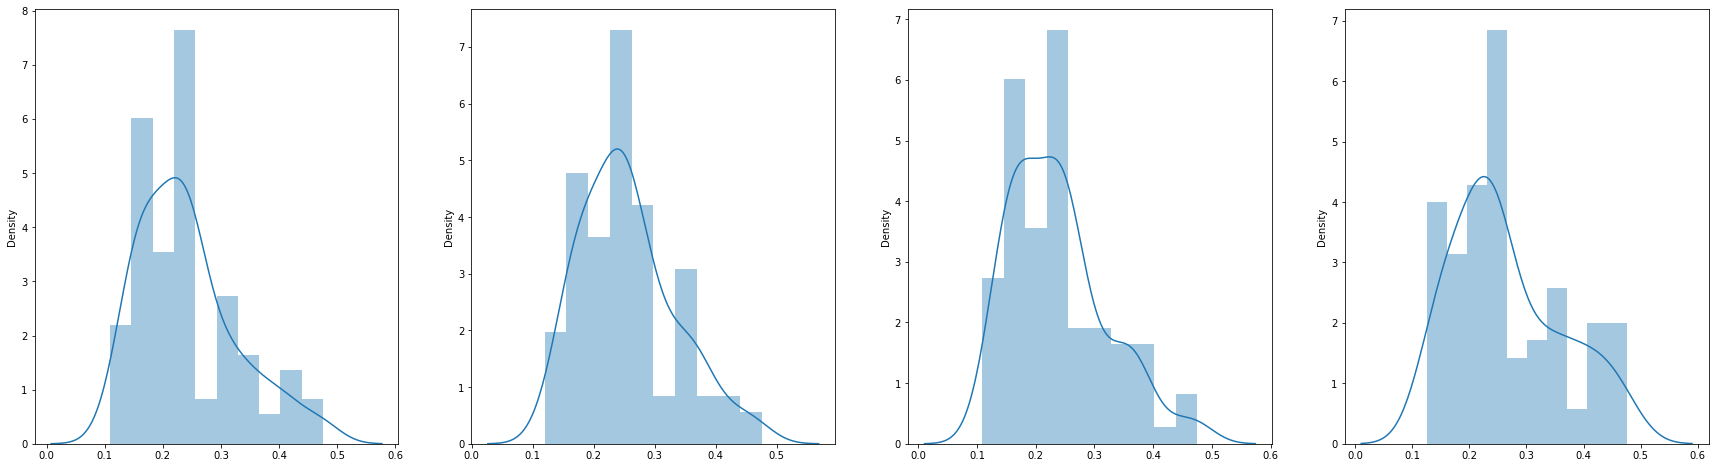

0 AGG 0.08612423023263184 0.23536251246929168
1 ITOT 0.08801015204603238 0.2489858466386795
2 VEU 0.10712715142871983 0.27013391092419625
3 VNQ 0.09017029630192658 0.2455177377164364


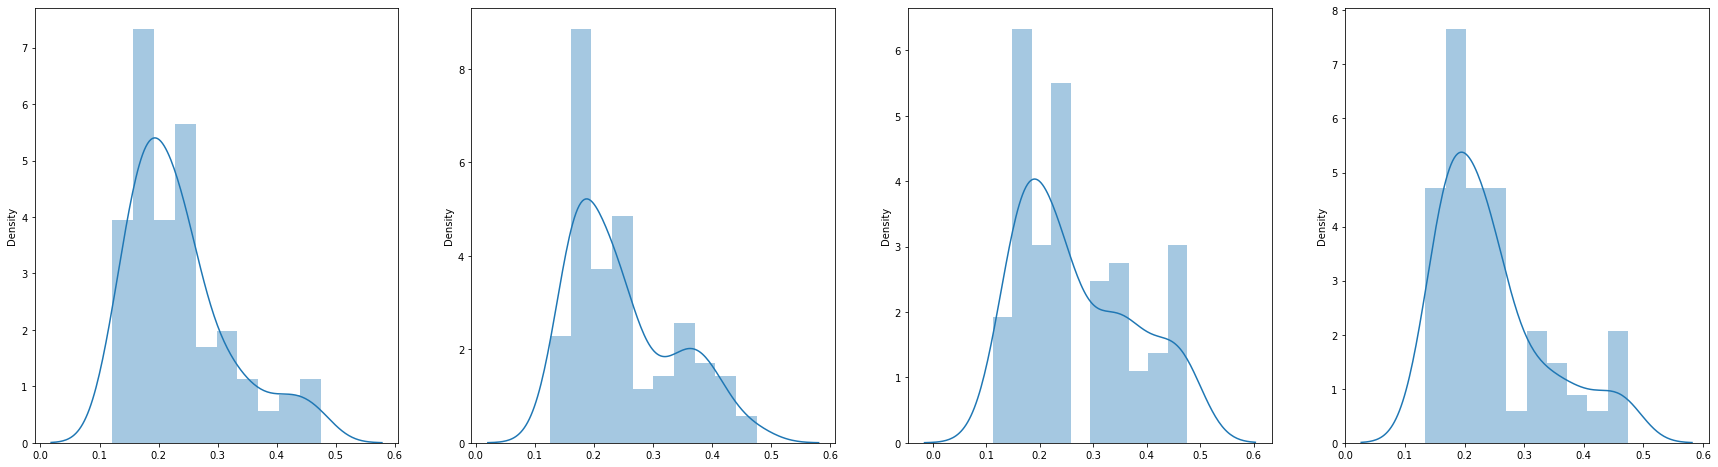

old_etfs: ['ITOT', 'VEU', 'VNQ', 'AGG']
detect [['2016-11-16', 'AGG', 0.10662755271878055, 0.2722392602264881], ['2016-12-19', 'AGG', 0.10616157167357532, 0.25519004218280317], ['2017-06-08', 'ITOT', 0.10650565993902321, 0.2673662223666906], ['2018-06-04', 'VEU', 0.10712715142871981, 0.27013391092419625], ['2018-09-14', 'VEU', 0.10770699603442427, 0.2723230963945389], ['2019-08-09', 'ITOT', 0.10931580690049324, 0.2581677418202162], ['2019-12-10', 'VEU', 0.1065226348363463, 0.2741324496269226], ['2019-12-23', 'VNQ', 0.1070328529463815, 0.2806060080230236], ['2020-02-18', 'ITOT', 0.10828589254563821, 0.2619234445691109], ['2020-08-06', 'VEU', 0.10904646749823274, 0.26291934311389925]]
['ITOT', 'SPMO', 'VNQ', 'AGG']
['ITOT', 'XHE', 'VNQ', 'AGG']
abc ok
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

begin_total_asset:1000000
end_total_asset:2042428.860083787
Sharpe:  0.687317104219895
hit end!
38
begin_total_asset:1000000
end_total_asset:2206778.6947911987
Sharpe:  0.7519823207769595
hit end!
39
begin_total_asset:1000000
end_total_asset:2262065.116360974
Sharpe:  0.7531284672909895
hit end!
40
begin_total_asset:1000000
end_total_asset:2542152.2929160176
Sharpe:  0.878700668292477
hit end!
41
begin_total_asset:1000000
end_total_asset:1887066.9863102962
Sharpe:  0.6255082007847289
hit end!
42
begin_total_asset:1000000
end_total_asset:2178161.255408827
Sharpe:  0.7367544962285932
hit end!
43
begin_total_asset:1000000
end_total_asset:2084096.305625632
Sharpe:  0.7032447441927082
hit end!
44
begin_total_asset:1000000
end_total_asset:2402920.473018971
Sharpe:  0.8170811098539096
hit end!
45
begin_total_asset:1000000
end_total_asset:1952520.917770303
Sharpe:  0.6471877585291107
hit end!
46
begin_total_asset:1000000
end_total_asset:2031027.4046130395
Sharpe:  0.6848280028304755
hit end!
4

begin_total_asset:1000000
end_total_asset:1967030.3462031567
Sharpe:  0.6529104906433745
hit end!
87
begin_total_asset:1000000
end_total_asset:2257068.103878081
Sharpe:  0.7770904457779539
hit end!
88
begin_total_asset:1000000
end_total_asset:1712770.319541975
Sharpe:  0.5362433182125257
hit end!
89
begin_total_asset:1000000
end_total_asset:2022150.3813625174
Sharpe:  0.6760212430019592
hit end!
90
begin_total_asset:1000000
end_total_asset:2247552.6168210725
Sharpe:  0.760054211560351
hit end!
91
begin_total_asset:1000000
end_total_asset:2076577.1843409345
Sharpe:  0.7053865419316425
hit end!
92
begin_total_asset:1000000
end_total_asset:2272888.3832045784
Sharpe:  0.7720873175039918
hit end!
93
begin_total_asset:1000000
end_total_asset:2283137.5594392335
Sharpe:  0.7835794594721844
hit end!
94
begin_total_asset:1000000
end_total_asset:1991963.5908563058
Sharpe:  0.6751388876497587
hit end!
95
begin_total_asset:1000000
end_total_asset:2176998.366667876
Sharpe:  0.7378840069719562
hit en

begin_total_asset:1000000
end_total_asset:1839603.116422593
Sharpe:  0.8200300491338277
hit end!
36
begin_total_asset:1000000
end_total_asset:1656168.0593642425
Sharpe:  0.7064716370616464
hit end!
37
begin_total_asset:1000000
end_total_asset:1810182.3391333472
Sharpe:  0.8090835566940917
hit end!
38
begin_total_asset:1000000
end_total_asset:1903799.746299857
Sharpe:  0.8861086763712707
hit end!
39
begin_total_asset:1000000
end_total_asset:1780050.089172575
Sharpe:  0.7931457584578039
hit end!
40
begin_total_asset:1000000
end_total_asset:1799596.6262694367
Sharpe:  0.801917155985927
hit end!
41
begin_total_asset:1000000
end_total_asset:1697030.2846205418
Sharpe:  0.7379899037687397
hit end!
42
begin_total_asset:1000000
end_total_asset:1920513.7630780933
Sharpe:  0.9061895486484034
hit end!
43
begin_total_asset:1000000
end_total_asset:1785709.5271522652
Sharpe:  0.7967724366337586
hit end!
44
begin_total_asset:1000000
end_total_asset:1942267.1574055424
Sharpe:  0.8840392329570976
hit en

begin_total_asset:1000000
end_total_asset:1729971.5595351153
Sharpe:  0.7587713776834974
hit end!
85
begin_total_asset:1000000
end_total_asset:1824142.3472971907
Sharpe:  0.8002469677573321
hit end!
86
begin_total_asset:1000000
end_total_asset:1720713.1766355198
Sharpe:  0.7553224226474465
hit end!
87
begin_total_asset:1000000
end_total_asset:1831963.2384780901
Sharpe:  0.8268773909952882
hit end!
88
begin_total_asset:1000000
end_total_asset:1687800.5252829199
Sharpe:  0.7214421139625687
hit end!
89
begin_total_asset:1000000
end_total_asset:1753958.191734969
Sharpe:  0.7669926615977055
hit end!
90
begin_total_asset:1000000
end_total_asset:1863028.829407868
Sharpe:  0.8344233049259224
hit end!
91
begin_total_asset:1000000
end_total_asset:1912293.346250559
Sharpe:  0.8627305426205377
hit end!
92
begin_total_asset:1000000
end_total_asset:1711305.581030334
Sharpe:  0.7332777577237468
hit end!
93
begin_total_asset:1000000
end_total_asset:1822508.7447535822
Sharpe:  0.8112401647418075
hit en

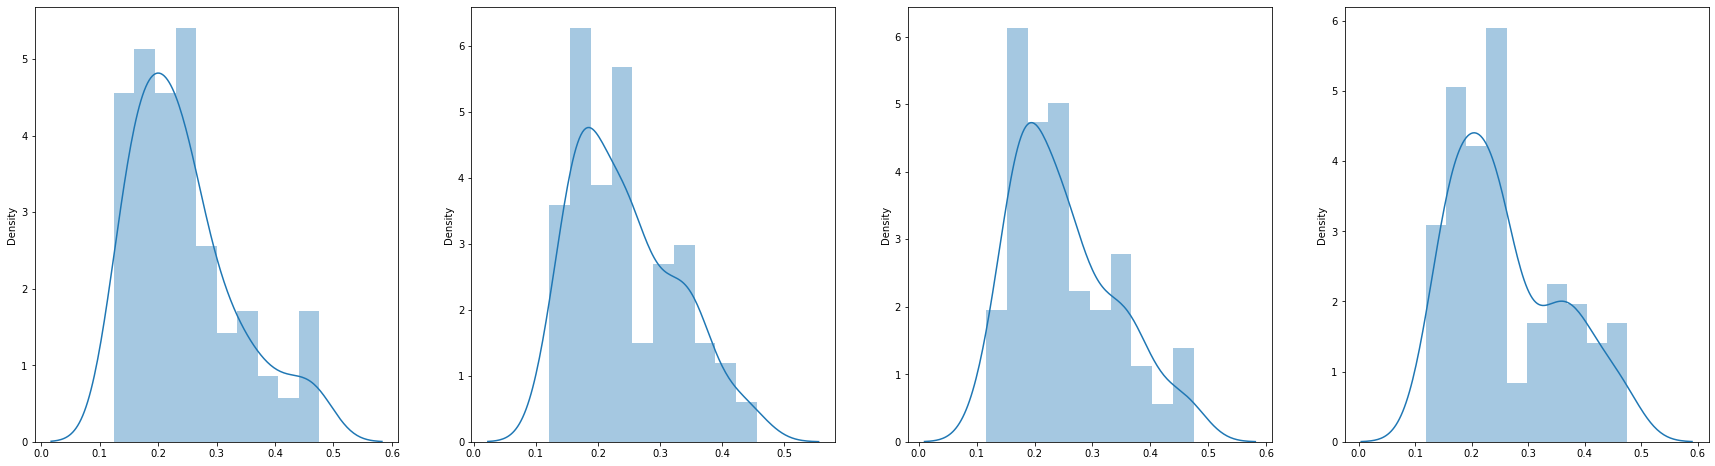

0 AGG 0.10722548225974314 0.2642159427702427
1 ITOT 0.08657008673531834 0.23484232410788536
2 SOXX 0.08996212710996496 0.24507475905120374
3 VNQ 0.09850259274235292 0.2558669781684875


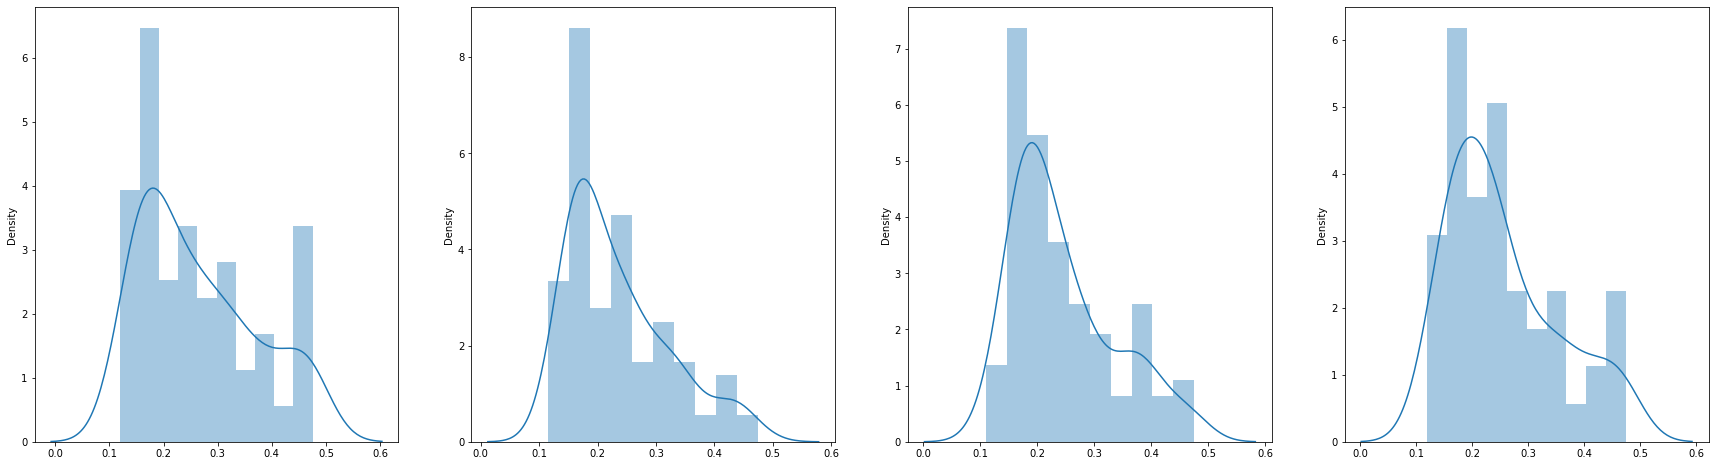

old_etfs: ['ITOT', 'SOXX', 'VNQ', 'AGG']
detect [['2016-07-07', 'VNQ', 0.10761220329090407, 0.27308756291866304], ['2016-12-27', 'AGG', 0.10681306884130642, 0.25994061104953287], ['2017-01-18', 'VNQ', 0.10763929593585075, 0.26909546881914137], ['2017-03-31', 'ITOT', 0.1062311153404401, 0.2715493037551642], ['2017-04-10', 'VNQ', 0.1095891808392724, 0.2687862647324801], ['2017-04-19', 'AGG', 0.1079338985171403, 0.2583253574371338], ['2017-05-11', 'ITOT', 0.10645607916829035, 0.2645967983454466], ['2017-12-20', 'VNQ', 0.10742474560868595, 0.2602915944904089], ['2018-02-20', 'ITOT', 0.10638791294295354, 0.2589209368824959], ['2018-08-08', 'AGG', 0.10722548225974314, 0.2642159427702427], ['2018-09-25', 'SOXX', 0.10716025450035262, 0.27049907654523847], ['2018-10-11', 'SOXX', 0.10850982065657154, 0.27303352676332], ['2019-04-18', 'AGG', 0.10684982787657639, 0.26835277885198594], ['2019-05-14', 'ITOT', 0.10675724320320497, 0.2639837893098593], ['2019-07-23', 'SOXX', 0.1065519523598422, 0.2582

begin_total_asset:1000000
end_total_asset:2235298.7187338225
Sharpe:  0.7423598904173384
hit end!
25
begin_total_asset:1000000
end_total_asset:2282033.651861275
Sharpe:  0.7663365155514609
hit end!
26
begin_total_asset:1000000
end_total_asset:2237438.05584612
Sharpe:  0.7439909243371938
hit end!
27
begin_total_asset:1000000
end_total_asset:2135602.3795929607
Sharpe:  0.7137664808785176
hit end!
28
begin_total_asset:1000000
end_total_asset:2122904.908255902
Sharpe:  0.7070750051376123
hit end!
29
begin_total_asset:1000000
end_total_asset:2299588.923422006
Sharpe:  0.7761357189887739
hit end!
30
begin_total_asset:1000000
end_total_asset:2610886.6423118496
Sharpe:  0.8784077072761922
hit end!
31
begin_total_asset:1000000
end_total_asset:2562717.000888985
Sharpe:  0.8690860121610474
hit end!
32
begin_total_asset:1000000
end_total_asset:2082107.243251278
Sharpe:  0.6935661895141175
hit end!
33
begin_total_asset:1000000
end_total_asset:2196228.697873186
Sharpe:  0.7498638305819932
hit end!
3

begin_total_asset:1000000
end_total_asset:2106754.9633073183
Sharpe:  0.7081607768348911
hit end!
74
begin_total_asset:1000000
end_total_asset:2081874.7253735687
Sharpe:  0.6960096346483354
hit end!
75
begin_total_asset:1000000
end_total_asset:2186186.354299954
Sharpe:  0.728478223078619
hit end!
76
begin_total_asset:1000000
end_total_asset:2004219.3253819286
Sharpe:  0.6666254711465223
hit end!
77
begin_total_asset:1000000
end_total_asset:2211262.9159625755
Sharpe:  0.7475427015354887
hit end!
78
begin_total_asset:1000000
end_total_asset:2116862.752583658
Sharpe:  0.7031171194015203
hit end!
79
begin_total_asset:1000000
end_total_asset:2246139.9027481806
Sharpe:  0.7564431972809066
hit end!
80
begin_total_asset:1000000
end_total_asset:2190285.156123228
Sharpe:  0.7405782725916962
hit end!
81
begin_total_asset:1000000
end_total_asset:2323279.731510881
Sharpe:  0.7853843131314071
hit end!
82
begin_total_asset:1000000
end_total_asset:2056934.4543342988
Sharpe:  0.67624525994731
hit end!


begin_total_asset:1000000
end_total_asset:1962346.400444901
Sharpe:  0.8914420734479013
hit end!
23
begin_total_asset:1000000
end_total_asset:2011391.0515263816
Sharpe:  0.9216169658039003
hit end!
24
begin_total_asset:1000000
end_total_asset:1909230.102079252
Sharpe:  0.856333771442435
hit end!
25
begin_total_asset:1000000
end_total_asset:1762922.0608994432
Sharpe:  0.7438463236865435
hit end!
26
begin_total_asset:1000000
end_total_asset:2121734.9359298265
Sharpe:  0.9617792708655678
hit end!
27
begin_total_asset:1000000
end_total_asset:1972505.8971746245
Sharpe:  0.8937540978111651
hit end!
28
begin_total_asset:1000000
end_total_asset:1796820.2833529238
Sharpe:  0.7761566166669754
hit end!
29
begin_total_asset:1000000
end_total_asset:2069142.2014219551
Sharpe:  0.9488985430229491
hit end!
30
begin_total_asset:1000000
end_total_asset:1968756.1665469138
Sharpe:  0.8706582936836601
hit end!
31
begin_total_asset:1000000
end_total_asset:1692058.4068037707
Sharpe:  0.6980020265363174
hit e

begin_total_asset:1000000
end_total_asset:1737205.682913631
Sharpe:  0.7342509699225416
hit end!
72
begin_total_asset:1000000
end_total_asset:1968857.046137608
Sharpe:  0.8815136215892597
hit end!
73
begin_total_asset:1000000
end_total_asset:1912837.965319299
Sharpe:  0.841427597385509
hit end!
74
begin_total_asset:1000000
end_total_asset:2030542.92156238
Sharpe:  0.9363688057299724
hit end!
75
begin_total_asset:1000000
end_total_asset:2159441.400064889
Sharpe:  1.0068310039936217
hit end!
76
begin_total_asset:1000000
end_total_asset:1983162.024686742
Sharpe:  0.9089668164122809
hit end!
77
begin_total_asset:1000000
end_total_asset:2083311.618094207
Sharpe:  0.9616082903780403
hit end!
78
begin_total_asset:1000000
end_total_asset:1771318.5091209735
Sharpe:  0.7575857713067171
hit end!
79
begin_total_asset:1000000
end_total_asset:1977448.7411605762
Sharpe:  0.8997222495728714
hit end!
80
begin_total_asset:1000000
end_total_asset:1600386.8422999827
Sharpe:  0.6382008996994253
hit end!
81

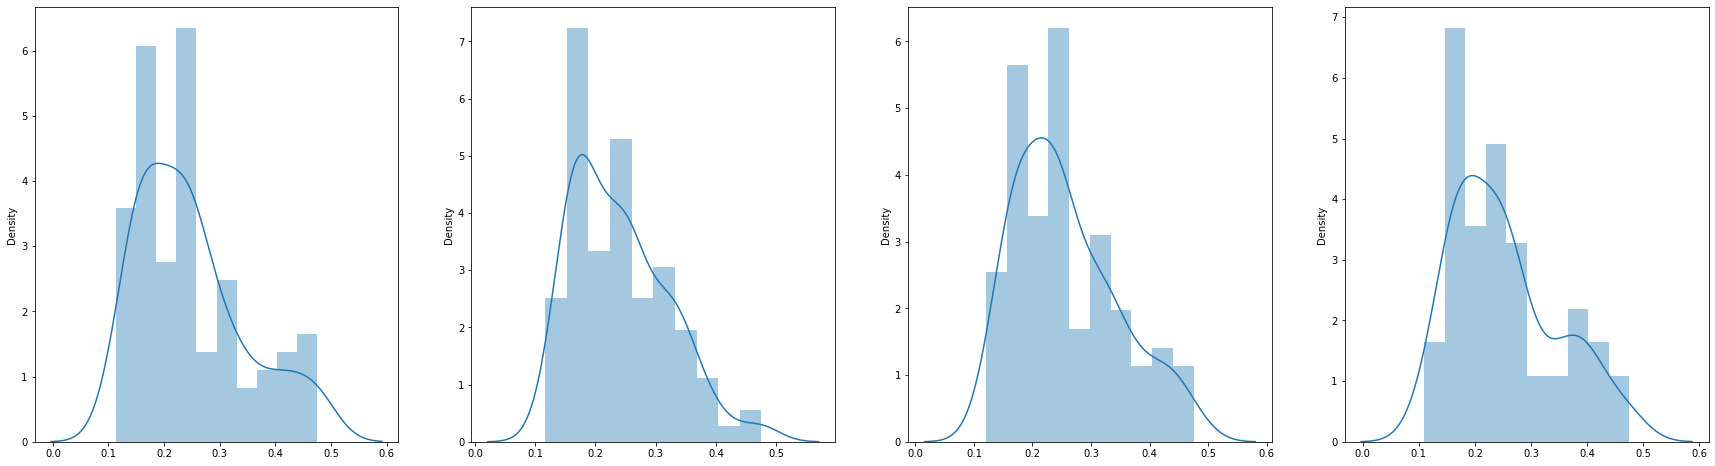

0 ITOT 0.09296462927455637 0.2507246536016464
1 LQD 0.10672844079639392 0.26907010570168494
2 SOXX 0.09184466304822146 0.23881588816642763
3 VNQ 0.090159904807147 0.24138935334980488


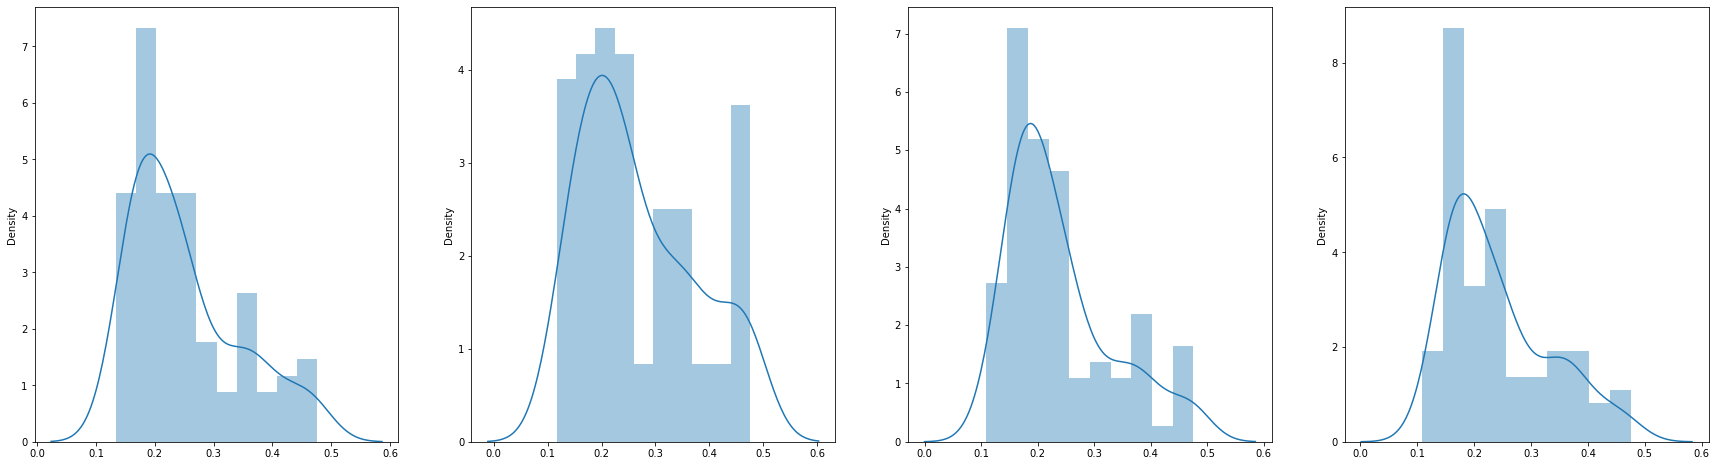

old_etfs: ['ITOT', 'SOXX', 'VNQ', 'LQD']
detect [['2016-07-29', 'VNQ', 0.10686839069147151, 0.25944109410047533], ['2016-08-18', 'LQD', 0.108884378336668, 0.26303138449788094], ['2016-09-15', 'ITOT', 0.10620670945590747, 0.2786702750623226], ['2017-03-13', 'SOXX', 0.10667550658693731, 0.2738866726309061], ['2017-07-13', 'SOXX', 0.10641718681135134, 0.25996299415826796], ['2017-11-10', 'LQD', 0.10633570537109753, 0.25656717248260974], ['2018-02-15', 'SOXX', 0.10676368297660405, 0.2615761376917362], ['2018-08-31', 'LQD', 0.10672844079639389, 0.26907010570168494], ['2018-09-24', 'VNQ', 0.1066481429607669, 0.2512773614376783], ['2018-11-06', 'SOXX', 0.10717359278304044, 0.25958167523145675], ['2019-01-10', 'SOXX', 0.10629331798586555, 0.25026119597256186], ['2019-03-26', 'SOXX', 0.10697393698967743, 0.2644446760416031], ['2019-04-05', 'LQD', 0.10910275443217698, 0.25739217042922974], ['2019-12-13', 'VNQ', 0.11042663461027985, 0.26939906418323517], ['2020-05-13', 'SOXX', 0.10715200474120323

begin_total_asset:1000000
end_total_asset:2182531.2745061126
Sharpe:  0.7512199607116098
hit end!
25
begin_total_asset:1000000
end_total_asset:2096461.2784093525
Sharpe:  0.7067129021711085
hit end!
26
begin_total_asset:1000000
end_total_asset:2386266.2659133547
Sharpe:  0.8120207338476573
hit end!
27
begin_total_asset:1000000
end_total_asset:1770790.5519046346
Sharpe:  0.5612004030040358
hit end!
28
begin_total_asset:1000000
end_total_asset:2056123.994740177
Sharpe:  0.6913388557684463
hit end!
29
begin_total_asset:1000000
end_total_asset:2194411.334114204
Sharpe:  0.7409210306656246
hit end!
30
begin_total_asset:1000000
end_total_asset:1936038.14975731
Sharpe:  0.6482603260172382
hit end!
31
begin_total_asset:1000000
end_total_asset:2090384.863613711
Sharpe:  0.7047971088319668
hit end!
32
begin_total_asset:1000000
end_total_asset:2251330.719694882
Sharpe:  0.7617485016364752
hit end!
33
begin_total_asset:1000000
end_total_asset:2109554.80822915
Sharpe:  0.7070964666201445
hit end!
3

begin_total_asset:1000000
end_total_asset:1959372.1362405682
Sharpe:  0.6553531918973773
hit end!
74
begin_total_asset:1000000
end_total_asset:1961359.060665783
Sharpe:  0.6425904864736945
hit end!
75
begin_total_asset:1000000
end_total_asset:2112674.7364887064
Sharpe:  0.702572160141323
hit end!
76
begin_total_asset:1000000
end_total_asset:2059452.1426066929
Sharpe:  0.6899250153299371
hit end!
77
begin_total_asset:1000000
end_total_asset:2022939.2957425013
Sharpe:  0.6807761318809858
hit end!
78
begin_total_asset:1000000
end_total_asset:2251270.1557014994
Sharpe:  0.7612515357032738
hit end!
79
begin_total_asset:1000000
end_total_asset:2048895.8439919092
Sharpe:  0.6884504211128322
hit end!
80
begin_total_asset:1000000
end_total_asset:1837074.5654471281
Sharpe:  0.5937263230977072
hit end!
81
begin_total_asset:1000000
end_total_asset:2272090.397318459
Sharpe:  0.7792499276441581
hit end!
82
begin_total_asset:1000000
end_total_asset:1895526.9661533427
Sharpe:  0.627338005682911
hit en

begin_total_asset:1000000
end_total_asset:1838293.8591482907
Sharpe:  0.8319641812982616
hit end!
23
begin_total_asset:1000000
end_total_asset:1784009.068582308
Sharpe:  0.7918632563497534
hit end!
24
begin_total_asset:1000000
end_total_asset:1779580.8974363788
Sharpe:  0.8103382278572214
hit end!
25
begin_total_asset:1000000
end_total_asset:1928970.9017750581
Sharpe:  0.9000006324240964
hit end!
26
begin_total_asset:1000000
end_total_asset:1892580.7172375808
Sharpe:  0.8681008635329752
hit end!
27
begin_total_asset:1000000
end_total_asset:1726935.8181946005
Sharpe:  0.7506585424503759
hit end!
28
begin_total_asset:1000000
end_total_asset:1839965.9255357785
Sharpe:  0.8309827538055938
hit end!
29
begin_total_asset:1000000
end_total_asset:1780353.5499713288
Sharpe:  0.7935481001197967
hit end!
30
begin_total_asset:1000000
end_total_asset:1775844.1564637863
Sharpe:  0.7849604209163362
hit end!
31
begin_total_asset:1000000
end_total_asset:1812664.1835836333
Sharpe:  0.8174395797398235
hit

begin_total_asset:1000000
end_total_asset:1922997.7405059927
Sharpe:  0.8807404946155881
hit end!
72
begin_total_asset:1000000
end_total_asset:1680326.7620021184
Sharpe:  0.7245529458813159
hit end!
73
begin_total_asset:1000000
end_total_asset:1743572.0324137937
Sharpe:  0.7726414144716448
hit end!
74
begin_total_asset:1000000
end_total_asset:1701833.047198506
Sharpe:  0.7207850745278616
hit end!
75
begin_total_asset:1000000
end_total_asset:1768821.2138346892
Sharpe:  0.7769538175057109
hit end!
76
begin_total_asset:1000000
end_total_asset:1811737.1539778498
Sharpe:  0.8263801333499909
hit end!
77
begin_total_asset:1000000
end_total_asset:1894126.309448036
Sharpe:  0.8529710903881422
hit end!
78
begin_total_asset:1000000
end_total_asset:1911873.4797449866
Sharpe:  0.8707784099624671
hit end!
79
begin_total_asset:1000000
end_total_asset:1577291.6292643766
Sharpe:  0.6474285878488398
hit end!
80
begin_total_asset:1000000
end_total_asset:1725214.7585111852
Sharpe:  0.74300871966554
hit en

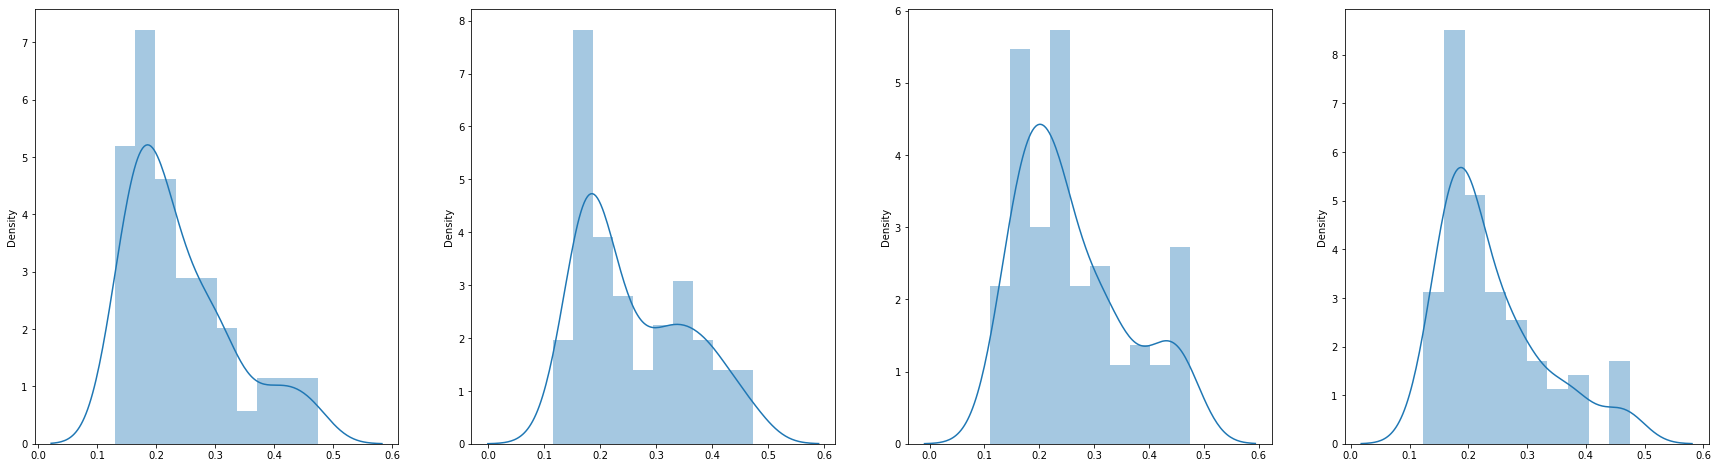

0 ITOT 0.09874022724488993 0.2561958813667297
1 SHV 0.1066372177794681 0.2578359687328339
2 SOXX 0.08266267521639029 0.23280011996626854
3 VNQ 0.09531313074627432 0.25316802971065044


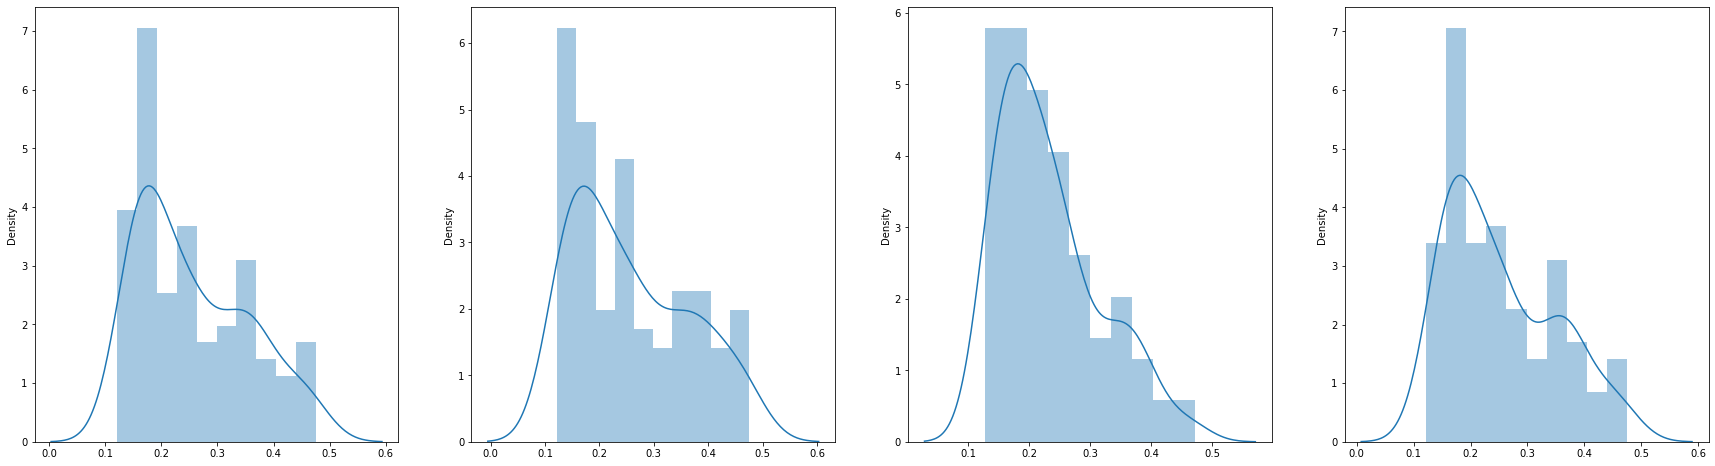

old_etfs: ['ITOT', 'SOXX', 'VNQ', 'SHV']
detect [['2017-03-24', 'SOXX', 0.11193621846767624, 0.2654148559272289], ['2017-06-12', 'SHV', 0.10737967703586847, 0.2689560038596392], ['2018-06-18', 'ITOT', 0.10681665003515252, 0.2616576924175024], ['2019-06-25', 'SHV', 0.1066372177794681, 0.2578359687328339], ['2020-06-05', 'SOXX', 0.10943685098641903, 0.2749759105592966], ['2020-07-16', 'SHV', 0.10817891532069138, 0.27249854266643525], ['2020-09-11', 'SOXX', 0.10660609586814823, 0.2627166560292244], ['2020-10-23', 'SHV', 0.10709395011244173, 0.2737534263730049], ['2020-12-28', 'SHV', 0.1065699455414744, 0.269607358276844]]
ITOT ['ITOT', 'SOXX', 'VNQ', 'SHV']
VEU ['ITOT', 'SOXX', 'VNQ', 'SHV']
VEUnot in comb
['ITOT', 'VEU', 'VNQ', 'SHV']
2018-09-01 2019-06-25
2018-09-01 no trade
2018-09-02 no trade
2018-09-03 no trade
2018-09-05
2018-09-06
2018-09-07
2018-09-08
2018-09-08 no trade
2018-09-09 no trade
2018-09-11
2018-09-12
2018-09-13
2018-09-14
2018-09-15
2018-09-15 no trade
2018-09-16 no tr

2019-04-19
2019-04-19 no trade
2019-04-20 no trade
2019-04-21 no trade
2019-04-23
2019-04-24
2019-04-25
2019-04-26
2019-04-27
2019-04-27 no trade
2019-04-28 no trade
2019-04-30
2019-05-01
2019-05-02
2019-05-03
2019-05-04
2019-05-04 no trade
2019-05-05 no trade
2019-05-07
2019-05-08
2019-05-09
2019-05-10
2019-05-11
2019-05-11 no trade
2019-05-12 no trade
2019-05-14
2019-05-15
2019-05-16
2019-05-17
2019-05-18
2019-05-18 no trade
2019-05-19 no trade
2019-05-21
2019-05-22
2019-05-23
2019-05-24
2019-05-25
2019-05-25 no trade
2019-05-26 no trade
2019-05-27 no trade
2019-05-29
2019-05-30
2019-05-31
2019-06-01
2019-06-01 no trade
2019-06-02 no trade
2019-06-04
2019-06-05
2019-06-06
2019-06-07
2019-06-08
2019-06-08 no trade
2019-06-09 no trade
2019-06-11
2019-06-12
2019-06-13
2019-06-14
2019-06-15
2019-06-15 no trade
2019-06-16 no trade
2019-06-18
2019-06-19
2019-06-20
2019-06-21
2019-06-22
2019-06-22 no trade
2019-06-23 no trade
2019-06-25
['ITOT', 'SOXX', 'VNQ', 'VONE']
['ITOT', 'SOXX', 'VNQ'

['ITOT', 'SOXX', 'VNQ', 'IGSB']
['ITOT', 'SOXX', 'VNQ', 'LABD']
['ITOT', 'SOXX', 'VNQ', 'GSIE']
['ITOT', 'SOXX', 'VNQ', 'BSJN']
['ITOT', 'SOXX', 'VNQ', 'VB']
['ITOT', 'SOXX', 'VNQ', 'TIPZ']
['ITOT', 'SOXX', 'VNQ', 'PLW']
['ITOT', 'SOXX', 'VNQ', 'SDS']
['ITOT', 'SOXX', 'VNQ', 'PGF']
['ITOT', 'SOXX', 'VNQ', 'DUST']
['ITOT', 'SOXX', 'VNQ', 'RCD']
['ITOT', 'SOXX', 'VNQ', 'HDAW']
['ITOT', 'SOXX', 'VNQ', 'FNDB']
['ITOT', 'SOXX', 'VNQ', 'XVZ']
['ITOT', 'SOXX', 'VNQ', 'TDTF']
['ITOT', 'SOXX', 'VNQ', 'ARKW']
['ITOT', 'SOXX', 'VNQ', 'AOR']
['ITOT', 'SOXX', 'VNQ', 'XAR']
['ITOT', 'SOXX', 'VNQ', 'BWZ']
['ITOT', 'SOXX', 'VNQ', 'TMV']
['ITOT', 'SOXX', 'VNQ', 'FTA']
['ITOT', 'SOXX', 'VNQ', 'WBIF']
['ITOT', 'SOXX', 'VNQ', 'ICF']
['ITOT', 'SOXX', 'VNQ', 'VV']
['ITOT', 'SOXX', 'VNQ', 'QUS']
['ITOT', 'SOXX', 'VNQ', 'IGF']
['ITOT', 'SOXX', 'VNQ', 'UDN']
['ITOT', 'SOXX', 'VNQ', 'GCC']
['ITOT', 'SOXX', 'VNQ', 'XHS']
['ITOT', 'SOXX', 'VNQ', 'ROUS']
['ITOT', 'SOXX', 'VNQ', 'INDY']
['ITOT', 'SOXX', 'VNQ', 'IJH

['ITOT', 'SOXX', 'VNQ', 'XT']
['ITOT', 'SOXX', 'VNQ', 'LEMB']
['ITOT', 'SOXX', 'VNQ', 'SCC']
['ITOT', 'SOXX', 'VNQ', 'SRS']
['ITOT', 'SOXX', 'VNQ', 'IFV']
['ITOT', 'SOXX', 'VNQ', 'TAN']
['ITOT', 'SOXX', 'VNQ', 'DEEP']
['ITOT', 'SOXX', 'VNQ', 'EWZ']
['ITOT', 'SOXX', 'VNQ', 'GMF']
['ITOT', 'SOXX', 'VNQ', 'VTWG']
['ITOT', 'SOXX', 'VNQ', 'UDOW']
['ITOT', 'SOXX', 'VNQ', 'KBE']
['ITOT', 'SOXX', 'VNQ', 'IVAL']
['ITOT', 'SOXX', 'VNQ', 'IMLP']
['ITOT', 'SOXX', 'VNQ', 'FSZ']
['ITOT', 'SOXX', 'VNQ', 'LMBS']
['ITOT', 'SOXX', 'VNQ', 'CIZ']
['ITOT', 'SOXX', 'VNQ', 'FYLD']
['ITOT', 'SOXX', 'VNQ', 'PSCM']
['ITOT', 'SOXX', 'VNQ', 'DVYA']
['ITOT', 'SOXX', 'VNQ', 'USFR']
['ITOT', 'SOXX', 'VNQ', 'QMN']
['ITOT', 'SOXX', 'VNQ', 'GWX']
['ITOT', 'SOXX', 'VNQ', 'IWN']
['ITOT', 'SOXX', 'VNQ', 'FXD']
['ITOT', 'SOXX', 'VNQ', 'IGV']
['ITOT', 'SOXX', 'VNQ', 'HYMB']
['ITOT', 'SOXX', 'VNQ', 'GXG']
['ITOT', 'SOXX', 'VNQ', 'SPTS']
['ITOT', 'SOXX', 'VNQ', 'SMEZ']
['ITOT', 'SOXX', 'VNQ', 'ITB']
['ITOT', 'SOXX', 'VNQ', 'F

begin_total_asset:1000000
end_total_asset:2463012.5196812213
Sharpe:  0.8592512747357987
hit end!
23
begin_total_asset:1000000
end_total_asset:1875079.0284779586
Sharpe:  0.6320200821482858
hit end!
24
begin_total_asset:1000000
end_total_asset:2468728.275615165
Sharpe:  0.8661758505759504
hit end!
25
begin_total_asset:1000000
end_total_asset:2150175.013771552
Sharpe:  0.7567722427217192
hit end!
26
begin_total_asset:1000000
end_total_asset:2292312.9033267177
Sharpe:  0.8196514488390194
hit end!
27
begin_total_asset:1000000
end_total_asset:2156961.641789695
Sharpe:  0.7403724849629174
hit end!
28
begin_total_asset:1000000
end_total_asset:2326809.2341631064
Sharpe:  0.8171235819084326
hit end!
29
begin_total_asset:1000000
end_total_asset:2376209.222895119
Sharpe:  0.8383058021275032
hit end!
30
begin_total_asset:1000000
end_total_asset:2301362.8494005296
Sharpe:  0.8042329506055063
hit end!
31
begin_total_asset:1000000
end_total_asset:1957108.9514400437
Sharpe:  0.6667876095912157
hit en

begin_total_asset:1000000
end_total_asset:2367840.4470758075
Sharpe:  0.8246861097597843
hit end!
72
begin_total_asset:1000000
end_total_asset:2386960.9027506546
Sharpe:  0.8387462244139341
hit end!
73
begin_total_asset:1000000
end_total_asset:2438604.2001329144
Sharpe:  0.8606080207103228
hit end!
74
begin_total_asset:1000000
end_total_asset:2040313.6211930078
Sharpe:  0.7020802499637494
hit end!
75
begin_total_asset:1000000
end_total_asset:2427373.396261355
Sharpe:  0.8462135997870607
hit end!
76
begin_total_asset:1000000
end_total_asset:2244415.908350027
Sharpe:  0.7929626610022111
hit end!
77
begin_total_asset:1000000
end_total_asset:2515961.896351076
Sharpe:  0.8614908749924102
hit end!
78
begin_total_asset:1000000
end_total_asset:2204183.286795689
Sharpe:  0.776061260862286
hit end!
79
begin_total_asset:1000000
end_total_asset:2631727.9426790727
Sharpe:  0.9250745765654107
hit end!
80
begin_total_asset:1000000
end_total_asset:2035321.7989867171
Sharpe:  0.6923802454687263
hit end

begin_total_asset:1000000
end_total_asset:1677322.036694284
Sharpe:  0.7597054238457305
hit end!
21
begin_total_asset:1000000
end_total_asset:1858222.4903750608
Sharpe:  0.858428025403554
hit end!
22
begin_total_asset:1000000
end_total_asset:1957620.1691132246
Sharpe:  0.9294442021622308
hit end!
23
begin_total_asset:1000000
end_total_asset:1877582.2505424102
Sharpe:  0.8729401625615126
hit end!
24
begin_total_asset:1000000
end_total_asset:1776272.9475666664
Sharpe:  0.8119984077766643
hit end!
25
begin_total_asset:1000000
end_total_asset:1923736.1867224833
Sharpe:  0.898907596752129
hit end!
26
begin_total_asset:1000000
end_total_asset:1969391.308510113
Sharpe:  0.916314318644699
hit end!
27
begin_total_asset:1000000
end_total_asset:1806886.2503922067
Sharpe:  0.8394242726631362
hit end!
28
begin_total_asset:1000000
end_total_asset:2068786.9893947088
Sharpe:  1.001786734938541
hit end!
29
begin_total_asset:1000000
end_total_asset:1762791.409928933
Sharpe:  0.799232783685882
hit end!
3

begin_total_asset:1000000
end_total_asset:1536105.2091929913
Sharpe:  0.632953681932349
hit end!
70
begin_total_asset:1000000
end_total_asset:1760422.6676591863
Sharpe:  0.8024430711070557
hit end!
71
begin_total_asset:1000000
end_total_asset:1789352.7678200356
Sharpe:  0.8214534780266278
hit end!
72
begin_total_asset:1000000
end_total_asset:1946818.7972537952
Sharpe:  0.9575878291741016
hit end!
73
begin_total_asset:1000000
end_total_asset:1766868.015523998
Sharpe:  0.8274479822823934
hit end!
74
begin_total_asset:1000000
end_total_asset:1812301.4099822966
Sharpe:  0.8323836394537476
hit end!
75
begin_total_asset:1000000
end_total_asset:1841466.8942324605
Sharpe:  0.8598312666791166
hit end!
76
begin_total_asset:1000000
end_total_asset:1812670.9624620373
Sharpe:  0.8624770282594715
hit end!
77
begin_total_asset:1000000
end_total_asset:1776122.366759863
Sharpe:  0.809773802045941
hit end!
78
begin_total_asset:1000000
end_total_asset:1982856.4516506526
Sharpe:  0.9380071892132417
hit en

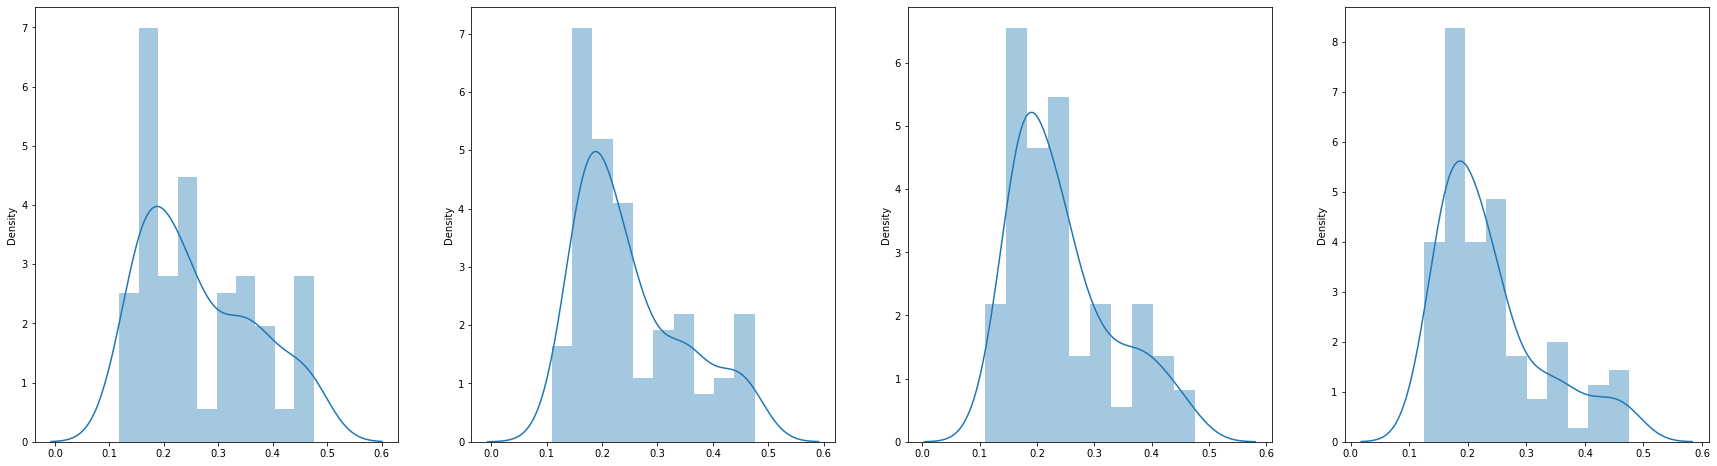

0 ITOT 0.09683991105054233 0.2543392446637154
1 SOXX 0.08383641720297359 0.23435573898255824
2 TLH 0.10971665935080702 0.25505585744977
3 VNQ 0.10330156255708371 0.2562491547316313


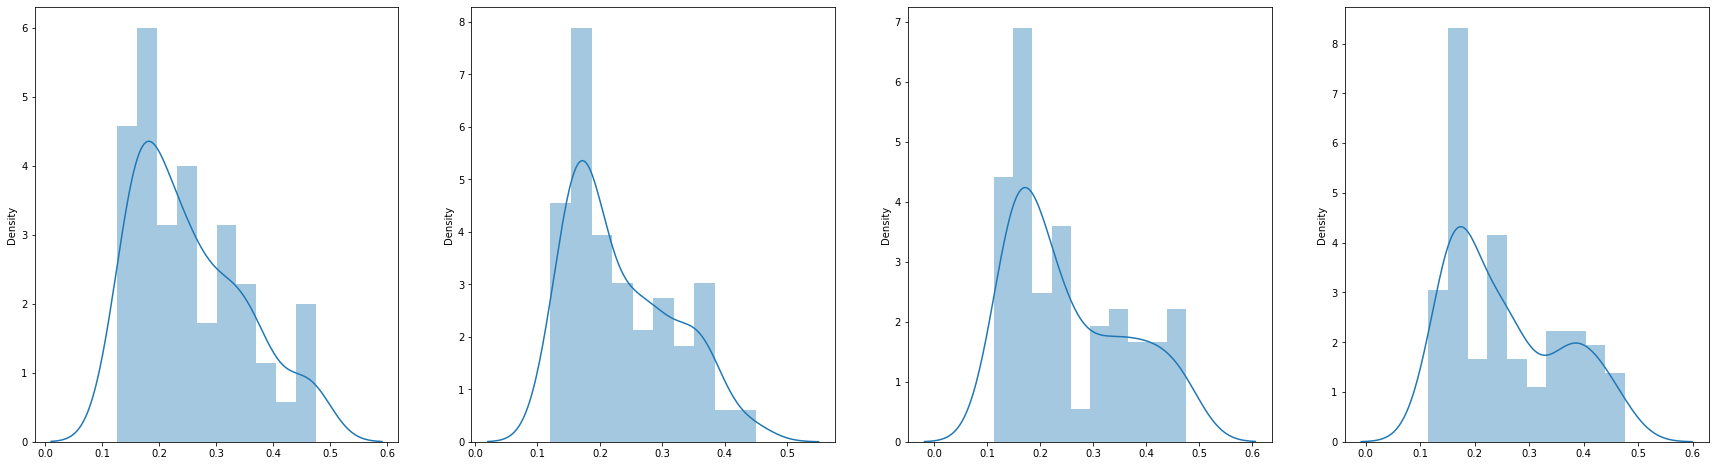

old_etfs: ['ITOT', 'SOXX', 'VNQ', 'TLH']
detect [['2016-01-07', 'SOXX', 0.10773839367551744, 0.26824272342026234], ['2016-05-02', 'TLH', 0.10998225122475855, 0.2725541366636753], ['2016-08-04', 'SOXX', 0.10683847569964593, 0.25184301532804965], ['2016-11-07', 'ITOT', 0.10641365680193428, 0.2802797869592905], ['2017-10-31', 'TLH', 0.10654394680308323, 0.2701560425758362], ['2018-08-28', 'SOXX', 0.10732196979764606, 0.2514498620480299], ['2019-08-27', 'TLH', 0.109716659350807, 0.25505585744977], ['2019-12-24', 'VNQ', 0.11035737804087639, 0.2692346388101578], ['2020-03-31', 'TLH', 0.10862015778269134, 0.27011655740439894], ['2020-06-26', 'SOXX', 0.106831798988189, 0.26276860624551773]]
ITOT ['ITOT', 'SOXX', 'VNQ', 'TLH']
VEU ['ITOT', 'SOXX', 'VNQ', 'TLH']
VEUnot in comb
['ITOT', 'VEU', 'VNQ', 'TLH']
2019-06-26 2019-08-27
2019-06-27
2019-06-28
2019-06-29
2019-06-29 no trade
2019-06-30 no trade
2019-07-02
2019-07-03
2019-07-04
2019-07-04 no trade
2019-07-06
2019-07-06 no trade
2019-07-07 no

['ITOT', 'SOXX', 'VNQ', 'QCLN']
['ITOT', 'SOXX', 'VNQ', 'IGM']
['ITOT', 'SOXX', 'VNQ', 'HYMB']
['ITOT', 'SOXX', 'VNQ', 'XHE']
['ITOT', 'SOXX', 'VNQ', 'EMSH']
['ITOT', 'SOXX', 'VNQ', 'GII']
['ITOT', 'SOXX', 'VNQ', 'RPV']
['ITOT', 'SOXX', 'VNQ', 'EZM']
['ITOT', 'SOXX', 'VNQ', 'HEWW']
['ITOT', 'SOXX', 'VNQ', 'VMBS']
['ITOT', 'SOXX', 'VNQ', 'JXI']
['ITOT', 'SOXX', 'VNQ', 'SDIV']
['ITOT', 'SOXX', 'VNQ', 'BSCM']
['ITOT', 'SOXX', 'VNQ', 'DBO']
['ITOT', 'SOXX', 'VNQ', 'WBIG']
['ITOT', 'SOXX', 'VNQ', 'PTNQ']
['ITOT', 'SOXX', 'VNQ', 'IQLT']
['ITOT', 'SOXX', 'VNQ', 'MZZ']
['ITOT', 'SOXX', 'VNQ', 'LTL']
['ITOT', 'SOXX', 'VNQ', 'VAW']
['ITOT', 'SOXX', 'VNQ', 'IWX']
['ITOT', 'SOXX', 'VNQ', 'FNDB']
['ITOT', 'SOXX', 'VNQ', 'CMBS']
['ITOT', 'SOXX', 'VNQ', 'JHML']
['ITOT', 'SOXX', 'VNQ', 'QID']
['ITOT', 'SOXX', 'VNQ', 'EWD']
['ITOT', 'SOXX', 'VNQ', 'OEF']
['ITOT', 'SOXX', 'VNQ', 'SPXE']
['ITOT', 'SOXX', 'VNQ', 'URTY']
['ITOT', 'SOXX', 'VNQ', 'XSVM']
['ITOT', 'SOXX', 'VNQ', 'SRTY']
['ITOT', 'SOXX', 'VNQ'

['ITOT', 'SOXX', 'VNQ', 'QMOM']
['ITOT', 'SOXX', 'VNQ', 'ISRA']
['ITOT', 'SOXX', 'VNQ', 'EEMA']
['ITOT', 'SOXX', 'VNQ', 'SPMB']
['ITOT', 'SOXX', 'VNQ', 'FWDB']
['ITOT', 'SOXX', 'VNQ', 'SYLD']
['ITOT', 'SOXX', 'VNQ', 'GMF']
['ITOT', 'SOXX', 'VNQ', 'IDX']
['ITOT', 'SOXX', 'VNQ', 'IVOO']
['ITOT', 'SOXX', 'VNQ', 'IAGG']
['ITOT', 'SOXX', 'VNQ', 'IGLB']
['ITOT', 'SOXX', 'VNQ', 'EFV']
['ITOT', 'SOXX', 'VNQ', 'ICSH']
['ITOT', 'SOXX', 'VNQ', 'ISHG']
['ITOT', 'SOXX', 'VNQ', 'XLE']
['ITOT', 'SOXX', 'VNQ', 'SMLF']
['ITOT', 'SOXX', 'VNQ', 'FJP']
['ITOT', 'SOXX', 'VNQ', 'KFYP']
['ITOT', 'SOXX', 'VNQ', 'ROAM']
['ITOT', 'SOXX', 'VNQ', 'DPST']
['ITOT', 'SOXX', 'VNQ', 'VTV']
['ITOT', 'SOXX', 'VNQ', 'UTES']
['ITOT', 'SOXX', 'VNQ', 'TBF']
['ITOT', 'SOXX', 'VNQ', 'RWM']
['ITOT', 'SOXX', 'VNQ', 'SRLN']
['ITOT', 'SOXX', 'VNQ', 'RDOG']
['ITOT', 'SOXX', 'VNQ', 'QUAL']
['ITOT', 'SOXX', 'VNQ', 'EMBH']
['ITOT', 'SOXX', 'VNQ', 'SEF']
['ITOT', 'SOXX', 'VNQ', 'CEW']
['ITOT', 'SOXX', 'VNQ', 'VDC']
['ITOT', 'SOXX', 'V

['ITOT', 'SOXX', 'VNQ', 'NAIL']
['ITOT', 'SOXX', 'VNQ', 'LBJ']
['ITOT', 'SOXX', 'VNQ', 'DES']
['ITOT', 'SOXX', 'VNQ', 'EWJ']
['ITOT', 'SOXX', 'VNQ', 'CHIE']
['ITOT', 'SOXX', 'VNQ', 'GLCN']
['ITOT', 'SOXX', 'VNQ', 'EMLP']
['ITOT', 'SOXX', 'VNQ', 'TYO']
['ITOT', 'SOXX', 'VNQ', 'IAK']
['ITOT', 'SOXX', 'VNQ', 'EPOL']
['ITOT', 'SOXX', 'VNQ', 'HEEM']
['ITOT', 'SOXX', 'VNQ', 'PXE']
['ITOT', 'SOXX', 'VNQ', 'EINC']
['ITOT', 'SOXX', 'VNQ', 'SMEZ']
['ITOT', 'SOXX', 'VNQ', 'BKF']
['ITOT', 'SOXX', 'VNQ', 'ADRE']
['ITOT', 'SOXX', 'VNQ', 'GEM']
['ITOT', 'SOXX', 'VNQ', 'INDA']
['ITOT', 'SOXX', 'VNQ', 'BJK']
['ITOT', 'SOXX', 'VNQ', 'MUNI']
['ITOT', 'SOXX', 'VNQ', 'DIVA']
['ITOT', 'SOXX', 'VNQ', 'XHB']
['ITOT', 'SOXX', 'VNQ', 'PXQ']
['ITOT', 'SOXX', 'VNQ', 'ONEQ']
['ITOT', 'SOXX', 'VNQ', 'VOOV']
['ITOT', 'SOXX', 'VNQ', 'USRT']
['ITOT', 'SOXX', 'VNQ', 'SZK']
abc ok
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**

begin_total_asset:1000000
end_total_asset:1130736.245853937
Sharpe:  0.1887085660774142
hit end!
42
begin_total_asset:1000000
end_total_asset:1667750.8001884397
Sharpe:  0.44861616163808804
hit end!
43
begin_total_asset:1000000
end_total_asset:1607527.762102444
Sharpe:  0.4266172372166183
hit end!
44
begin_total_asset:1000000
end_total_asset:1883841.977183118
Sharpe:  0.5081343486047192
hit end!
45
begin_total_asset:1000000
end_total_asset:2127152.6602851786
Sharpe:  0.583049796688408
hit end!
46
begin_total_asset:1000000
end_total_asset:1583421.4230651413
Sharpe:  0.4011677065993085
hit end!
47
begin_total_asset:1000000
end_total_asset:1359560.907135583
Sharpe:  0.3058490199916633
hit end!
48
begin_total_asset:1000000
end_total_asset:1642010.105704581
Sharpe:  0.426827513739566
hit end!
49
begin_total_asset:1000000
end_total_asset:1345456.967251832
Sharpe:  0.30672652189292593
hit end!
50
begin_total_asset:1000000
end_total_asset:1855453.129828813
Sharpe:  0.530253829159625
hit end!
5

begin_total_asset:1000000
end_total_asset:1217422.4503021387
Sharpe:  0.2400181233022874
hit end!
91
begin_total_asset:1000000
end_total_asset:1556112.0975439274
Sharpe:  0.3959983487756904
hit end!
92
begin_total_asset:1000000
end_total_asset:1829601.9345466492
Sharpe:  0.5237854617294708
hit end!
93
begin_total_asset:1000000
end_total_asset:1823709.4684796806
Sharpe:  0.5075108091255081
hit end!
94
begin_total_asset:1000000
end_total_asset:2111104.6038705846
Sharpe:  0.6019208356172657
hit end!
95
begin_total_asset:1000000
end_total_asset:1206522.8674659843
Sharpe:  0.23044685597870468
hit end!
96
begin_total_asset:1000000
end_total_asset:1812174.9178931413
Sharpe:  0.549195330952936
hit end!
97
begin_total_asset:1000000
end_total_asset:1493026.7138522952
Sharpe:  0.3716833196787152
hit end!
98
begin_total_asset:1000000
end_total_asset:1291777.604984595
Sharpe:  0.28408106994297183
hit end!
99
begin_total_asset:1000000
end_total_asset:1123674.6316726445
Sharpe:  0.18270902132152608
h

begin_total_asset:1000000
end_total_asset:1197947.3914133147
Sharpe:  0.34970808680616716
hit end!
40
begin_total_asset:1000000
end_total_asset:1237910.4232410588
Sharpe:  0.41922026969896475
hit end!
41
begin_total_asset:1000000
end_total_asset:1299884.546414771
Sharpe:  0.5104106142975939
hit end!
42
begin_total_asset:1000000
end_total_asset:1139794.1827089228
Sharpe:  0.2837064163894858
hit end!
43
begin_total_asset:1000000
end_total_asset:1401108.6389555775
Sharpe:  0.6231976852826819
hit end!
44
begin_total_asset:1000000
end_total_asset:1260816.440353365
Sharpe:  0.449675250995641
hit end!
45
begin_total_asset:1000000
end_total_asset:1746930.4594790146
Sharpe:  0.9995811294982838
hit end!
46
begin_total_asset:1000000
end_total_asset:1285396.527089433
Sharpe:  0.468172418964283
hit end!
47
begin_total_asset:1000000
end_total_asset:1314821.6644613598
Sharpe:  0.5212508061007317
hit end!
48
begin_total_asset:1000000
end_total_asset:1523048.3164520094
Sharpe:  0.8001869441485342
hit e

begin_total_asset:1000000
end_total_asset:1326053.2576125653
Sharpe:  0.5300286034503974
hit end!
89
begin_total_asset:1000000
end_total_asset:1588666.850759602
Sharpe:  0.8923844361739616
hit end!
90
begin_total_asset:1000000
end_total_asset:1013132.9586891228
Sharpe:  0.0799693986883365
hit end!
91
begin_total_asset:1000000
end_total_asset:1376623.3589920595
Sharpe:  0.5563527186759153
hit end!
92
begin_total_asset:1000000
end_total_asset:1482944.2450417741
Sharpe:  0.7192194294131111
hit end!
93
begin_total_asset:1000000
end_total_asset:1173253.74917015
Sharpe:  0.32922654278290864
hit end!
94
begin_total_asset:1000000
end_total_asset:1386316.601888883
Sharpe:  0.6173481560454209
hit end!
95
begin_total_asset:1000000
end_total_asset:1524167.2851762965
Sharpe:  0.7425800612401849
hit end!
96
begin_total_asset:1000000
end_total_asset:1449360.8024979485
Sharpe:  0.7173789887987262
hit end!
97
begin_total_asset:1000000
end_total_asset:1310839.4271779817
Sharpe:  0.5405255217266465
hit e

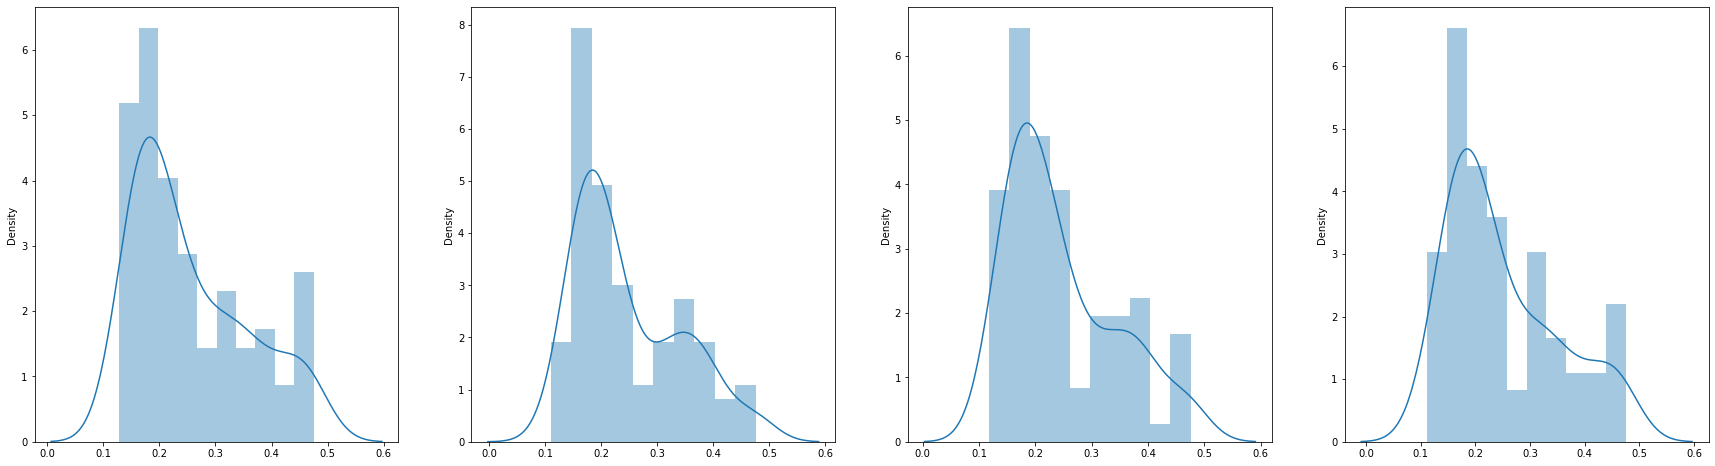

0 ITOT 0.08154494641449456 0.2470750530809164
1 SOXX 0.10644934880945267 0.2736826456338167
2 SZK 0.08867479746149168 0.23821189559996128
3 VNQ 0.09225882617683448 0.24103040300309658


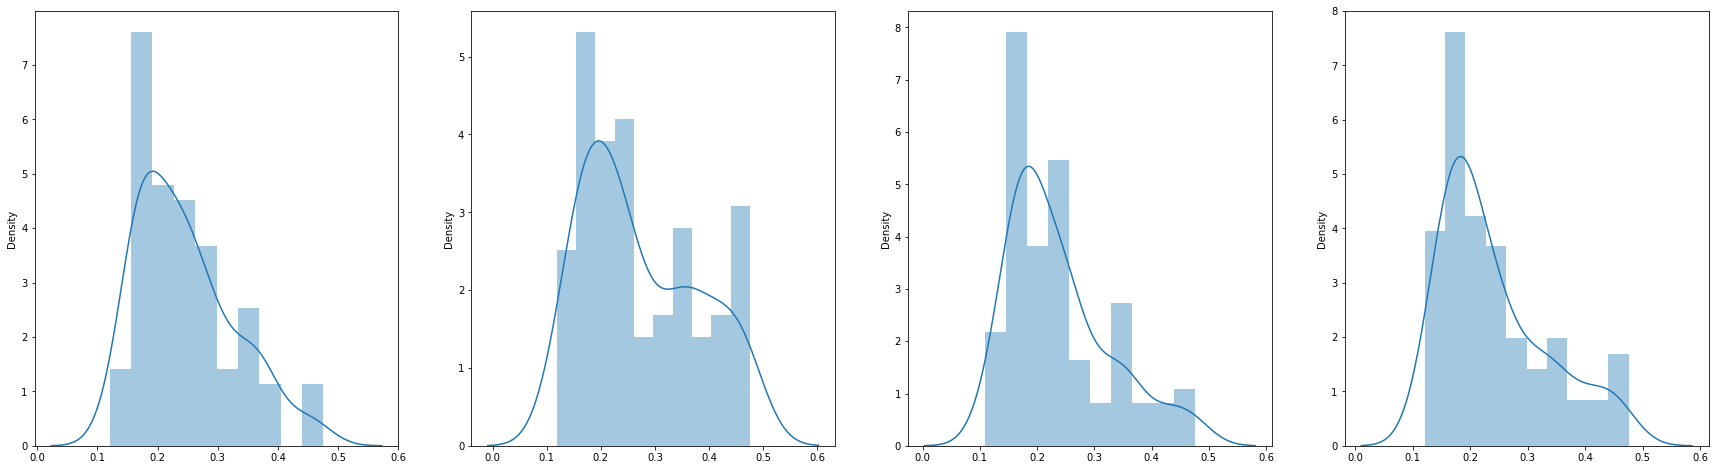

old_etfs: ['ITOT', 'SOXX', 'VNQ', 'SZK']
detect [['2016-11-18', 'ITOT', 0.10711197501636974, 0.24444338850677014], ['2017-01-17', 'ITOT', 0.10690311236165402, 0.26740172795951367], ['2017-01-23', 'SZK', 0.10830756688109053, 0.2791966688632965], ['2017-04-03', 'VNQ', 0.10684869891200177, 0.2549969532340765], ['2017-04-10', 'SZK', 0.10651233034109328, 0.26639182575047016], ['2017-10-05', 'ITOT', 0.10624862703837482, 0.2555952462553978], ['2017-10-13', 'SOXX', 0.10742882491612443, 0.26382324159145354], ['2017-11-21', 'VNQ', 0.10698978276223661, 0.2672743270546198], ['2018-01-22', 'ITOT', 0.10681903675583891, 0.2593852367997169], ['2018-05-21', 'SZK', 0.10738790058195859, 0.2597109818458557], ['2018-07-06', 'SZK', 0.10621539534560426, 0.2678289346396923], ['2018-08-13', 'VNQ', 0.10619544928856565, 0.2672537709027529], ['2018-09-10', 'ITOT', 0.10631529622169761, 0.25935336329042913], ['2018-09-26', 'SOXX', 0.1062566758289107, 0.26703219711780546], ['2018-12-12', 'VNQ', 0.10798045366324226, 

['ITOT', 'BND', 'VNQ', 'SZK']
['ITOT', 'EEMA', 'VNQ', 'SZK']
['ITOT', 'ROBO', 'VNQ', 'SZK']
['ITOT', 'KWEB', 'VNQ', 'SZK']
['ITOT', 'TPYP', 'VNQ', 'SZK']
['ITOT', 'LD', 'VNQ', 'SZK']
['ITOT', 'RHS', 'VNQ', 'SZK']
['ITOT', 'IHF', 'VNQ', 'SZK']
['ITOT', 'PFF', 'VNQ', 'SZK']
['ITOT', 'EUDG', 'VNQ', 'SZK']
['ITOT', 'PSR', 'VNQ', 'SZK']
['ITOT', 'CSM', 'VNQ', 'SZK']
['ITOT', 'FXG', 'VNQ', 'SZK']
['ITOT', 'JKL', 'VNQ', 'SZK']
['ITOT', 'EPOL', 'VNQ', 'SZK']
['ITOT', 'BLV', 'VNQ', 'SZK']
['ITOT', 'SMDD', 'VNQ', 'SZK']
['ITOT', 'EEMO', 'VNQ', 'SZK']
['ITOT', 'VFH', 'VNQ', 'SZK']
['ITOT', 'ALTS', 'VNQ', 'SZK']
['ITOT', 'BRF', 'VNQ', 'SZK']
['ITOT', 'BSJN', 'VNQ', 'SZK']
['ITOT', 'TIPZ', 'VNQ', 'SZK']
['ITOT', 'OEF', 'VNQ', 'SZK']
['ITOT', 'GMF', 'VNQ', 'SZK']
['ITOT', 'XNTK', 'VNQ', 'SZK']
['ITOT', 'FEZ', 'VNQ', 'SZK']
['ITOT', 'IEZ', 'VNQ', 'SZK']
['ITOT', 'REMX', 'VNQ', 'SZK']
['ITOT', 'LABD', 'VNQ', 'SZK']
['ITOT', 'ZROZ', 'VNQ', 'SZK']
['ITOT', 'XMVM', 'VNQ', 'SZK']
['ITOT', 'VONG', 'VNQ', '

begin_total_asset:1000000
end_total_asset:1323728.5248355248
Sharpe:  0.28671405861470944
hit end!
2
begin_total_asset:1000000
end_total_asset:1819877.3982293082
Sharpe:  0.49610416217707015
hit end!
3
begin_total_asset:1000000
end_total_asset:1725741.5470050185
Sharpe:  0.47092583199500515
hit end!
4
begin_total_asset:1000000
end_total_asset:1213217.4419830765
Sharpe:  0.2361070218269609
hit end!
5
begin_total_asset:1000000
end_total_asset:1162871.383653984
Sharpe:  0.20937185950621812
hit end!
6
begin_total_asset:1000000
end_total_asset:1919534.4165149545
Sharpe:  0.5376509276382173
hit end!
7
begin_total_asset:1000000
end_total_asset:1578058.84833623
Sharpe:  0.39705726417030546
hit end!
8
begin_total_asset:1000000
end_total_asset:1768494.9771312457
Sharpe:  0.5170830617561744
hit end!
9
begin_total_asset:1000000
end_total_asset:1308492.3162589099
Sharpe:  0.28933654910187334
hit end!
10
begin_total_asset:1000000
end_total_asset:2356230.3598022657
Sharpe:  0.6815556808943224
hit end

begin_total_asset:1000000
end_total_asset:1337614.1506073922
Sharpe:  0.3052165690531635
hit end!
51
begin_total_asset:1000000
end_total_asset:1368533.5548388567
Sharpe:  0.33900235146482116
hit end!
52
begin_total_asset:1000000
end_total_asset:1154847.8675413164
Sharpe:  0.20230472804269545
hit end!
53
begin_total_asset:1000000
end_total_asset:1463825.89577011
Sharpe:  0.36059021653275053
hit end!
54
begin_total_asset:1000000
end_total_asset:1540263.4948110953
Sharpe:  0.4070302295407431
hit end!
55
begin_total_asset:1000000
end_total_asset:1615934.2070540716
Sharpe:  0.4362727306447775
hit end!
56
begin_total_asset:1000000
end_total_asset:1808559.2853352947
Sharpe:  0.4973797450442007
hit end!
57
begin_total_asset:1000000
end_total_asset:1676820.570087328
Sharpe:  0.46406067410439583
hit end!
58
begin_total_asset:1000000
end_total_asset:1687762.1398393055
Sharpe:  0.45361982063887796
hit end!
59
begin_total_asset:1000000
end_total_asset:1612611.5429391975
Sharpe:  0.4163786681386128


begin_total_asset:1000000
end_total_asset:1426601.0459462851
Sharpe:  0.3546031752886868
hit end!
thresh= 0.1061338382306317
0
begin_total_asset:1000000
end_total_asset:1120688.645242046
Sharpe:  0.2746727455020836
hit end!
1
begin_total_asset:1000000
end_total_asset:1224583.0646398852
Sharpe:  0.43007225450438186
hit end!
2
begin_total_asset:1000000
end_total_asset:1047313.2391838476
Sharpe:  0.1398138918926031
hit end!
3
begin_total_asset:1000000
end_total_asset:1149003.4321061054
Sharpe:  0.3151698395252624
hit end!
4
begin_total_asset:1000000
end_total_asset:1074544.2252048212
Sharpe:  0.18731049556464016
hit end!
5
begin_total_asset:1000000
end_total_asset:1065929.3201752305
Sharpe:  0.17164352100601993
hit end!
6
begin_total_asset:1000000
end_total_asset:915470.148276067
Sharpe:  -0.09598705426606836
hit end!
7
begin_total_asset:1000000
end_total_asset:1028363.271815768
Sharpe:  0.10608942563274716
hit end!
8
begin_total_asset:1000000
end_total_asset:1243466.9663363523
Sharpe:  0

begin_total_asset:1000000
end_total_asset:954938.4288122469
Sharpe:  -0.03158581381923884
hit end!
49
begin_total_asset:1000000
end_total_asset:1248796.457728896
Sharpe:  0.4577138199262612
hit end!
50
begin_total_asset:1000000
end_total_asset:1314013.1987412835
Sharpe:  0.5835501043442078
hit end!
51
begin_total_asset:1000000
end_total_asset:1221578.3105168736
Sharpe:  0.43413152761866647
hit end!
52
begin_total_asset:1000000
end_total_asset:1203676.5313495276
Sharpe:  0.3898314345783354
hit end!
53
begin_total_asset:1000000
end_total_asset:1080176.8309427437
Sharpe:  0.19431507569551684
hit end!
54
begin_total_asset:1000000
end_total_asset:1387313.8471229011
Sharpe:  0.6372631428966453
hit end!
55
begin_total_asset:1000000
end_total_asset:1591611.7967748896
Sharpe:  0.9037093639943486
hit end!
56
begin_total_asset:1000000
end_total_asset:1115263.0090578904
Sharpe:  0.2552754124999968
hit end!
57
begin_total_asset:1000000
end_total_asset:1446533.7377272758
Sharpe:  0.7909396160862007


begin_total_asset:1000000
end_total_asset:1234371.751930449
Sharpe:  0.44690664061378294
hit end!
98
begin_total_asset:1000000
end_total_asset:1078006.8433921877
Sharpe:  0.19958040401184768
hit end!
99
begin_total_asset:1000000
end_total_asset:1173119.4832272208
Sharpe:  0.3608790543513617
hit end!
detect_new [['2016-03-30', 'SZK', 0.10795850861881308, 0.2694735585153103], ['2016-07-07', 'VNQ', 0.10901946723683845, 0.2660897923260927], ['2016-10-27', 'ITOT', 0.10739757753202209, 0.2716727389395237], ['2017-05-08', 'RYT', 0.10750210886081431, 0.25639768563210963], ['2017-11-07', 'ITOT', 0.1079624591500076, 0.2697722664475441], ['2019-06-28', 'RYT', 0.10682974432785587, 0.2542099657654762], ['2020-07-09', 'SZK', 0.11058612047625656, 0.2665571533888578], ['2020-12-03', 'VNQ', 0.11141917498715548, 0.2624134092032909]]
detect_latest ['2020-07-09', 'SZK', 0.11058612047625656, 0.2665571533888578]
['ITOT', 'RYT', 'VNQ', 'SZK'] successed normal@ 2020-01-03
1007      0.210757
2266      0.187361

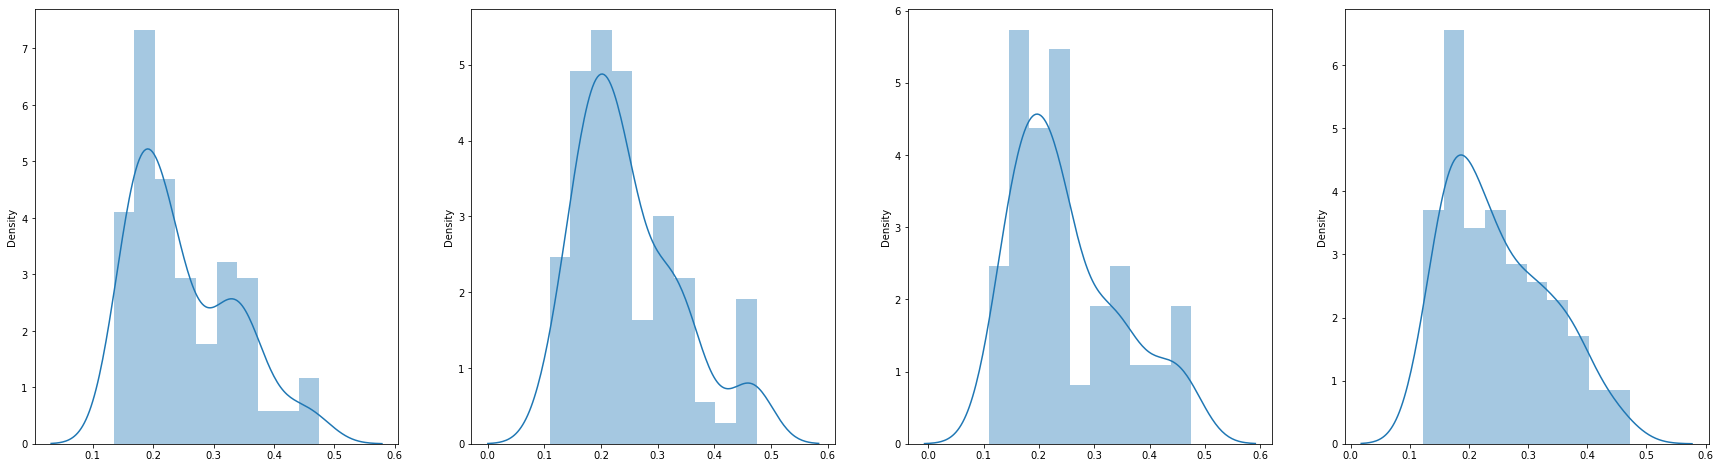

0 ITOT 0.0991277125892423 0.2511416245251894
1 RYT 0.08712741433006484 0.2409229561686516
2 SZK 0.11058612047625659 0.2665571533888578
3 VNQ 0.09298297748412603 0.24137826763093473


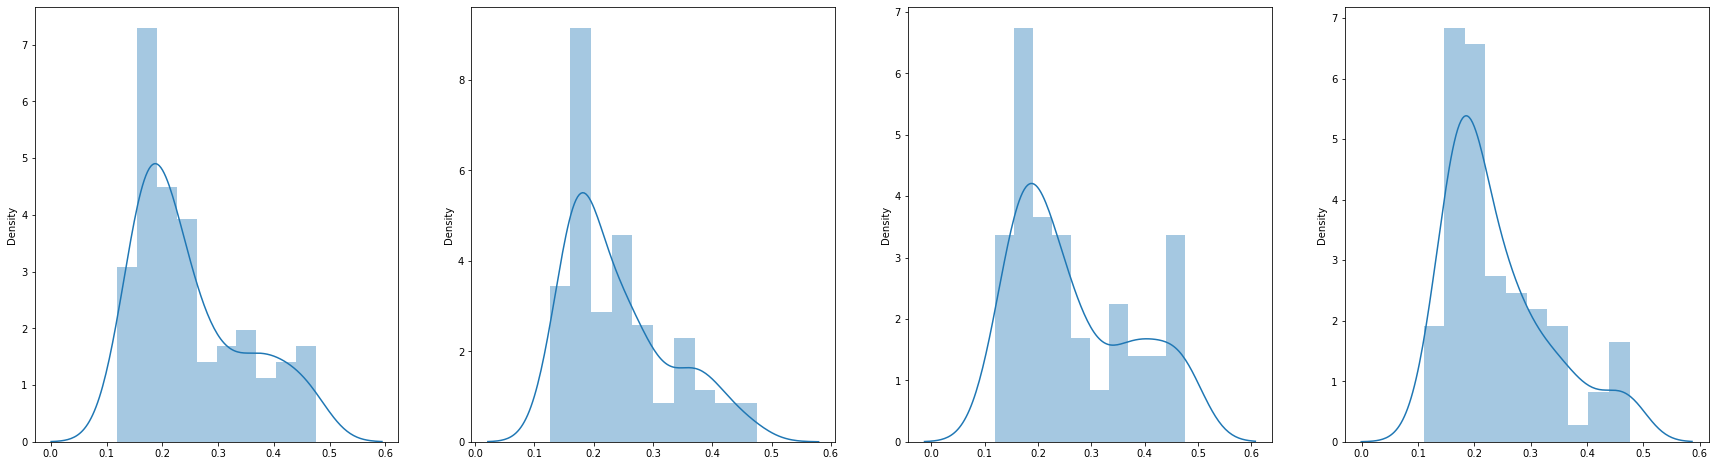

old_etfs: ['ITOT', 'RYT', 'VNQ', 'SZK']
detect [['2016-03-30', 'SZK', 0.10795850861881308, 0.2694735585153103], ['2016-07-07', 'VNQ', 0.10901946723683845, 0.2660897923260927], ['2016-10-27', 'ITOT', 0.10739757753202209, 0.2716727389395237], ['2017-05-08', 'RYT', 0.10750210886081431, 0.25639768563210963], ['2017-11-07', 'ITOT', 0.1079624591500076, 0.2697722664475441], ['2019-06-28', 'RYT', 0.10682974432785587, 0.2542099657654762], ['2020-07-09', 'SZK', 0.11058612047625656, 0.2665571533888578], ['2020-12-03', 'VNQ', 0.11141917498715548, 0.2624134092032909]]
ITOT ['ITOT', 'RYT', 'VNQ', 'SZK']
VEU ['ITOT', 'RYT', 'VNQ', 'SZK']
VEUnot in comb
['ITOT', 'VEU', 'VNQ', 'SZK']
2020-01-04 2020-07-09
2020-01-04 no trade
2020-01-05 no trade
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-11
2020-01-11 no trade
2020-01-12 no trade
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-18
2020-01-18 no trade
2020-01-19 no trade
2020-01-20 no trade
2020-01-22
2020-01-23
2020-01-24
2020-01-25
2020-01-

['ITOT', 'RYT', 'VNQ', 'FID']
['ITOT', 'RYT', 'VNQ', 'NYF']
['ITOT', 'RYT', 'VNQ', 'VEA']
['ITOT', 'RYT', 'VNQ', 'ULST']
['ITOT', 'RYT', 'VNQ', 'SDD']
['ITOT', 'RYT', 'VNQ', 'VBK']
['ITOT', 'RYT', 'VNQ', 'VBR']
['ITOT', 'RYT', 'VNQ', 'DIVA']
['ITOT', 'RYT', 'VNQ', 'FBGX']
['ITOT', 'RYT', 'VNQ', 'IPO']
['ITOT', 'RYT', 'VNQ', 'CWI']
['ITOT', 'RYT', 'VNQ', 'LVHD']
['ITOT', 'RYT', 'VNQ', 'TMF']
['ITOT', 'RYT', 'VNQ', 'JKJ']
['ITOT', 'RYT', 'VNQ', 'SYV']
['ITOT', 'RYT', 'VNQ', 'CIZ']
['ITOT', 'RYT', 'VNQ', 'PSCU']
['ITOT', 'RYT', 'VNQ', 'IJR']
['ITOT', 'RYT', 'VNQ', 'EMSH']
['ITOT', 'RYT', 'VNQ', 'VLU']
['ITOT', 'RYT', 'VNQ', 'SOYB']
['ITOT', 'RYT', 'VNQ', 'INKM']
['ITOT', 'RYT', 'VNQ', 'CRBN']
['ITOT', 'RYT', 'VNQ', 'FSZ']
['ITOT', 'RYT', 'VNQ', 'ITM']
['ITOT', 'RYT', 'VNQ', 'FBND']
['ITOT', 'RYT', 'VNQ', 'ECON']
['ITOT', 'RYT', 'VNQ', 'IYF']
['ITOT', 'RYT', 'VNQ', 'SCHH']
['ITOT', 'RYT', 'VNQ', 'REM']
['ITOT', 'RYT', 'VNQ', 'RTM']
['ITOT', 'RYT', 'VNQ', 'PTF']
['ITOT', 'RYT', 'VNQ', 'CHIC

['ITOT', 'RYT', 'VNQ', 'PCY']
['ITOT', 'RYT', 'VNQ', 'PSR']
['ITOT', 'RYT', 'VNQ', 'DRW']
['ITOT', 'RYT', 'VNQ', 'DDIV']
['ITOT', 'RYT', 'VNQ', 'IWR']
['ITOT', 'RYT', 'VNQ', 'IDLB']
['ITOT', 'RYT', 'VNQ', 'EMGF']
['ITOT', 'RYT', 'VNQ', 'MBSD']
['ITOT', 'RYT', 'VNQ', 'PSCT']
['ITOT', 'RYT', 'VNQ', 'CIBR']
['ITOT', 'RYT', 'VNQ', 'SPMO']
['ITOT', 'RYT', 'VNQ', 'DTD']
['ITOT', 'RYT', 'VNQ', 'SPGM']
['ITOT', 'RYT', 'VNQ', 'SMCP']
['ITOT', 'RYT', 'VNQ', 'TAGS']
['ITOT', 'RYT', 'VNQ', 'BFOR']
['ITOT', 'RYT', 'VNQ', 'EPOL']
['ITOT', 'RYT', 'VNQ', 'EEV']
['ITOT', 'RYT', 'VNQ', 'IGN']
['ITOT', 'RYT', 'VNQ', 'EFZ']
['ITOT', 'RYT', 'VNQ', 'VGLT']
['ITOT', 'RYT', 'VNQ', 'SCHO']
['ITOT', 'RYT', 'VNQ', 'IJS']
['ITOT', 'RYT', 'VNQ', 'JNK']
['ITOT', 'RYT', 'VNQ', 'FM']
['ITOT', 'RYT', 'VNQ', 'ONEY']
['ITOT', 'RYT', 'VNQ', 'PSCE']
['ITOT', 'RYT', 'VNQ', 'TOTL']
['ITOT', 'RYT', 'VNQ', 'MIDU']
['ITOT', 'RYT', 'VNQ', 'PIZ']
['ITOT', 'RYT', 'VNQ', 'IVAL']
['ITOT', 'RYT', 'VNQ', 'IWO']
['ITOT', 'RYT', 'VNQ',

['ITOT', 'RYT', 'VNQ', 'HDAW']
['ITOT', 'RYT', 'VNQ', 'EWU']
['ITOT', 'RYT', 'VNQ', 'FRI']
['ITOT', 'RYT', 'VNQ', 'SDOG']
['ITOT', 'RYT', 'VNQ', 'DLS']
['ITOT', 'RYT', 'VNQ', 'PXQ']
['ITOT', 'RYT', 'VNQ', 'JKG']
['ITOT', 'RYT', 'VNQ', 'SPMB']
['ITOT', 'RYT', 'VNQ', 'IHF']
['ITOT', 'RYT', 'VNQ', 'RJZ']
['ITOT', 'RYT', 'VNQ', 'SPTM']
['ITOT', 'RYT', 'VNQ', 'NOBL']
['ITOT', 'RYT', 'VNQ', 'QDEF']
['ITOT', 'RYT', 'VNQ', 'XLK']
['ITOT', 'RYT', 'VNQ', 'IPKW']
['ITOT', 'RYT', 'VNQ', 'VOOV']
['ITOT', 'RYT', 'VNQ', 'XLF']
['ITOT', 'RYT', 'VNQ', 'RYJ']
['ITOT', 'RYT', 'VNQ', 'SPY']
['ITOT', 'RYT', 'VNQ', 'QCLN']
['ITOT', 'RYT', 'VNQ', 'VYM']
['ITOT', 'RYT', 'VNQ', 'PIE']
['ITOT', 'RYT', 'VNQ', 'QEFA']
['ITOT', 'RYT', 'VNQ', 'IVOG']
['ITOT', 'RYT', 'VNQ', 'FHLC']
['ITOT', 'RYT', 'VNQ', 'DBV']
['ITOT', 'RYT', 'VNQ', 'TYO']
['ITOT', 'RYT', 'VNQ', 'DEM']
['ITOT', 'RYT', 'VNQ', 'ALFA']
['ITOT', 'RYT', 'VNQ', 'VONG']
['ITOT', 'RYT', 'VNQ', 'XVZ']
['ITOT', 'RYT', 'VNQ', 'BKF']
['ITOT', 'RYT', 'VNQ', 'EW

['ITOT', 'RYT', 'VNQ', 'ITB']
['ITOT', 'RYT', 'VNQ', 'JHMH']
['ITOT', 'RYT', 'VNQ', 'UGL']
['ITOT', 'RYT', 'VNQ', 'USRT']
['ITOT', 'RYT', 'VNQ', 'ZROZ']
['ITOT', 'RYT', 'VNQ', 'UMDD']
['ITOT', 'RYT', 'VNQ', 'XRT']
['ITOT', 'RYT', 'VNQ', 'FIBR']
['ITOT', 'RYT', 'VNQ', 'MUB']
['ITOT', 'RYT', 'VNQ', 'SPMD']
['ITOT', 'RYT', 'VNQ', 'IUSV']
['ITOT', 'RYT', 'VNQ', 'IJT']
['ITOT', 'RYT', 'VNQ', 'SPXU']
['ITOT', 'RYT', 'VNQ', 'VEGA']
['ITOT', 'RYT', 'VNQ', 'PJP']
['ITOT', 'RYT', 'VNQ', 'RYH']
['ITOT', 'RYT', 'VNQ', 'JPXN']
['ITOT', 'RYT', 'VNQ', 'VO']
['ITOT', 'RYT', 'VNQ', 'QYLD']
['ITOT', 'RYT', 'VNQ', 'DGT']
['ITOT', 'RYT', 'VNQ', 'VOOG']
['ITOT', 'RYT', 'VNQ', 'PXF']
['ITOT', 'RYT', 'VNQ', 'TOK']
['ITOT', 'RYT', 'VNQ', 'FEM']
['ITOT', 'RYT', 'VNQ', 'RPG']
['ITOT', 'RYT', 'VNQ', 'VIDI']
['ITOT', 'RYT', 'VNQ', 'IYY']
['ITOT', 'RYT', 'VNQ', 'FDL']
['ITOT', 'RYT', 'VNQ', 'MUNI']
['ITOT', 'RYT', 'VNQ', 'RTH']
['ITOT', 'RYT', 'VNQ', 'NFLT']
['ITOT', 'RYT', 'VNQ', 'VAMO']
['ITOT', 'RYT', 'VNQ', 'I

['ITOT', 'RYT', 'VNQ', 'YLD']
['ITOT', 'RYT', 'VNQ', 'PYZ']
['ITOT', 'RYT', 'VNQ', 'GCC']
['ITOT', 'RYT', 'VNQ', 'MRGR']
['ITOT', 'RYT', 'VNQ', 'SMLF']
['ITOT', 'RYT', 'VNQ', 'IXUS']
['ITOT', 'RYT', 'VNQ', 'XBI']
['ITOT', 'RYT', 'VNQ', 'FPX']
['ITOT', 'RYT', 'VNQ', 'SHM']
['ITOT', 'RYT', 'VNQ', 'EMIF']
['ITOT', 'RYT', 'VNQ', 'SPLB']
['ITOT', 'RYT', 'VNQ', 'DBEF']
['ITOT', 'RYT', 'VNQ', 'IGM']
['ITOT', 'RYT', 'VNQ', 'QTEC']
['ITOT', 'RYT', 'VNQ', 'GDXJ']
['ITOT', 'RYT', 'VNQ', 'SPAB']
['ITOT', 'RYT', 'VNQ', 'BDCZ']
['ITOT', 'RYT', 'VNQ', 'SPSM']
['ITOT', 'RYT', 'VNQ', 'FPA']
['ITOT', 'RYT', 'VNQ', 'PSCH']
['ITOT', 'RYT', 'VNQ', 'DGRW']
['ITOT', 'RYT', 'VNQ', 'SSO']
['ITOT', 'RYT', 'VNQ', 'EUFX']
['ITOT', 'RYT', 'VNQ', 'LKOR']
['ITOT', 'RYT', 'VNQ', 'OUNZ']
['ITOT', 'RYT', 'VNQ', 'EWK']
['ITOT', 'RYT', 'VNQ', 'GYLD']
['ITOT', 'RYT', 'VNQ', 'GURU']
['ITOT', 'RYT', 'VNQ', 'IFGL']
['ITOT', 'RYT', 'VNQ', 'TLH']
['ITOT', 'RYT', 'VNQ', 'DBLV']
['ITOT', 'RYT', 'VNQ', 'XLRE']
['ITOT', 'RYT', 'VN

TypeError: 'NoneType' object is not subscriptable

In [123]:
# last_detect_date = '2016-01-13'
# detect = detect_record[1]
# detect_latest = ['2016-08-24', 'AGG', 0.10746809816091396, 0.2635297019779682]
while True:
    random.shuffle(all_etf)
    print('old_etfs:',old_etfs)
    print('detect',detect)
    trained_model,now_etfs,detect_new,detect_latest,last_detect_date = find_new_target(old_etfs,detect,detect_latest,trained_model,last_detect_date)
#     if now_etfs is None:
    
    detect_record.append(detect_new)
    detect_date_record.append(detect_latest[0])
    etf_record.append(now_etfs)
    
#     last_detect_date = detect_latest[0]
    old_etfs = now_etfs.copy()
    detect = detect_new
    
    textfile = open("./detect_record/detect_record.txt", "a")
    if count<10:
        textfile.write('model_0'+str(count)+'\n')
    else:
        textfile.write('model_'+str(count)+'\n')
    for dtct_r in detect:
        for kkk in range(len(dtct_r)):
            element = dtct_r[kkk]
#             print(element)
            textfile.write(str(element))
            if kkk<len(dtct_r)-1:
                textfile.write("\t")
            else:
                textfile.write("\n")
    textfile.close()
    
    textfile = open("./detect_record/detect_date_record.txt", "a")
    textfile.write(detect_latest[0]+'\n')
    textfile.close()
    
    count+=1
    if detect_latest==[]:
        break

old_etfs: ['ITOT', 'RYT', 'VNQ', 'SZK']
detect [['2016-03-30', 'SZK', 0.10795850861881308, 0.2694735585153103], ['2016-07-07', 'VNQ', 0.10901946723683845, 0.2660897923260927], ['2016-10-27', 'ITOT', 0.10739757753202209, 0.2716727389395237], ['2017-05-08', 'RYT', 0.10750210886081431, 0.25639768563210963], ['2017-11-07', 'ITOT', 0.1079624591500076, 0.2697722664475441], ['2019-06-28', 'RYT', 0.10682974432785587, 0.2542099657654762], ['2020-07-09', 'SZK', 0.11058612047625656, 0.2665571533888578], ['2020-12-03', 'VNQ', 0.11141917498715548, 0.2624134092032909]]
ITOT ['ITOT', 'RYT', 'VNQ', 'SZK']
VEU ['ITOT', 'RYT', 'VNQ', 'SZK']
VEUnot in comb
['ITOT', 'VEU', 'VNQ', 'SZK']
2020-07-10 2020-12-03
2020-07-11
2020-07-11 no trade
2020-07-12 no trade
2020-07-14
2020-07-15
2020-07-16
2020-07-17
2020-07-18
2020-07-18 no trade
2020-07-19 no trade
2020-07-21
2020-07-22
2020-07-23
2020-07-24
2020-07-25
2020-07-25 no trade
2020-07-26 no trade
2020-07-28
2020-07-29
2020-07-30
2020-07-31
2020-08-01
2020-0

['ITOT', 'RYT', 'XLK', 'SZK']
['ITOT', 'RYT', 'PSCE', 'SZK']
['ITOT', 'RYT', 'LVHD', 'SZK']
['ITOT', 'RYT', 'DBP', 'SZK']
['ITOT', 'RYT', 'GDXJ', 'SZK']
['ITOT', 'RYT', 'PXI', 'SZK']
['ITOT', 'RYT', 'XLRE', 'SZK']
['ITOT', 'RYT', 'ASHX', 'SZK']
['ITOT', 'RYT', 'MDY', 'SZK']
['ITOT', 'RYT', 'KXI', 'SZK']
['ITOT', 'RYT', 'TPYP', 'SZK']
['ITOT', 'RYT', 'REK', 'SZK']
['ITOT', 'RYT', 'KBA', 'SZK']
['ITOT', 'RYT', 'QID', 'SZK']
['ITOT', 'RYT', 'PSL', 'SZK']
['ITOT', 'RYT', 'SPEU', 'SZK']
['ITOT', 'RYT', 'TBT', 'SZK']
['ITOT', 'RYT', 'SPIB', 'SZK']
['ITOT', 'RYT', 'IAU', 'SZK']
['ITOT', 'RYT', 'LRGF', 'SZK']
['ITOT', 'RYT', 'PEJ', 'SZK']
['ITOT', 'RYT', 'DDG', 'SZK']
abc ok
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (13987, 9)
Successfully add

begin_total_asset:1000000
end_total_asset:1268106.3017953665
Sharpe:  0.2691238438999432
hit end!
8
begin_total_asset:1000000
end_total_asset:1425987.3437418612
Sharpe:  0.36202129499248514
hit end!
9
begin_total_asset:1000000
end_total_asset:1130084.2294851881
Sharpe:  0.18536701859698218
hit end!
10
begin_total_asset:1000000
end_total_asset:911669.9101386659
Sharpe:  0.03236212051574426
hit end!
11
begin_total_asset:1000000
end_total_asset:1163619.3648194796
Sharpe:  0.21186458156967608
hit end!
12
begin_total_asset:1000000
end_total_asset:1216081.217233267
Sharpe:  0.23657853897854209
hit end!
13
begin_total_asset:1000000
end_total_asset:1259678.656255638
Sharpe:  0.26657302195370597
hit end!
14
begin_total_asset:1000000
end_total_asset:1669532.8373742504
Sharpe:  0.5043413113189562
hit end!
15
begin_total_asset:1000000
end_total_asset:1195383.0605793754
Sharpe:  0.22587687956533067
hit end!
16
begin_total_asset:1000000
end_total_asset:2229381.497767653
Sharpe:  0.6950566649417452
h

begin_total_asset:1000000
end_total_asset:1471246.21498421
Sharpe:  0.3875760893898223
hit end!
57
begin_total_asset:1000000
end_total_asset:1284932.231437029
Sharpe:  0.27651330823524656
hit end!
58
begin_total_asset:1000000
end_total_asset:947758.9315147754
Sharpe:  0.04687161394784852
hit end!
59
begin_total_asset:1000000
end_total_asset:1143643.8198135686
Sharpe:  0.1952965306393273
hit end!
60
begin_total_asset:1000000
end_total_asset:860563.1677636076
Sharpe:  -0.03325983613474403
hit end!
61
begin_total_asset:1000000
end_total_asset:1411266.2508366352
Sharpe:  0.35302835834984425
hit end!
62
begin_total_asset:1000000
end_total_asset:1110217.8261770003
Sharpe:  0.17079116549969292
hit end!
63
begin_total_asset:1000000
end_total_asset:1211714.9041165386
Sharpe:  0.24626320515086403
hit end!
64
begin_total_asset:1000000
end_total_asset:1187241.3388275672
Sharpe:  0.23162254497425577
hit end!
65
begin_total_asset:1000000
end_total_asset:862603.5656318296
Sharpe:  -0.0276556978699563

begin_total_asset:1000000
end_total_asset:1305342.3668144925
Sharpe:  0.6656588083696428
hit end!
6
begin_total_asset:1000000
end_total_asset:1329782.4657505297
Sharpe:  0.7218673134474499
hit end!
7
begin_total_asset:1000000
end_total_asset:1330185.6135401905
Sharpe:  0.7644246407815222
hit end!
8
begin_total_asset:1000000
end_total_asset:1266430.4809800575
Sharpe:  0.6061602176414006
hit end!
9
begin_total_asset:1000000
end_total_asset:1483457.7340201947
Sharpe:  0.9653942773339333
hit end!
10
begin_total_asset:1000000
end_total_asset:1140859.0175496102
Sharpe:  0.35743153833791996
hit end!
11
begin_total_asset:1000000
end_total_asset:1224768.698415601
Sharpe:  0.5370049941938009
hit end!
12
begin_total_asset:1000000
end_total_asset:1260092.4672857907
Sharpe:  0.5829590221073032
hit end!
13
begin_total_asset:1000000
end_total_asset:1196427.9558574632
Sharpe:  0.4801540801172574
hit end!
14
begin_total_asset:1000000
end_total_asset:1305839.9592729316
Sharpe:  0.7020344583574951
hit en

begin_total_asset:1000000
end_total_asset:1232258.4500714054
Sharpe:  0.5783331608507867
hit end!
55
begin_total_asset:1000000
end_total_asset:1182762.208399899
Sharpe:  0.4682079333030171
hit end!
56
begin_total_asset:1000000
end_total_asset:1278184.7934257858
Sharpe:  0.6800589362872888
hit end!
57
begin_total_asset:1000000
end_total_asset:1114137.984148383
Sharpe:  0.313748321067392
hit end!
58
begin_total_asset:1000000
end_total_asset:1349928.2880888612
Sharpe:  0.7861903328686263
hit end!
59
begin_total_asset:1000000
end_total_asset:1123544.151151484
Sharpe:  0.3329254788907776
hit end!
60
begin_total_asset:1000000
end_total_asset:1301789.0649061876
Sharpe:  0.6734365811010475
hit end!
61
begin_total_asset:1000000
end_total_asset:1820951.5817995379
Sharpe:  1.4885256542220286
hit end!
62
begin_total_asset:1000000
end_total_asset:1240712.970093588
Sharpe:  0.5711687171538684
hit end!
63
begin_total_asset:1000000
end_total_asset:1237501.0836027658
Sharpe:  0.5792919024721243
hit end

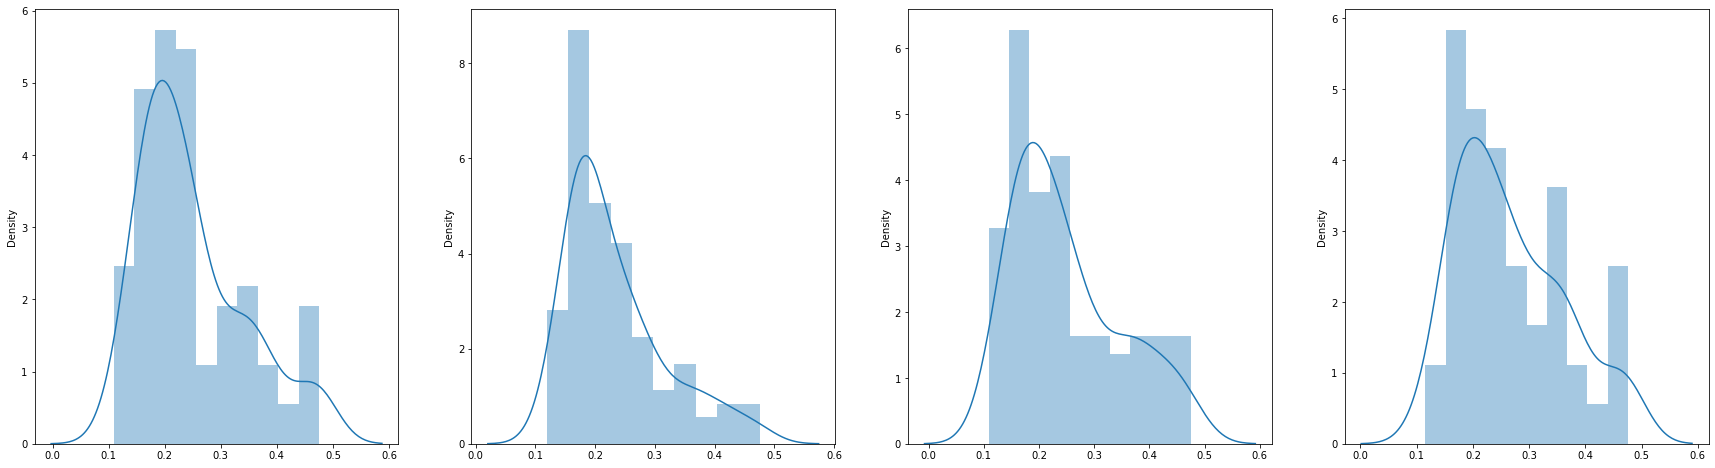

['ITOT', 'RYT', 'SCHG', 'SZK']
['ITOT', 'RYT', 'PGHY', 'SZK']
['ITOT', 'RYT', 'ARKG', 'SZK']
['ITOT', 'RYT', 'FDIS', 'SZK']
['ITOT', 'RYT', 'XCEM', 'SZK']
['ITOT', 'RYT', 'CSB', 'SZK']
['ITOT', 'RYT', 'SLQD', 'SZK']
['ITOT', 'RYT', 'EDIV', 'SZK']
['ITOT', 'RYT', 'KOLD', 'SZK']
['ITOT', 'RYT', 'HFXI', 'SZK']
['ITOT', 'RYT', 'DGRS', 'SZK']
['ITOT', 'RYT', 'EPOL', 'SZK']
['ITOT', 'RYT', 'FBZ', 'SZK']
['ITOT', 'RYT', 'CIL', 'SZK']
['ITOT', 'RYT', 'IGF', 'SZK']
['ITOT', 'RYT', 'SOYB', 'SZK']
['ITOT', 'RYT', 'EDV', 'SZK']
abc ok
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14085, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix


begin_total_asset:1000000
end_total_asset:2055766.047484426
Sharpe:  0.5968285224714758
hit end!
19
begin_total_asset:1000000
end_total_asset:995663.4782765579
Sharpe:  0.08273839812723384
hit end!
20
begin_total_asset:1000000
end_total_asset:1676171.4154838033
Sharpe:  0.5574349017038782
hit end!
21
begin_total_asset:1000000
end_total_asset:1797886.9739504093
Sharpe:  0.5392400406157912
hit end!
22
begin_total_asset:1000000
end_total_asset:1367272.524646777
Sharpe:  0.34543508319633
hit end!
23
begin_total_asset:1000000
end_total_asset:1137684.5474725214
Sharpe:  0.1896453731650745
hit end!
24
begin_total_asset:1000000
end_total_asset:980250.9292627876
Sharpe:  0.06432499335726535
hit end!
25
begin_total_asset:1000000
end_total_asset:1009603.6482745397
Sharpe:  0.09466475770797032
hit end!
26
begin_total_asset:1000000
end_total_asset:1246837.775005942
Sharpe:  0.2728269661247689
hit end!
27
begin_total_asset:1000000
end_total_asset:1088135.2046236363
Sharpe:  0.15831121017630906
hit e

begin_total_asset:1000000
end_total_asset:1717149.3532394883
Sharpe:  0.45524591283647137
hit end!
68
begin_total_asset:1000000
end_total_asset:1135484.0392201876
Sharpe:  0.18933784106580848
hit end!
69
begin_total_asset:1000000
end_total_asset:1386650.048730259
Sharpe:  0.34750992921545415
hit end!
70
begin_total_asset:1000000
end_total_asset:1537409.0839045253
Sharpe:  0.4139726521862092
hit end!
71
begin_total_asset:1000000
end_total_asset:1335938.304303748
Sharpe:  0.3283248525900548
hit end!
72
begin_total_asset:1000000
end_total_asset:1644732.9994831544
Sharpe:  0.49101839244419393
hit end!
73
begin_total_asset:1000000
end_total_asset:1170486.7834647193
Sharpe:  0.21556381913698683
hit end!
74
begin_total_asset:1000000
end_total_asset:1184681.1646485543
Sharpe:  0.2225225868526216
hit end!
75
begin_total_asset:1000000
end_total_asset:1789110.1934474506
Sharpe:  0.5376882617386748
hit end!
76
begin_total_asset:1000000
end_total_asset:1264177.7637748567
Sharpe:  0.2734979752721167

begin_total_asset:1000000
end_total_asset:969863.6451204184
Sharpe:  -0.032995487114982965
hit end!
17
begin_total_asset:1000000
end_total_asset:1059232.3727076952
Sharpe:  0.180294375515618
hit end!
18
begin_total_asset:1000000
end_total_asset:1383566.3430107182
Sharpe:  0.890049724178639
hit end!
19
begin_total_asset:1000000
end_total_asset:1140230.9187750968
Sharpe:  0.37284414542448713
hit end!
20
begin_total_asset:1000000
end_total_asset:1353625.8011610657
Sharpe:  0.8041401408550828
hit end!
21
begin_total_asset:1000000
end_total_asset:1207916.5191830276
Sharpe:  0.5133036815517809
hit end!
22
begin_total_asset:1000000
end_total_asset:1088965.1345291177
Sharpe:  0.2556713474097937
hit end!
23
begin_total_asset:1000000
end_total_asset:1123634.043979495
Sharpe:  0.3338267578891502
hit end!
24
begin_total_asset:1000000
end_total_asset:1175753.2065244764
Sharpe:  0.4525885819929866
hit end!
25
begin_total_asset:1000000
end_total_asset:1076139.475285081
Sharpe:  0.22545007713146548
hi

begin_total_asset:1000000
end_total_asset:1168370.3103703747
Sharpe:  0.43900278914611074
hit end!
66
begin_total_asset:1000000
end_total_asset:1176480.168932676
Sharpe:  0.44047890385299016
hit end!
67
begin_total_asset:1000000
end_total_asset:1183369.7228824173
Sharpe:  0.4587870086393413
hit end!
68
begin_total_asset:1000000
end_total_asset:1182940.2155764734
Sharpe:  0.4503978395804017
hit end!
69
begin_total_asset:1000000
end_total_asset:1257068.0781692497
Sharpe:  0.6378902675732392
hit end!
70
begin_total_asset:1000000
end_total_asset:1230254.063369535
Sharpe:  0.5719858301828341
hit end!
71
begin_total_asset:1000000
end_total_asset:1367814.8264991993
Sharpe:  0.8206147781934957
hit end!
72
begin_total_asset:1000000
end_total_asset:1232477.81992867
Sharpe:  0.5754566048038248
hit end!
73
begin_total_asset:1000000
end_total_asset:1361722.405350962
Sharpe:  0.8454742405569484
hit end!
74
begin_total_asset:1000000
end_total_asset:1313388.52575731
Sharpe:  0.7355168636399078
hit end

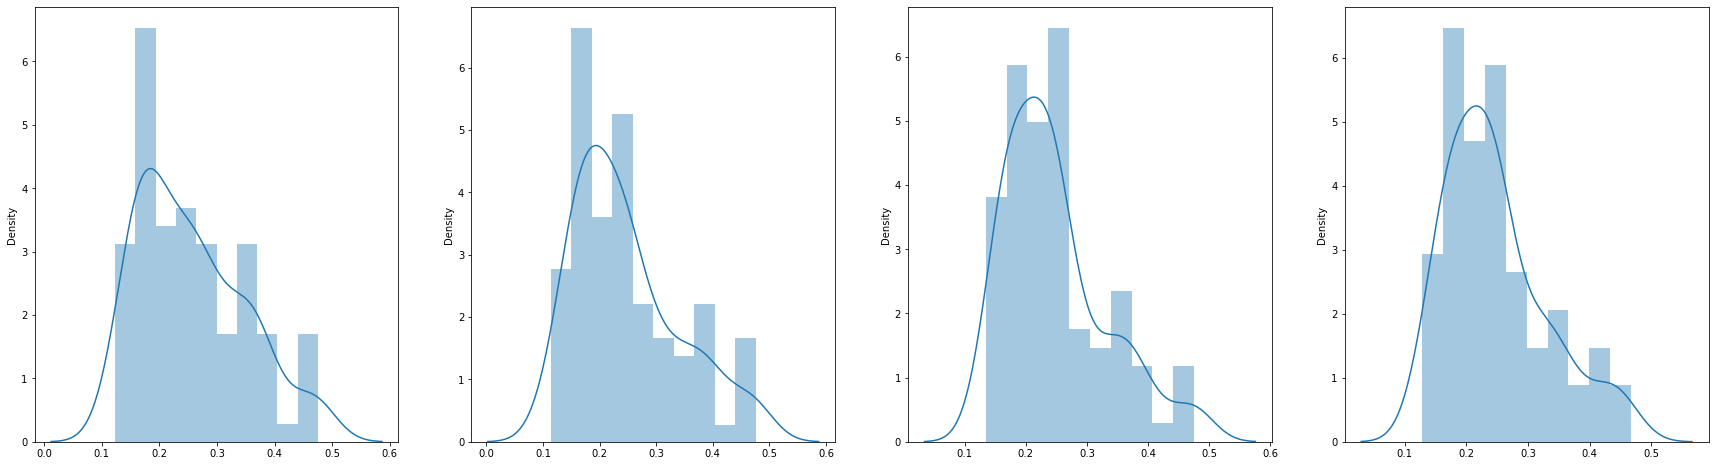

0 IEI 0.0892233105421175 0.24846494540572167
1 ITOT 0.08871006713359902 0.23676692172884942
2 RYT 0.08643435146002695 0.2404468434303999
3 SZK 0.10886265910537705 0.2743212912231684


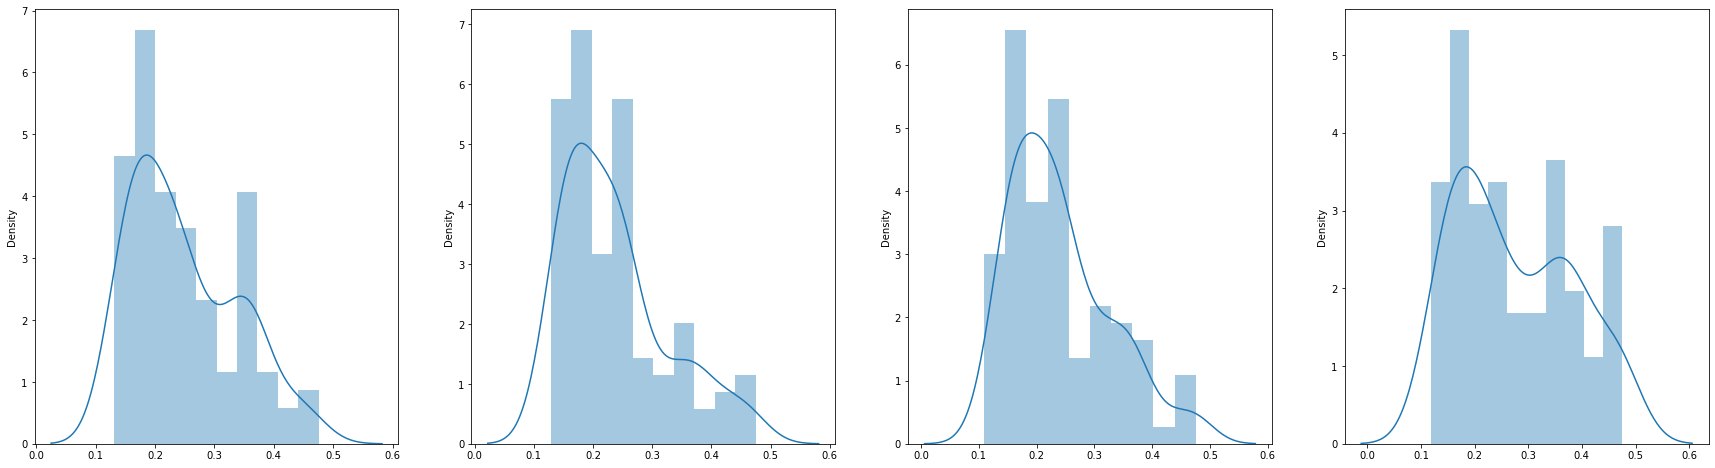

old_etfs: ['ITOT', 'RYT', 'IEI', 'SZK']
detect [['2016-06-17', 'SZK', 0.10791862103531538, 0.2652062945812941], ['2016-09-29', 'SZK', 0.10658321392749644, 0.2770963614434004], ['2017-03-30', 'RYT', 0.10671075781954276, 0.27760898031294345], ['2017-04-06', 'SZK', 0.1066496107105392, 0.26133389994502065], ['2018-01-19', 'IEI', 0.10697721796928635, 0.2632111570239067], ['2018-01-31', 'IEI', 0.1074593406411324, 0.2749122788012028], ['2018-02-06', 'IEI', 0.10611594358914783, 0.2795629154890776], ['2018-06-18', 'RYT', 0.10699286945652772, 0.2650798927247524], ['2018-08-22', 'RYT', 0.10676608124802867, 0.26192089065909385], ['2019-03-19', 'IEI', 0.11023167841979958, 0.26941030435264113], ['2019-11-25', 'SZK', 0.10766578862943768, 0.26031238250434396], ['2020-02-19', 'SZK', 0.10648531809563924, 0.2558291494101286], ['2020-09-18', 'ITOT', 0.10646888298135108, 0.27107617631554604], ['2020-12-30', 'SZK', 0.10886265910537705, 0.2743212912231684]]
ITOT ['ITOT', 'RYT', 'IEI', 'SZK']
VEU ['ITOT', 'RY

KeyboardInterrupt: 

In [128]:
last_detect_date = '2020-07-09'
# detect = detect_record[1]
detect_latest = ['2020-12-03', 'VNQ', 0.11141917498715548, 0.2624134092032909]
while True:
    random.shuffle(all_etf)
    print('old_etfs:',old_etfs)
    print('detect',detect)
    trained_model,now_etfs,detect_new,detect_latest,last_detect_date = find_new_target(old_etfs,detect,detect_latest,trained_model,last_detect_date)
#     if now_etfs is None:
    
    detect_record.append(detect_new)
    detect_date_record.append(detect_latest[0])
    etf_record.append(now_etfs)
    
#     last_detect_date = detect_latest[0]
    old_etfs = now_etfs.copy()
    detect = detect_new
    
    textfile = open("./detect_record/detect_record.txt", "a")
    if count<10:
        textfile.write('model_0'+str(count)+'\n')
    else:
        textfile.write('model_'+str(count)+'\n')
    for dtct_r in detect:
        for kkk in range(len(dtct_r)):
            element = dtct_r[kkk]
#             print(element)
            textfile.write(str(element))
            if kkk<len(dtct_r)-1:
                textfile.write("\t")
            else:
                textfile.write("\n")
    textfile.close()
    
    textfile = open("./detect_record/detect_date_record.txt", "a")
    textfile.write(detect_latest[0]+'\n')
    textfile.close()
    
    count+=1
    if detect_latest==[]:
        break

In [125]:
old_etfs,detect,detect_latest,trained_model,last_detect_date

(['ITOT', 'RYT', 'VNQ', 'SZK'],
 [['2016-03-30', 'SZK', 0.10795850861881308, 0.2694735585153103],
  ['2016-07-07', 'VNQ', 0.10901946723683845, 0.2660897923260927],
  ['2016-10-27', 'ITOT', 0.10739757753202209, 0.2716727389395237],
  ['2017-05-08', 'RYT', 0.10750210886081431, 0.25639768563210963],
  ['2017-11-07', 'ITOT', 0.1079624591500076, 0.2697722664475441],
  ['2019-06-28', 'RYT', 0.10682974432785587, 0.2542099657654762],
  ['2020-07-09', 'SZK', 0.11058612047625656, 0.2665571533888578],
  ['2020-12-03', 'VNQ', 0.11141917498715548, 0.2624134092032909]],
 None,
 None)

In [58]:
etf_record.append(['AGG', 'ITOT', 'EVX', 'PGF'])
etf_record

[['ITOT', 'VEU', 'VNQ', 'AGG'],
 ['RXD', 'VEU', 'VNQ', 'AGG'],
 ['RXD', 'VEU', 'VNQ', 'IWO'],
 ['RXD', 'FXO', 'VNQ', 'IWO'],
 ['TLT', 'FXO', 'VNQ', 'IWO'],
 ['TLT', 'FXO', 'VNQ', 'IWC'],
 ['TLT', 'USL', 'VNQ', 'IWC'],
 ['AGG', 'USL', 'VNQ', 'IWC'],
 ['AGG', 'ITOT', 'VNQ', 'IWC'],
 ['AGG', 'ITOT', 'VNQ', 'VEU'],
 ['AGG', 'PTH', 'VNQ', 'VEU'],
 ['AGG', 'ITOT', 'VNQ', 'VEU'],
 ['AGG', 'ITOT', 'EVX', 'VEU'],
 ['AGG', 'ITOT', 'EVX', 'PGF']]

In [59]:
detect_record[1]

[['2016-08-24', 'AGG', 0.10746809816091396, 0.2635297019779682],
 ['2018-04-02', 'VNQ', 0.10693665369998796, 0.256620285063982],
 ['2018-06-13', 'RXD', 0.10629979621019847, 0.2608689775317907],
 ['2019-06-07', 'AGG', 0.10815126231664743, 0.2749993725121021],
 ['2019-08-23', 'VEU', 0.1075520730645096, 0.2623667086660862],
 ['2019-10-21', 'VNQ', 0.10694576969674686, 0.27410597503185274],
 ['2020-02-25', 'VEU', 0.10626946048136726, 0.2593006370216608],
 ['2020-02-26', 'VNQ', 0.10754359984170532, 0.25696983203291895],
 ['2020-06-01', 'VNQ', 0.10793406434072116, 0.2703802848607302],
 ['2020-06-02', 'VNQ', 0.10728998139572035, 0.2835232515633106]]

In [44]:
get_avg_ABC(org_etfs,'2016-01-01','2016-07-07')

(0.12542786839079412, 0.09605559382392004, 0.057173820219037275)

In [30]:
detect

[['2016-08-24', 'AGG', 0.10746809816091396, 0.2635297019779682],
 ['2018-04-02', 'VNQ', 0.10693665369998796, 0.256620285063982],
 ['2018-06-13', 'RXD', 0.10629979621019847, 0.2608689775317907],
 ['2019-06-07', 'AGG', 0.10815126231664743, 0.2749993725121021],
 ['2019-08-23', 'VEU', 0.1075520730645096, 0.2623667086660862],
 ['2019-10-21', 'VNQ', 0.10694576969674686, 0.27410597503185274],
 ['2020-02-25', 'VEU', 0.10626946048136726, 0.2593006370216608],
 ['2020-02-26', 'VNQ', 0.10754359984170532, 0.25696983203291895],
 ['2020-06-01', 'VNQ', 0.10793406434072116, 0.2703802848607302],
 ['2020-06-02', 'VNQ', 0.10728998139572035, 0.2835232515633106]]

In [147]:
etf_record

[['VTI', 'TLT', 'IEF', 'GLD', 'DBC'],
 ['VTI', 'TLT', 'IEF', 'SIJ', 'DBC'],
 ['VTI', 'TLT', 'IEF', 'PVI', 'DBC'],
 ['VTI', 'EWP', 'IEF', 'PVI', 'DBC'],
 ['VTI', 'EWP', 'IEF', 'FXI', 'DBC'],
 ['GBF', 'EWP', 'IEF', 'FXI', 'DBC'],
 ['GBF', 'EWP', 'IEF', 'FXI', 'PLW'],
 ['GBF', 'EWP', 'IEF', 'FXI', 'IAI'],
 ['GBF', 'FEZ', 'IEF', 'FXI', 'IAI'],
 ['GBF', 'FEZ', 'IGN', 'FXI', 'IAI'],
 ['GBF', 'FEZ', 'IGN', 'RJA', 'IAI'],
 ['NYF', 'FEZ', 'IGN', 'RJA', 'IAI'],
 ['NYF', 'FEZ', 'TIP', 'RJA', 'IAI'],
 ['NYF', 'FEZ', 'GSG', 'RJA', 'IAI'],
 ['NYF', 'FEZ', 'BIL', 'RJA', 'IAI'],
 ['NYF', 'FXY', 'BIL', 'RJA', 'IAI'],
 ['NYF', 'FXY', 'TLT', 'RJA', 'IAI']]

In [129]:
filename = './detect_record/mean_stdev.txt'#


f = open(filename)
flag = False
dt_rcrd = []
etf_rcrd = []
tmp=[]
for line in f:
#     print(line[:-1])
    ttt = line[:-1]
    ttt_list = ttt.split('\t')
    print(ttt_list)
    if flag:
        tmp.append(ttt_list[0])
        print(tmp)
        if len(tmp)==4:
            etf_rcrd.append(tmp)
            tmp=[]
    if ttt_list[0]=='normal':
#         print('normal')
        flag=True
        tmp=[]
        dt_rcrd.append(ttt_list[1])
    if ttt_list[0]=='abnormal':
        flag = False
print(dt_rcrd)
print(etf_rcrd)
print(len(dt_rcrd),len(etf_rcrd))

['abnormal', '2016-01-13', 'ITOT']
['AGG', '0.09433962120935248', '0.2497670841217041']
['ITOT', '0.10812112909782724', '0.2605586825311184']
['VEU', '0.09281237366116779', '0.24423182778060437']
['VNQ', '0.09581255429744372', '0.24544240601360798']
['normal', '2016-01-13']
['AGG', '0.09426902718845345', '0.2522967605292797']
['AGG']
['RXD', '0.095177009188316', '0.2562474349886179']
['AGG', 'RXD']
['VEU', '0.08905572094897228', '0.2445390312373638']
['AGG', 'RXD', 'VEU']
['VNQ', '0.08946802849268302', '0.24691677823662758']
['AGG', 'RXD', 'VEU', 'VNQ']
['abnormal', '2016-03-09', 'RXD']
['abnormal']
['AGG', '0.09703752164804628', '0.2512808685004711']
['RXD', '0.10655235369800736', '0.26729426011443136']
['VEU', '0.09269623826910803', '0.24019408211112023']
['VNQ', '0.10027215439024452', '0.24123078286647798']
['normal', '2016-03-09']
['AGG', '0.07822122208396344', '0.23856478616595267']
['AGG']
['IXP', '0.0986233246366887', '0.2634537661075592']
['AGG', 'IXP']
['VEU', '0.0851555235365

In [132]:
dt_rcrd = dt_rcrd[:-1]
etf_rcrd = etf_rcrd[:-2]+etf_rcrd[-1:]

In [133]:
etf_rcrd.insert(0,org_etfs)
print(len(etf_rcrd))
etf_rcrd

23


[['ITOT', 'VEU', 'VNQ', 'AGG'],
 ['AGG', 'RXD', 'VEU', 'VNQ'],
 ['AGG', 'IXP', 'VEU', 'VNQ'],
 ['AGG', 'ITOT', 'VEU', 'VNQ'],
 ['BIV', 'ITOT', 'VEU', 'VNQ'],
 ['AGG', 'ITOT', 'VEU', 'VNQ'],
 ['AGG', 'SPLG', 'VEU', 'VNQ'],
 ['AGG', 'ITOT', 'VEU', 'VNQ'],
 ['AGG', 'ITOT', 'IWR', 'VEU'],
 ['AGG', 'ITOT', 'VEU', 'VNQ'],
 ['AGG', 'DBB', 'ITOT', 'VEU'],
 ['AGG', 'ITOT', 'VEU', 'VNQ'],
 ['AGG', 'ITOT', 'IYT', 'VNQ'],
 ['AGG', 'ITOT', 'VEU', 'VNQ'],
 ['ITOT', 'PTF', 'VEU', 'VNQ'],
 ['AGG', 'ITOT', 'VEU', 'VNQ'],
 ['AGG', 'ITOT', 'SOXX', 'VNQ'],
 ['ITOT', 'LQD', 'SOXX', 'VNQ'],
 ['ITOT', 'SHV', 'SOXX', 'VNQ'],
 ['ITOT', 'SOXX', 'TLH', 'VNQ'],
 ['ITOT', 'SOXX', 'SZK', 'VNQ'],
 ['ITOT', 'RYT', 'SZK', 'VNQ'],
 ['IEI', 'ITOT', 'RYT', 'SZK']]

In [134]:
len(dt_rcrd)

22

In [135]:
trade_action_list = []
trade_return_list = []
for i in range(len(etf_rcrd)):#etf_record
    now_etfs = etf_rcrd[i]
    now_df = get_data(now_etfs)
    print(now_df.tic.unique())
    trade_df_daily_return, trade_df_actions = trade_rl(now_df,org_trade_start,org_trade_end,trained_model,org_initial_amount)
    trade_action_list.append(trade_df_actions)
    trade_return_list.append(trade_df_daily_return)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index
targets: ['AGG' 'ITOT' 'VEU' 'VNQ']
['AGG' 'ITOT' 'VEU' 'VNQ']
begin_total_asset:1000000
end_total_asset:1402028.1535633958
Sharpe:  0.5488223624328638
hit end!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added techn

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index
targets: ['AGG' 'ITOT' 'VEU' 'VNQ']
['AGG' 'ITOT' 'VEU' 'VNQ']
begin_total_asset:1000000
end_total_asset:1346389.4810824753
Sharpe:  0.485585010608997
hit end!
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index
targets: ['IEI' 'ITOT' 'RYT' 'SZK']
['IEI' 'ITOT' 'RYT' 'SZK']
begin_total_asset:1000000
end_total_asset:1213348.3674334767
Sharpe:  0.5293153496170961
hit end!


In [92]:
# add mdd @2020/2/27
dt_rcrd.append('2020-02-27')
for i in range(len(etf_record)-1,len(etf_record)):
    now_etfs = ['AGG', 'EVX', 'ITOT', 'SHY'] #etf_record[i]
    now_df = get_data(now_etfs)
    print(now_df.tic.unique())
    trade_df_daily_return, trade_df_actions = trade_rl(now_df,org_trade_start,org_trade_end,trained_model,org_initial_amount)
    trade_action_list.append(trade_df_actions)
    trade_return_list.append(trade_df_daily_return)
#     trade_action_list[-1]=trade_df_actions
#     trade_return_list[-1]=trade_df_daily_return
print(len(trade_return_list),len(dt_rcrd))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index
targets: ['AGG' 'EVX' 'ITOT' 'SHY']
['AGG' 'EVX' 'ITOT' 'SHY']
begin_total_asset:1000000
end_total_asset:1582958.558410756
Sharpe:  1.0124801743950256
hit end!
15 14


In [108]:
detect_date_record

['2016-01-13',
 '2016-02-29',
 '2016-04-21',
 '2016-07-15',
 '2016-12-02',
 '2017-05-16',
 '2018-02-23',
 '2018-07-17',
 '2018-12-04',
 '2019-05-14',
 '2019-06-25',
 '2019-08-15',
 '2020-02-28',
 '2020-05-11',
 '2020-08-18',
 '2020-11-27']

In [155]:
dt_rcrd

['2016-01-13',
 '2016-03-09',
 '2016-03-28',
 '2016-04-29',
 '2016-05-02',
 '2016-08-01',
 '2016-08-02',
 '2016-10-05',
 '2016-10-06',
 '2016-10-24',
 '2016-10-25',
 '2017-03-17',
 '2017-06-05',
 '2018-01-11',
 '2018-01-24',
 '2018-06-04',
 '2018-08-08',
 '2018-08-31',
 '2019-06-25',
 '2019-08-27',
 '2020-01-03',
 '2020-12-03']

In [145]:
concate = []
detect_date_record_new = dt_rcrd.copy()#detect_date_record
detect_date_record_new.insert(0, "2016-01-04")
for i in range(len(detect_date_record_new)):
    if i!=len(detect_date_record_new)-1:
        trade_start = detect_date_record_new[i] 
        trade_end = detect_date_record_new[i+1]
        trade_df_daily_return = trade_return_list[i]
        start_idx = trade_df_daily_return[trade_df_daily_return['date'] == trade_start].index.tolist()[0]
        end_idx = trade_df_daily_return[trade_df_daily_return['date'] == trade_end].index.tolist()[0]
        df_toconcate = trade_df_daily_return[start_idx:end_idx]
    else:
        trade_start = detect_date_record_new[i] 
        trade_df_daily_return = trade_return_list[i]
        start_idx = trade_df_daily_return[trade_df_daily_return['date'] == trade_start].index.tolist()[0]
        df_toconcate = trade_df_daily_return[start_idx:]
    concate.append(df_toconcate)
new_trade_df_daily_return = pd.concat(concate,axis=0,ignore_index = True)
new_trade_df_daily_return

date  daily_return
0     2016-01-04      0.000000
1     2016-01-05      0.002433
2     2016-01-06     -0.009832
3     2016-01-07     -0.016559
4     2016-01-08     -0.007521
...          ...           ...
1254  2020-12-24     -0.002381
1255  2020-12-28      0.000772
1256  2020-12-29     -0.001979
1257  2020-12-30      0.000793
1258  2020-12-31      0.002703

[1259 rows x 2 columns]

In [115]:
'2016-03-25' in new_trade_df_daily_return['date']

False

In [146]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(new_trade_df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============New DRL Strategy Stats===========")
perf_stats_all

==============New DRL Strategy Stats===========


Annual return           0.057486
Cumulative returns      0.322137
Annual volatility       0.113877
Sharpe ratio            0.548046
Calmar ratio            0.331522
Stability               0.839376
Max drawdown           -0.173400
Omega ratio             1.109595
Sortino ratio           0.745870
Skew                   -0.948939
Kurtosis               12.562452
Tail ratio              0.963201
Daily value at risk    -0.014099
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [153]:
# from pyfolio import timeseries
# org_trade_df_daily_return = trade_return_list[0]
DRL_strat = convert_daily_return_to_pyfolio_ts(pd.read_csv(('./csv/classic_org.csv'))[['date','daily_return']])#org_trade_df_daily_return
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============Org DRL Strategy Stats===========")
perf_stats_all

==============Org DRL Strategy Stats===========


Annual return           0.056046
Cumulative returns      0.313168
Annual volatility       0.148647
Sharpe ratio            0.442276
Calmar ratio            0.187845
Stability               0.497115
Max drawdown           -0.298364
Omega ratio             1.102348
Sortino ratio           0.581465
Skew                   -2.141610
Kurtosis               39.181400
Tail ratio              0.972268
Daily value at risk    -0.018467
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [73]:
now_df = get_data(org_etfs)
print(now_df.tic.unique())
train_df_daily_return, train_df_actions = trade_rl(now_df,org_train_start,org_train_end,trained_model,org_initial_amount)
    
DRL_strat = convert_daily_return_to_pyfolio_ts(train_df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============Original DRL Strategy Stats @ train===========")
perf_stats_all

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (14104, 9)
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3525, 8)
Successfully added vix
Successfully added turbulence index
targets: ['AGG' 'ITOT' 'VEU' 'VNQ']
['AGG' 'ITOT' 'VEU' 'VNQ']
begin_total_asset:1000000
end_total_asset:1620584.1960934494
Sharpe:  0.49570016079679263
hit end!
==============Original DRL Strategy Stats @ train===========


Annual return           0.071487
Cumulative returns      0.620584
Annual volatility       0.167577
Sharpe ratio            0.495700
Calmar ratio            0.283052
Stability               0.781131
Max drawdown           -0.252559
Omega ratio             1.101982
Sortino ratio           0.713272
Skew                    0.282739
Kurtosis               10.609151
Tail ratio              0.971357
Daily value at risk    -0.020783
Alpha                   0.000000
Beta                    1.000000
dtype: float64

==============DRL Strategy Stats===========


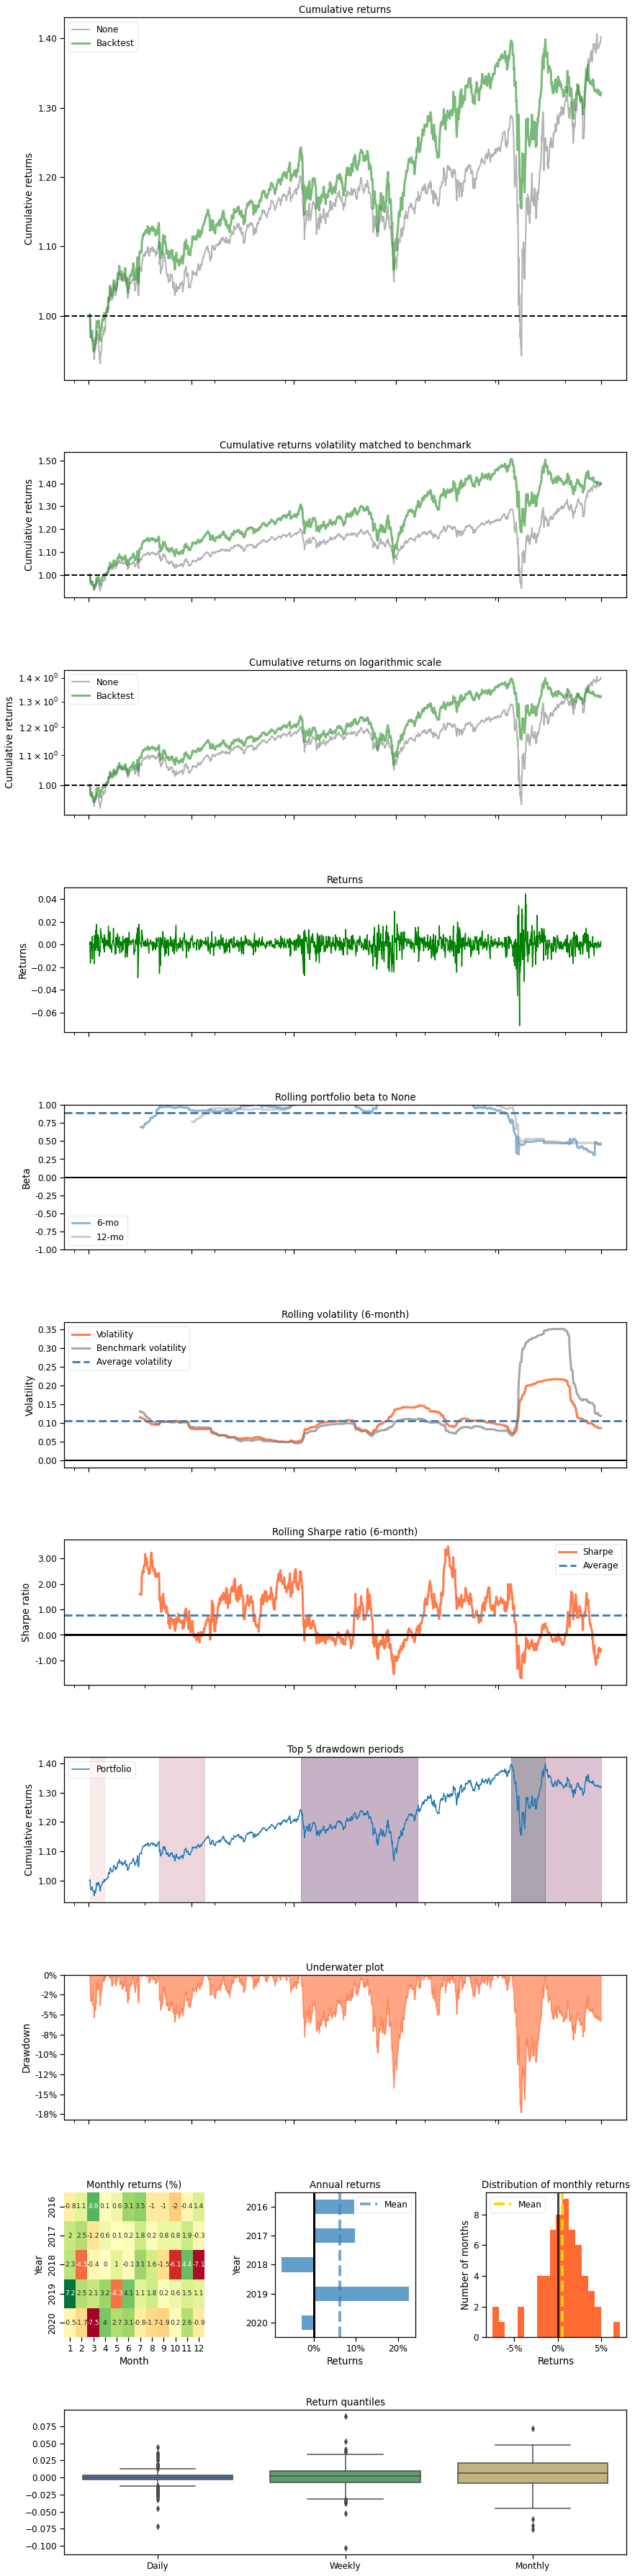

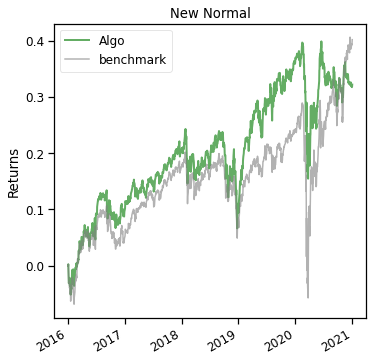

In [154]:
import pyfolio
DRL_strat_org = convert_daily_return_to_pyfolio_ts(org_trade_df_daily_return)

DRL_strat = convert_daily_return_to_pyfolio_ts(new_trade_df_daily_return)

print("==============DRL Strategy Stats===========")
#     print(perf_stats_all)
    
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=DRL_strat_org, set_context=False)

In [148]:
new_trade_df_daily_return.to_csv('./csv/classic_bound_change_new.csv')

In [90]:
trade_return_list[0].to_csv('./csv/classic_bound_org.csv')

In [149]:
for i in range(len(trade_return_list)):
    if i<10:
        iiiii = '0'+str(i)
    else:
        iiiii = str(i)
    trade_return_list[0].to_csv('./csv/classic_bound_new_'+iiiii+'.csv')

In [ ]:
new_trade_df_daily_return

In [151]:
pd.read_csv(('./csv/classic_bound_org.csv'))[['date','daily_return']]

date  daily_return
0     2016-01-04      0.000000
1     2016-01-05      0.003030
2     2016-01-06     -0.007570
3     2016-01-07     -0.018603
4     2016-01-08     -0.009245
...          ...           ...
1254  2020-12-24     -0.001413
1255  2020-12-28      0.004117
1256  2020-12-29     -0.001102
1257  2020-12-30      0.003675
1258  2020-12-31      0.002051

[1259 rows x 2 columns]

In [116]:
ttttttt = trade_return_list[0]
# ttttttt[ttttttt['date'] == '2016-01-06'].index.tolist()[0]
ttttttt

date  daily_return
0     2016-01-04      0.000000
1     2016-01-05      0.007143
2     2016-01-06     -0.007014
3     2016-01-07     -0.017240
4     2016-01-08     -0.009870
...          ...           ...
1254  2020-12-24     -0.000937
1255  2020-12-28      0.004194
1256  2020-12-29     -0.001869
1257  2020-12-30      0.004182
1258  2020-12-31      0.002169

[1259 rows x 2 columns]

In [ ]:
ttttttt

In [145]:
detect_record

[[['2016-01-13', 'GLD', 0.0933362530179434, 0.2123727920651436],
  ['2016-02-04', 'DBC', 0.08988390954391032, 0.2045540801435709],
  ['2016-03-03', 'TLT', 0.09012533061606283, 0.21767985872924328],
  ['2016-08-17', 'VTI', 0.0924398310016574, 0.20876439034938812],
  ['2017-01-05', 'GLD', 0.09024696837009308, 0.2220992189645767],
  ['2018-05-02', 'VTI', 0.09250040291739847, 0.21479879148304462],
  ['2018-09-25', 'DBC', 0.09248051598587126, 0.20985354743897916],
  ['2019-02-20', 'IEF', 0.09304782070489107, 0.2113288712501526],
  ['2019-07-23', 'TLT', 0.09048391307352975, 0.21071806341409682],
  ['2019-12-12', 'TLT', 0.09369773445405943, 0.20794439606368542],
  ['2020-02-24', 'VTI', 0.09242363414572387, 0.21347353234887123],
  ['2020-04-24', 'TLT', 0.09004515169513111, 0.21246609948575496],
  ['2020-06-26', 'TLT', 0.08966867180732581, 0.20496587321162224],
  ['2020-09-02', 'GLD', 0.09063282894293141, 0.22320424027740957],
  ['2020-10-23', 'GLD', 0.0915966966394929, 0.20684149265289306]]]

In [100]:
detect = detect_record[0]
detect

[['2016-01-13', 'ITOT', 0.10812112909782724, 0.2605586825311184],
 ['2016-03-03', 'VNQ', 0.10885750332628194, 0.27515421390533445],
 ['2016-07-12', 'AGG', 0.10659958107942404, 0.26254845298826696],
 ['2016-11-22', 'AGG', 0.10746072355781695, 0.26103378370404245],
 ['2018-02-06', 'VNQ', 0.10616891408313689, 0.25836283057928083],
 ['2018-03-02', 'AGG', 0.10738305581207964, 0.2791201673448086],
 ['2018-06-13', 'VNQ', 0.10721671346121277, 0.2635794802010059],
 ['2019-07-12', 'AGG', 0.10823394185098739, 0.2780128914117813],
 ['2019-12-12', 'VNQ', 0.10628339926926171, 0.257767391204834],
 ['2020-10-23', 'ITOT', 0.11076516202560502, 0.25458020277321336]]

In [102]:
detect_date_record = [detect_date_record[0]]
detect_date_record

['2016-01-13']

In [103]:
detect_record = [detect_record[0]]
detect_record

[[['2016-01-13', 'ITOT', 0.10812112909782724, 0.2605586825311184],
  ['2016-03-03', 'VNQ', 0.10885750332628194, 0.27515421390533445],
  ['2016-07-12', 'AGG', 0.10659958107942404, 0.26254845298826696],
  ['2016-11-22', 'AGG', 0.10746072355781695, 0.26103378370404245],
  ['2018-02-06', 'VNQ', 0.10616891408313689, 0.25836283057928083],
  ['2018-03-02', 'AGG', 0.10738305581207964, 0.2791201673448086],
  ['2018-06-13', 'VNQ', 0.10721671346121277, 0.2635794802010059],
  ['2019-07-12', 'AGG', 0.10823394185098739, 0.2780128914117813],
  ['2019-12-12', 'VNQ', 0.10628339926926171, 0.257767391204834],
  ['2020-10-23', 'ITOT', 0.11076516202560502, 0.25458020277321336]]]

In [104]:
len(models_path)

1

In [85]:
models_path = [models_path[0]]
len(models_path)

1

In [105]:
etf_record

[['ITOT', 'VEU', 'VNQ', 'AGG']]

In [86]:
detect[0]

['2016-01-13', 'ITOT', 0.10812112909782724, 0.2605586825311184]

In [21]:

textfile = open("test.txt", "a")
for element in all_etf:
    textfile.write(element )#+ "\n"
    break
textfile.close()

In [27]:
ddate = detect[0][0]
dtarget = detect[0][1]
textfile = open("./detect_record/mean_stdev.txt", "a")
textfile.write('abnormal'+'\t'+ddate+'\t'+dtarget+"\n") #+ "\n"

col = 'AGG'
stdev = 0.07940685351231604
mean = 0.23440811523795127
textfile.write(col+'\t'+str(stdev)+'\t'+str(mean)+"\n")
col = 'ITOT'
stdev = 0.09217295625711144
mean = 0.24869663262367248
textfile.write(col+'\t'+str(stdev)+'\t'+str(mean)+"\n")
col = 'VEU'
stdev = 0.09490323353251168
mean = 0.25074284413456915
textfile.write(col+'\t'+str(stdev)+'\t'+str(mean)+"\n")
col = 'VNQ'
stdev = 0.10209013791091004
mean = 0.2661524080634117
textfile.write(col+'\t'+str(stdev)+'\t'+str(mean)+"\n")
textfile.close()

In [70]:
detect_record

[[['2016-01-13', 'ITOT', 0.10812112909782724, 0.2605586825311184],
  ['2016-03-03', 'VNQ', 0.10885750332628194, 0.27515421390533445],
  ['2016-07-12', 'AGG', 0.10659958107942404, 0.26254845298826696],
  ['2016-11-22', 'AGG', 0.10746072355781695, 0.26103378370404245],
  ['2018-02-06', 'VNQ', 0.10616891408313689, 0.25836283057928083],
  ['2018-03-02', 'AGG', 0.10738305581207964, 0.2791201673448086],
  ['2018-06-13', 'VNQ', 0.10721671346121277, 0.2635794802010059],
  ['2019-07-12', 'AGG', 0.10823394185098739, 0.2780128914117813],
  ['2019-12-12', 'VNQ', 0.10628339926926171, 0.257767391204834],
  ['2020-10-23', 'ITOT', 0.11076516202560502, 0.25458020277321336]],
 [['2016-01-13', 'SPEM', 0.10808090359122413, 0.2605268868803978],
  ['2016-03-03', 'VNQ', 0.10879868490901283, 0.27492319509387014],
  ['2016-07-12', 'AGG', 0.10660433658347687, 0.26257724180817604],
  ['2016-11-22', 'AGG', 0.10764081693624541, 0.2615872386842966],
  ['2018-02-06', 'VNQ', 0.10624077006209544, 0.2586048001050949],


In [48]:
textfile = open("./detect_record/detect_record.txt", "w")
for dtct_r in detect_record[0]:
    for kkk in range(len(dtct_r)):
        element = dtct_r[kkk]
        print(element)
        textfile.write(str(element))
        if kkk<len(dtct_r)-1:
            textfile.write("\t")
        else:
            textfile.write("\n")
textfile.close()

2016-08-02
VNQ
0.10209013791091007
0.2661524080634117
2017-02-03
VEU
0.101576850715069
0.26044996801018716
2017-07-20
AGG
0.10407765038534761
0.2593575109243393
2017-11-01
AGG
0.10177260602714638
0.26410511961579325
2018-04-12
VEU
0.10121568054575923
0.26719704815745354
2018-05-08
ITOT
0.10289932852607224
0.26378620240092276
2018-05-22
ITOT
0.10233262000654224
0.263660445690155
2018-05-25
ITOT
0.10154624782423516
0.26359190547466277
2018-12-06
VEU
0.10155432323898123
0.26002378365397455
2019-11-06
VEU
0.10128521747646074
0.25794837218523026
